In [1]:

import json
from datetime import datetime

# Load the full JSON
with open('data/ep_votes.json', 'r') as f:
    data = json.load(f)

# Define European Parliament mandates (5-year periods)
mandates = {
    '6': ('2004-07-01', '2009-06-30'),
    '7': ('2009-07-01', '2014-06-30'),
    '8': ('2014-07-01', '2019-06-30'),
    '9': ('2019-07-01', '2024-06-30'),
    '10': ('2024-07-01', '2029-06-30')
}

# Parse mandate start and end dates
mandate_ranges = {}
for key, (start_str, end_str) in mandates.items():
    start = datetime.strptime(start_str, "%Y-%m-%d")
    end = datetime.strptime(end_str, "%Y-%m-%d")
    mandate_ranges[key] = (start, end)

# Function to assign mandate based on TS string
def assign_mandate(ts_str):
    try:
        date = datetime.fromisoformat(ts_str)
    except Exception:
        return 'Other'
    for key, (start, end) in mandate_ranges.items():
        if start <= date <= end:
            return key
    return 'Other'

# Only include data where 'votes' key is present, not None, and not empty
def has_valid_votes(obj):
    votes = obj.get('votes')
    if votes is None:
        return False
    if votes == {} or votes == []:
        return False
    return True

# Split the JSON objects into mandate buckets, filtering by valid 'votes'
mandate_jsons = {key: [] for key in mandates.keys()}
for obj in data:
    if not has_valid_votes(obj):
        continue
    ts = obj.get('TS') or obj.get('ts')  # support both uppercase and lowercase
    mandate = assign_mandate(ts)
    if mandate in mandate_jsons:
        mandate_jsons[mandate].append(obj)

# Save each mandate's data as a separate JSON
for mandate_name, mandate_objs in mandate_jsons.items():
    print(f"{mandate_name}: {len(mandate_objs)} records")
    with open(f'data/ep_votes_{mandate_name}.json', 'w') as f:
        json.dump(mandate_objs, f, ensure_ascii=False, indent=2)

6: 5838 records
7: 4360 records
8: 11286 records
9: 18827 records
10: 2682 records


In [2]:
def getListVotes(mandate):
    # Fix variable name: use 'mandate' (parameter) instead of 'mandate_name'
    with open(f'data/ep_votes_{mandate}.json', 'r') as f:
        data = json.load(f)

    listVotes = []
    listMEPs = []
    for session in data:
        for voteType in session['votes']:
            for group in session['votes'][voteType]['groups']:
                for vote in session['votes'][voteType]['groups'][group]:
                    if voteType == '+':
                        voteWeight = 1
                    if voteType == '-':
                        voteWeight = -1
                    if voteType == '0':
                        voteWeight = 0
                    if 'mepid' in vote.keys():
                        mepId = 'M' + str(vote['mepid'])
                        voteData = (mepId, str(session['voteid']), voteWeight)
                        listVotes.append(voteData)
                        listMEPs.append(mepId)

    return listVotes, set(listMEPs)

def getSimilarityMatrix(listVotes):
    import numpy as np
    import pandas as pd

    # listVotes: iterable of (mepid, voteid, weight)
    votes = pd.DataFrame(listVotes, columns=['mepid', 'voteid', 'weight'])

    # Exclude abstentions (weight == 0)
    votes = votes[votes['weight'] != 0]

    # MEPs who voted in > half of all votes
    total_votes = votes["voteid"].nunique()
    if total_votes == 0:
        return {}
    mep_vote_counts = votes["mepid"].value_counts()
    meps = mep_vote_counts[mep_vote_counts > (total_votes / 2)].index

    if len(meps) < 2:
        return {}

    # voteid × mepid pivot; if duplicates per (voteid, mepid) exist, use first
    pivot = votes.pivot_table(
        index='voteid', columns='mepid', values='weight', aggfunc='first'
    ).reindex(columns=meps)

    # Dense matrix with 0 where no vote
    # Ensure values are strictly in {-1, 0, +1}
    A8 = np.sign(pivot.fillna(0).to_numpy(dtype=np.int8))  # compact for memory

    # Cast to wider type BEFORE matmul to avoid overflow
    A = A8.astype(np.int32)
    B = (A != 0).astype(np.int32)

    # Numerator: agreements (+1) minus disagreements (-1)
    numer = A.T @ A          # int32 accumulation, no overflow
    # Denominator: overlapping nonzero votes
    denom = B.T @ B

    # Similarity in [-1, 1]; NaN where no overlap
    with np.errstate(divide='ignore', invalid='ignore'):
        sim = numer / denom.astype(np.float32)
        sim[denom == 0] = np.nan

    # Build dict for upper triangle pairs
    mep_list = list(pivot.columns)
    results = {}
    n = len(mep_list)
    for i in range(n):
        for j in range(i + 1, n):
            val = sim[i, j]
            results[(mep_list[i], mep_list[j])] = None if np.isnan(val) else round(float(val), 3)

    return results

def getEdges(listVotes):
    result = getSimilarityMatrix(listVotes)
    
    # Get the list of MEPs that were included in the similarity matrix
    # (those who voted in >50% of votes)
    import pandas as pd
    votes = pd.DataFrame(listVotes, columns=['mepid', 'voteid', 'weight'])
    votes = votes[votes['weight'] != 0]  # Exclude abstentions
    total_votes = votes["voteid"].nunique()
    if total_votes == 0:
        return pd.DataFrame(columns=['Source', 'Target', 'Weight']), set()
    
    mep_vote_counts = votes["mepid"].value_counts()
    filtered_meps = set(mep_vote_counts[mep_vote_counts > (total_votes / 2)].index)
    
    df = pd.DataFrame([(source, target, weight) for (source, target), weight in result.items()], 
                      columns=['Source', 'Target', 'Weight'])
    
    return df, filtered_meps




import itertools

def getNodes(mandate_number, list_meps):
    import pprint
    import itertools
    from datetime import datetime
    
    # Try to be tolerant to set/list for list_meps and always operate on set for membership
    if isinstance(list_meps, set):
        first_ten = list(itertools.islice(list_meps, 10))
        list_meps_set = set(list_meps)
    else:
        print("DEBUG: list_meps[:10] =", list_meps[:10])
        list_meps_set = set(list_meps)

    with open('data/ep_meps.json', 'r') as f:
        meps_data = json.load(f)

    results = []

    filtered_meps = [mep for mep in meps_data if f"M{mep.get('UserID')}" in list_meps_set]

    # Prepare mandate_number as str and int for comparison
    try:
        mandate_number_int = int(mandate_number)
    except Exception:
        mandate_number_int = mandate_number
    mandate_number_str = str(mandate_number)

    # Get mandate date range for date-based matching
    mandates = {
        '6': ('2004-07-01', '2009-06-30'),
        '7': ('2009-07-01', '2014-06-30'),
        '8': ('2014-07-01', '2019-06-30'),
        '9': ('2019-07-01', '2024-06-30'),
        '10': ('2024-07-01', '2029-06-30')
    }
    
    mandate_key = str(mandate_number_int)
    mandate_start_date = None
    mandate_end_date = None
    is_current_mandate = (mandate_number_int == 10)  # Only mandate 10 is current
    
    if mandate_key in mandates:
        start_str, end_str = mandates[mandate_key]
        mandate_start_date = datetime.strptime(start_str, "%Y-%m-%d")
        mandate_end_date = datetime.strptime(end_str, "%Y-%m-%d")

    # Acceptable types for term matching in Constituencies only
    term_values = {mandate_number, mandate_number_int, mandate_number_str}

    for i, mep in enumerate(filtered_meps):
        user_id = mep.get('UserID')
        full_name = mep.get('Name', {}).get('full', '')
        groups = mep.get('Groups', [])
        
        # Filter groups by date range (ignore term field completely)
        mandate_groups = []
        
        if mandate_start_date and mandate_end_date:
            for g in groups:
                start_str = g.get('start', '')
                end_str = g.get('end', '')
                
                try:
                    if not start_str:
                        continue
                    
                    start_date = datetime.fromisoformat(start_str.replace('Z', '+00:00').split('T')[0])
                    
                    # Check if end date is "9999-12-31" (ongoing group)
                    is_ongoing = False
                    if end_str:
                        # Check if end date is a future placeholder (9999-12-31)
                        if '9999' in end_str or end_str.endswith('9999-12-31'):
                            is_ongoing = True
                            # Only treat as ongoing if it's the current mandate (10)
                            # For past mandates, treat 9999 as a very late date but not special
                            if is_current_mandate:
                                end_date = datetime.max  # Treat as latest possible date for mandate 10
                            else:
                                # For past mandates, parse 9999 as a regular date
                                end_date = datetime.fromisoformat(end_str.replace('Z', '+00:00').split('T')[0])
                        else:
                            try:
                                end_date = datetime.fromisoformat(end_str.replace('Z', '+00:00').split('T')[0])
                            except:
                                # If end date parsing fails, check if start is within mandate
                                if mandate_start_date <= start_date <= mandate_end_date:
                                    is_ongoing = True
                                    end_date = datetime.max
                                else:
                                    continue
                    else:
                        # No end date means ongoing
                        is_ongoing = True
                        # Only treat as special for mandate 10
                        if is_current_mandate:
                            end_date = datetime.max
                        else:
                            # For past mandates, assume it ended at mandate end
                            end_date = mandate_end_date
                    
                    # Check if group overlaps with mandate period
                    if is_ongoing and is_current_mandate:
                        # Ongoing groups for current mandate: active if started before/at mandate end
                        if start_date <= mandate_end_date:
                            mandate_groups.append((g, end_date, True))  # True = ongoing
                    else:
                        # Regular groups: overlap if starts before/at mandate end and ends after/at mandate start
                        if start_date <= mandate_end_date and end_date >= mandate_start_date:
                            mandate_groups.append((g, end_date, False))  # False = ended
                except Exception as e:
                    print(f"DEBUG: Error parsing dates for MEP {user_id} group: {e}")
                    continue
        
        # Select group based on count
        if len(mandate_groups) == 0:
            print(f"WARNING: MEP {user_id} has NO groups overlapping with mandate period")
            pprint.pprint(groups)
        elif len(mandate_groups) == 1:
            # If only one group, use it
            mandate_groups = [mandate_groups[0][0]]
        else:
            # If multiple groups, use the one with latest end date
            # For mandate 10: prioritize ongoing groups (True), then sort by end date (latest first)
            # For past mandates: just sort by end date (latest first)
            if is_current_mandate:
                # Sort by: ongoing groups first (True), then by end date (latest first)
                mandate_groups.sort(key=lambda x: (x[2], x[1]), reverse=True)
            else:
                # For past mandates, just sort by end date (latest first)
                mandate_groups.sort(key=lambda x: x[1], reverse=True)
            mandate_groups = [mandate_groups[0][0]]


        # Get Constituencies for this mandate - filter by term and get the last one
        constituencies = mep.get('Constituencies', [])
        mandate_constituencies = [
            c for c in constituencies if c.get('term') in term_values
        ]


        # If no groups/constituencies found for this mandate, skip this MEP
        if not mandate_groups or not mandate_constituencies:
            print(f"Skipping MEP {user_id}: missing group or constituency")
            continue

        # Get the selected group
        selected_group = mandate_groups[0]
        group_id = selected_group.get('groupid', '')

        # Apply groupId mapping logic as per prompt
        if group_id == "NA" or (group_id is not None and str(group_id).strip() == "NA"):
            mapped_group_id = "NonAttached"
        elif group_id == "Patriots for Europe Group":
            mapped_group_id = "PfE"
        elif group_id == "Europe of Sovereign Nations Group":
            mapped_group_id = "ESN"
        else:
            mapped_group_id = group_id

        # Get the last constituency
        last_constituency = sorted(mandate_constituencies, key=lambda x: x.get('start', ''))[-1]
        country = last_constituency.get('country', '')

        results.append({
            'Id': "M" + str(user_id),
            'FullName': full_name,
            'Country': country,
            'GroupID': mapped_group_id
        })

    return pd.DataFrame(results)
    
def getNodesAndEdges(mandate):
    listVotes, listMEPs = getListVotes(mandate)
    edges, filtered_meps = getEdges(listVotes) 
    nodes = getNodes(mandate, filtered_meps)  
    return nodes, edges





In [ ]:
import os
import pandas as pd
import pprint

def getNodesForWeb(mandate_number, list_meps):
    """
    Get enriched node data for web export.
    Includes: party names, photo URL, and all groups with dates.
    """
    from datetime import datetime
    
    # Convert list_meps to set for membership checks
    if isinstance(list_meps, set):
        list_meps_set = set(list_meps)
    else:
        list_meps_set = set(list_meps)

    with open('data/ep_meps.json', 'r') as f:
        meps_data = json.load(f)

    results = []

    filtered_meps = [mep for mep in meps_data if f"M{mep.get('UserID')}" in list_meps_set]

    # Prepare mandate_number as str and int for comparison
    try:
        mandate_number_int = int(mandate_number)
    except Exception:
        mandate_number_int = mandate_number
    mandate_number_str = str(mandate_number)

    # Get mandate date range for date-based matching
    mandates = {
        '6': ('2004-07-01', '2009-06-30'),
        '7': ('2009-07-01', '2014-06-30'),
        '8': ('2014-07-01', '2019-06-30'),
        '9': ('2019-07-01', '2024-06-30'),
        '10': ('2024-07-01', '2029-06-30')
    }
    
    mandate_key = str(mandate_number_int)
    mandate_start_date = None
    mandate_end_date = None
    is_current_mandate = (mandate_number_int == 10)
    
    if mandate_key in mandates:
        start_str, end_str = mandates[mandate_key]
        mandate_start_date = datetime.strptime(start_str, "%Y-%m-%d")
        mandate_end_date = datetime.strptime(end_str, "%Y-%m-%d")

    # Acceptable types for term matching in Constituencies
    term_values = {mandate_number, mandate_number_int, mandate_number_str}

    for mep in filtered_meps:
        user_id = mep.get('UserID')
        full_name = mep.get('Name', {}).get('full', '')
        photo_url = mep.get('Photo', '')
        groups = mep.get('Groups', [])
        constituencies = mep.get('Constituencies', [])
        
        # Filter groups by date range - get ALL groups that overlap with mandate
        mandate_groups = []
        
        if mandate_start_date and mandate_end_date:
            for g in groups:
                start_str = g.get('start', '')
                end_str = g.get('end', '')
                
                try:
                    if not start_str:
                        continue
                    
                    start_date = datetime.fromisoformat(start_str.replace('Z', '+00:00').split('T')[0])
                    
                    is_ongoing = False
                    if end_str:
                        if '9999' in end_str or end_str.endswith('9999-12-31'):
                            is_ongoing = True
                            if is_current_mandate:
                                end_date = datetime.max
                            else:
                                end_date = datetime.fromisoformat(end_str.replace('Z', '+00:00').split('T')[0])
                        else:
                            try:
                                end_date = datetime.fromisoformat(end_str.replace('Z', '+00:00').split('T')[0])
                            except:
                                if mandate_start_date <= start_date <= mandate_end_date:
                                    is_ongoing = True
                                    end_date = datetime.max
                                else:
                                    continue
                    else:
                        is_ongoing = True
                        if is_current_mandate:
                            end_date = datetime.max
                        else:
                            end_date = mandate_end_date
                    
                    # Check if group overlaps with mandate period
                    if is_ongoing and is_current_mandate:
                        if start_date <= mandate_end_date:
                            group_id = g.get('groupid', '')
                            # Apply groupId mapping
                            if group_id == "NA" or (group_id is not None and str(group_id).strip() == "NA"):
                                mapped_group_id = "NonAttached"
                            elif group_id == "Patriots for Europe Group":
                                mapped_group_id = "PfE"
                            elif group_id == "Europe of Sovereign Nations Group":
                                mapped_group_id = "ESN"
                            else:
                                mapped_group_id = group_id
                            
                            mandate_groups.append({
                                'groupid': mapped_group_id,
                                'start': start_str.split('T')[0] if start_str else '',
                                'end': None  # Ongoing
                            })
                    else:
                        if start_date <= mandate_end_date and end_date >= mandate_start_date:
                            group_id = g.get('groupid', '')
                            # Apply groupId mapping
                            if group_id == "NA" or (group_id is not None and str(group_id).strip() == "NA"):
                                mapped_group_id = "NonAttached"
                            elif group_id == "Patriots for Europe Group":
                                mapped_group_id = "PfE"
                            elif group_id == "Europe of Sovereign Nations Group":
                                mapped_group_id = "ESN"
                            else:
                                mapped_group_id = group_id
                            
                            mandate_groups.append({
                                'groupid': mapped_group_id,
                                'start': start_str.split('T')[0] if start_str else '',
                                'end': end_str.split('T')[0] if end_str else ''
                            })
                except Exception as e:
                    continue
        
        # Get Constituencies for this mandate - get ALL parties
        mandate_constituencies = [
            c for c in constituencies if c.get('term') in term_values
        ]
        
        # Get unique party names from constituencies
        party_names = []
        if mandate_constituencies:
            # Get all unique party names
            parties = set()
            for c in mandate_constituencies:
                party = c.get('party', '')
                if party:
                    parties.add(party)
            party_names = sorted(list(parties))
        
        # Get country from last constituency
        country = ''
        if mandate_constituencies:
            last_constituency = sorted(mandate_constituencies, key=lambda x: x.get('start', ''))[-1]
            country = last_constituency.get('country', '')
        
        # If no groups or constituencies found for this mandate, skip this MEP
        if not mandate_groups or not mandate_constituencies:
            continue
        
        # Build node data
        node_data = {
            'Id': f"M{user_id}",
            'FullName': full_name,
            'Country': country,
            'PartyNames': party_names,  # List of party names
            'PhotoURL': photo_url,
            'Groups': mandate_groups  # List of all groups with dates
        }
        
        # If only one group, also include GroupID for backward compatibility
        if len(mandate_groups) == 1:
            node_data['GroupID'] = mandate_groups[0]['groupid']
        else:
            # Use the group with latest end date (or ongoing if multiple)
            sorted_groups = sorted(mandate_groups, 
                                  key=lambda x: (x['end'] is None, x['end'] or ''), 
                                  reverse=True)
            node_data['GroupID'] = sorted_groups[0]['groupid']
        
        results.append(node_data)

    return results

def normalizeEdgeWeights(edges_df):
    """
    Normalize edge weights from [-1, 1] to [0, 1].
    Formula: (weight + 1) / 2
    """
    edges_normalized = edges_df.copy()
    edges_normalized['Weight'] = (edges_normalized['Weight'] + 1) / 2
    return edges_normalized

def generateWebFilesForMandate(mandate):
    """
    Generate JSON files for web export with normalized edge weights and enriched node data.
    """
    print(f"Processing Mandate {mandate} for web export...")
    
    # Create folder for web export (in web/public/data to match existing structure)
    folder_name = f'web/public/data/mandate_{mandate}'
    os.makedirs(folder_name, exist_ok=True)
    
    try:
        # Get nodes and edges for this mandate
        listVotes, listMEPs = getListVotes(mandate)
        edges, filtered_meps = getEdges(listVotes)
        
        # Normalize edge weights from [-1, 1] to [0, 1]
        edges_normalized = normalizeEdgeWeights(edges)
        
        # Get enriched nodes
        nodes_list = getNodesForWeb(mandate, filtered_meps)
        
        # Convert edges to list of dictionaries
        edges_list = edges_normalized.to_dict('records')
        
        # Create output structure
        output_data = {
            'mandate': mandate,
            'nodes': nodes_list,
            'edges': edges_list,
            'metadata': {
                'nodeCount': len(nodes_list),
                'edgeCount': len(edges_list),
                'weightRange': {
                    'min': float(edges_normalized['Weight'].min()),
                    'max': float(edges_normalized['Weight'].max())
                }
            }
        }
        
        # Save as JSON
        output_path = os.path.join(folder_name, 'data.json')
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(output_data, f, ensure_ascii=False, indent=2)
        
        print(f"  ✓ Saved {len(nodes_list)} nodes and {len(edges_list)} edges to {output_path}")
        print(f"  ✓ Edge weights normalized to range [{output_data['metadata']['weightRange']['min']:.3f}, {output_data['metadata']['weightRange']['max']:.3f}]")
        
        return output_data
        
    except Exception as e:
        print(f"  ✗ Error processing mandate {mandate}: {e}")
        import traceback
        traceback.print_exc()
        return None

def generateAllWebFiles():
    """
    Generate web files for all mandates.
    """
    mandates = ['6', '7', '8', '9', '10']
    
    print("Generating web files for all mandates...")
    print("=" * 60)
    
    for mandate in mandates:
        generateWebFilesForMandate(mandate)
    
    print("=" * 60)
    print("✓ Completed generating web files for all mandates")


In [5]:
# Generate web files for all mandates
# Uncomment the line below to run:
generateAllWebFiles()


Generating web files for all mandates...
Processing Mandate 6 for web export...
  ✓ Saved 658 nodes and 216153 edges to web/public/data/mandate_6/data.json
  ✓ Edge weights normalized to range [0.202, 0.996]
Processing Mandate 7 for web export...
  ✓ Saved 714 nodes and 254541 edges to web/public/data/mandate_7/data.json
  ✓ Edge weights normalized to range [0.174, 0.997]
Processing Mandate 8 for web export...
  ✓ Saved 694 nodes and 240471 edges to web/public/data/mandate_8/data.json
  ✓ Edge weights normalized to range [0.190, 0.998]
Processing Mandate 9 for web export...
  ✓ Saved 697 nodes and 242556 edges to web/public/data/mandate_9/data.json
  ✓ Edge weights normalized to range [0.190, 1.000]
Processing Mandate 10 for web export...
  ✓ Saved 702 nodes and 246051 edges to web/public/data/mandate_10/data.json
  ✓ Edge weights normalized to range [0.130, 1.000]
✓ Completed generating web files for all mandates


In [133]:
import os
def generate_all_mandates():
    mandates = ['6', '7', '8', '9', '10']
    
    for mandate in mandates:
        print(f"Processing Mandate {mandate}")
        
        # Create folder for this mandate
        folder_name = f'mandate_{mandate}'
        os.makedirs(folder_name, exist_ok=True)
        
        try:
            # Get nodes and edges for this mandate
            nodes, edges = getNodesAndEdges(mandate)
            
            # Filter edges to only include weights > 0
            edges_filtered = edges[edges['Weight'] > 0]
            
            # Save nodes
            nodes_path = os.path.join(folder_name, 'nodes.csv')
            nodes.to_csv(nodes_path, index=False)
            print(f"Saved {len(nodes)} nodes to {nodes_path}")
            
            # Save filtered edges (weight > 0)
            edges_path = os.path.join(folder_name, 'edges.csv')
            edges_filtered.to_csv(edges_path, index=False)
            print(f"Saved {len(edges_filtered)} edges (weight > 0) to {edges_path}")
            
            # Save all edges including negatives
            edges_all_path = os.path.join(folder_name, 'edges_all.csv')
            edges.to_csv(edges_all_path, index=False)
            print(f"Saved {len(edges)} edges (all, including negatives) to {edges_all_path}")
            
        except Exception as e:
            print(f"Error processing mandate {mandate}: {e}")
            import traceback
            traceback.print_exc()
    
generate_all_mandates()

Processing Mandate 6
Saved 658 nodes to mandate_6/nodes.csv
Saved 189924 edges (weight > 0) to mandate_6/edges.csv
Saved 216153 edges (all, including negatives) to mandate_6/edges_all.csv
Processing Mandate 7
Saved 714 nodes to mandate_7/nodes.csv
Saved 218855 edges (weight > 0) to mandate_7/edges.csv
Saved 254541 edges (all, including negatives) to mandate_7/edges_all.csv
Processing Mandate 8
Saved 694 nodes to mandate_8/nodes.csv
Saved 187200 edges (weight > 0) to mandate_8/edges.csv
Saved 240471 edges (all, including negatives) to mandate_8/edges_all.csv
Processing Mandate 9
Saved 697 nodes to mandate_9/nodes.csv
Saved 194130 edges (weight > 0) to mandate_9/edges.csv
Saved 242556 edges (all, including negatives) to mandate_9/edges_all.csv
Processing Mandate 10
Saved 702 nodes to mandate_10/nodes.csv
Saved 159861 edges (weight > 0) to mandate_10/edges.csv
Saved 246051 edges (all, including negatives) to mandate_10/edges_all.csv


Text(0, 0.5, 'Number of MEPs')

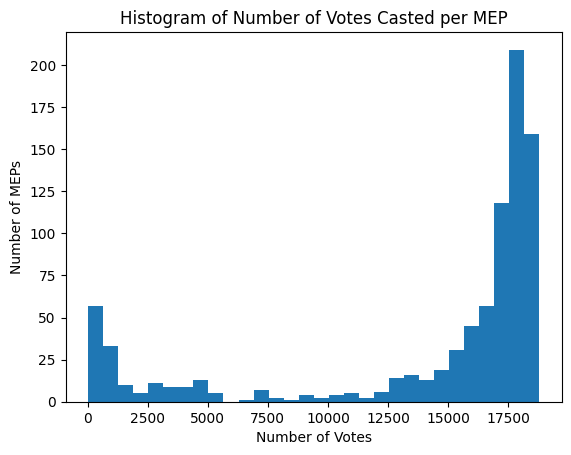

In [134]:
import matplotlib.pyplot as plt

votes = pd.DataFrame(listVotes, columns = ['mepid','voteid','weight']) 

nVotes = votes.groupby('mepid').count()['voteid']

ax = nVotes.plot.hist(
    bins=30,
    title="Histogram of Number of Votes Casted per MEP",
   
)
ax.set_xlabel("Number of Votes")
ax.set_ylabel("Number of MEPs")

In [221]:
def calculate_intra_group_cohesion(nodes, edges):
    import pandas as pd
    
    # Merge edges with nodes to get group information for Source
    edges_with_source_group = edges.merge(
        nodes[['Id', 'GroupID']], 
        left_on='Source', 
        right_on='Id', 
        how='inner'
    ).rename(columns={'GroupID': 'SourceGroup'})
    
    # Merge with nodes again to get group information for Target
    edges_with_groups = edges_with_source_group.merge(
        nodes[['Id', 'GroupID']], 
        left_on='Target', 
        right_on='Id', 
        how='inner'
    ).rename(columns={'GroupID': 'TargetGroup'})
    
    # Filter edges where Source and Target belong to the same group
    intra_group_edges = edges_with_groups[
        edges_with_groups['SourceGroup'] == edges_with_groups['TargetGroup']
    ]
    
    # Calculate average weight per group
    if len(intra_group_edges) == 0:
        return pd.DataFrame(columns=['GroupID', 'AverageWeight'])
    
    # Group by group and calculate average weight
    intra_group_scores = intra_group_edges.groupby('SourceGroup').agg({
        'Weight': 'mean'
    }).reset_index()
    
    # Rename columns
    intra_group_scores.columns = ['GroupID', 'AverageWeight']
    
    # Round average weight to 3 decimal places
    intra_group_scores['AverageWeight'] = intra_group_scores['AverageWeight'].round(2)
    
    # Sort by average weight in descending order
    intra_group_scores = intra_group_scores.sort_values('AverageWeight', ascending=False).reset_index(drop=True)
    
    return intra_group_scores

def calculate_inter_group_scores(nodes, edges):

    import pandas as pd
    
    # Merge edges with nodes to get group information for Source
    edges_with_source_group = edges.merge(
        nodes[['Id', 'GroupID']], 
        left_on='Source', 
        right_on='Id', 
        how='inner'
    ).rename(columns={'GroupID': 'SourceGroup'})
    
    # Merge with nodes again to get group information for Target
    edges_with_groups = edges_with_source_group.merge(
        nodes[['Id', 'GroupID']], 
        left_on='Target', 
        right_on='Id', 
        how='inner'
    ).rename(columns={'GroupID': 'TargetGroup'})
    
    # Filter edges where Source and Target belong to different groups
    inter_group_edges = edges_with_groups[
        edges_with_groups['SourceGroup'] != edges_with_groups['TargetGroup']
    ].copy()
    
    if len(inter_group_edges) == 0:
        return pd.DataFrame(columns=['Group1', 'Group2', 'AverageWeight'])
    
    # Create a normalized group pair (always put smaller group first to avoid duplicates)
    inter_group_edges['Group1'] = inter_group_edges.apply(
        lambda row: min(row['SourceGroup'], row['TargetGroup']), axis=1
    )
    inter_group_edges['Group2'] = inter_group_edges.apply(
        lambda row: max(row['SourceGroup'], row['TargetGroup']), axis=1
    )
    
    # Group by group pairs and calculate average weight
    inter_group_scores = inter_group_edges.groupby(['Group1', 'Group2']).agg({
        'Weight': 'mean'
    }).reset_index()
    
    # Rename columns
    inter_group_scores.columns = ['Group1', 'Group2', 'AverageWeight']
    
    # Round average weight to 3 decimal places
    inter_group_scores['AverageWeight'] = inter_group_scores['AverageWeight'].round(2)
    
    # Sort by average weight in descending order
    inter_group_scores = inter_group_scores.sort_values('AverageWeight', ascending=False).reset_index(drop=True)
    
    return inter_group_scores

def calculate_country_cohesion(nodes, edges):
    import pandas as pd
    
    # Merge edges with nodes to get country information for Source
    edges_with_source_country = edges.merge(
        nodes[['Id', 'Country']], 
        left_on='Source', 
        right_on='Id', 
        how='inner'
    ).rename(columns={'Country': 'SourceCountry'})
    
    # Merge with nodes again to get country information for Target
    edges_with_countries = edges_with_source_country.merge(
        nodes[['Id', 'Country']], 
        left_on='Target', 
        right_on='Id', 
        how='inner'
    ).rename(columns={'Country': 'TargetCountry'})
    
    # Filter edges where Source and Target belong to the same country
    intra_country_edges = edges_with_countries[
        edges_with_countries['SourceCountry'] == edges_with_countries['TargetCountry']
    ]
    
    # Calculate average weight per country
    if len(intra_country_edges) == 0:
        return pd.DataFrame(columns=['Country', 'AverageWeight'])
    
    # Group by country and calculate average weight
    country_scores = intra_country_edges.groupby('SourceCountry').agg({
        'Weight': 'mean'
    }).reset_index()
    
    # Rename columns
    country_scores.columns = ['Country', 'AverageWeight']
    
    # Round average weight to 3 decimal places
    country_scores['AverageWeight'] = country_scores['AverageWeight'].round(2)
    
    # Sort by average weight in descending order
    country_scores = country_scores.sort_values('AverageWeight', ascending=False).reset_index(drop=True)
    
    return country_scores


In [253]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

def get_group_order(groups):
    # Define canonical positions and their variations
    # Each canonical name maps to a list of possible variations
    group_mapping = {
        'GUE/NGL': ['GUE/NGL', 'The Left'],
        'Verts/ALE': ['Verts/ALE', 'Verts', 'ALE', 'Greens/EFA'],
        'S&D': ['S&D', 'PSE'],
        'ALDE': ['ALDE', 'RE'],
        'PPE': ['PPE', 'PPE-DE', 'EPP'],
        'UEN': ['UEN'],
        'ECR': ['ECR'],
        'EFDD': ['EFDD', 'EFD', 'IND/DEM'],
        'ENF': ['ENF', 'PfE', 'ID'],
        'ESN': ['ESN'],
        'NonAttached': ['NonAttached']
    }
    
    # Define order (from left to right, ending with NonAttached)
    canonical_order = ['GUE/NGL', 'Verts/ALE', 'S&D', 'ALDE', 'PPE', 'UEN', 'ECR', 'EFDD', 'ENF', 'ESN', 'NonAttached']
    
    # Convert groups to set for easier lookup
    groups_set = set(groups)
    
    # Map actual group names to their canonical position
    group_to_canonical = {}
    for canonical, variations in group_mapping.items():
        for var in variations:
            if var in groups_set:
                group_to_canonical[var] = canonical
    
    # Order groups according to canonical order, using actual group names
    ordered_groups = []
    for canonical in canonical_order:
        # Find all actual group names that map to this canonical position
        matching_groups = [g for g in groups_set if group_to_canonical.get(g) == canonical]
        if matching_groups:
            # If canonical name exists in data, use it; otherwise use first variation found
            if canonical in matching_groups:
                ordered_groups.append(canonical)
            else:
                # Use the first variation found (sorted for consistency)
                ordered_groups.append(sorted(matching_groups)[0])
    
    # Add any groups not in the mapping (shouldn't happen, but just in case)
    unmapped_groups = groups_set - set(group_to_canonical.keys())
    if unmapped_groups:
        # Insert before NonAttached
        if 'NonAttached' in ordered_groups:
            nonattached_idx = ordered_groups.index('NonAttached')
            ordered_groups = ordered_groups[:nonattached_idx] + sorted(unmapped_groups) + ordered_groups[nonattached_idx:]
        else:
            ordered_groups.extend(sorted(unmapped_groups))
    
    return ordered_groups

def get_group_color(group_name):
    """
    Get color for a group based on its canonical name.
    
    Parameters:
    - group_name: Group name (can be variation or canonical)
    
    Returns:
    - Color code (hex string)
    """
    # Map to canonical name first
    canonical = map_group_to_canonical(group_name)
    
    # Define colors for each canonical group
    group_colors = {
        'GUE/NGL': '#A2006D',      # Dark magenta
        'Verts/ALE': '#43B02A',     # Green
        'S&D': '#E3000F',           # Red
        'ALDE': '#FFD500',    
        'UEN': '#99FFFF',
        'PPE': '#0054A6',           # Blue
        'ECR': '#003876',           # Dark blue
        'EFDD': '#48e2ff',          # Cyan
        'ENF': '#000000',           # Black
        'ESN': '#684100',           # Brown
        'NonAttached': '#808080'    # Gray
    }

    return group_colors.get(canonical, '#CCCCCC')  # Default gray if not found

def get_group_display_name(group_name):
    """
    Get English display name for a group based on its canonical name.
    
    Parameters:
    - group_name: Group name (can be variation or canonical)
    
    Returns:
    - English display name
    """
    # Map to canonical name first
    canonical = map_group_to_canonical(group_name)
    
    # Define English display names for each canonical group
    display_names = {
        'GUE/NGL': 'The Left',
        'Verts/ALE': 'Greens/EFA',
        'S&D': 'S&D',
        'ALDE': 'RE',
        'PPE': 'EPP',
        'ECR': 'ECR',
        'EFDD': 'EFDD',
        'ENF': 'ID',
        'ESN': 'ESN',
        'NonAttached': 'Non-Attached'
    }
    
    return display_names.get(canonical, canonical)  # Default to canonical name if not found

def plot_group_cohesion_barchart(intra_cohesion, title="Group Cohesion Scores", figsize=(10, 6)):
    """
    Generate a bar chart of group cohesion scores with vertical bars.
    
    Parameters:
    - intra_cohesion: DataFrame with columns 'GroupID' and 'AverageWeight'
    - title: Title for the chart
    - figsize: Figure size tuple
    """
    if intra_cohesion.empty:
        print("No data to plot")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get ordered groups according to custom order
    group_order = get_group_order(intra_cohesion['GroupID'].unique())
    
    # Reorder data according to custom order
    data = intra_cohesion.set_index('GroupID').reindex(group_order).reset_index()
    data = data.dropna()  # Remove groups that don't exist in data
    
    # Get colors for each group
    colors = [get_group_color(group) for group in data['GroupID']]
    
    # Use actual group names from data (not canonical or display names)
    bars = ax.bar(data['GroupID'], data['AverageWeight'], color=colors)
    
    ax.set_xlabel('Group', fontsize=12)
    ax.set_ylabel('Average Cohesion Score', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Use actual group names from data
    ax.set_xticklabels(data['GroupID'], rotation=45, ha='right')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(data.iterrows()):
        height = row['AverageWeight']
        ax.text(i, height + 0.01 if height >= 0 else height - 0.01, f"{height:.2f}", 
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    return fig, ax

def plot_inter_group_heatmap(inter_scores, title="Inter-Group Cohesion Heatmap", figsize=(12, 10)):
    """
    Generate a triangular heatmap for inter-group cohesion scores.
    Color coded from green (positive) to red (negative).
    
    Parameters:
    - inter_scores: DataFrame with columns 'Group1', 'Group2', 'AverageWeight'
    - title: Title for the chart
    - figsize: Figure size tuple
    """
    if inter_scores.empty:
        print("No data to plot")
        return
    
    # Get all unique groups from data
    all_unique_groups = set(inter_scores['Group1'].unique()) | set(inter_scores['Group2'].unique())
    
    # Order groups according to custom order (handles variations in group names)
    all_groups = get_group_order(all_unique_groups)
    
    n_groups = len(all_groups)
    
    # Create a matrix filled with NaN
    matrix = np.full((n_groups, n_groups), np.nan)
    
    # Fill the matrix with inter-group scores
    for _, row in inter_scores.iterrows():
        i = all_groups.index(row['Group1'])
        j = all_groups.index(row['Group2'])
        matrix[i, j] = row['AverageWeight']
        # Also fill symmetric position
        matrix[j, i] = row['AverageWeight']
    
    # Create mask for upper triangle including diagonal (to show only lower triangle)
    # This masks the diagonal (groups don't score with themselves) and upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=0)
    
    # Find groups that have at least one visible value in the lower triangle
    # For rows: check if there's data in columns j < i (lower triangle)
    # For columns: check if there's data in rows i > j (lower triangle)
    # Since we're showing lower triangle, we need groups that have data below the diagonal
    has_data_in_lower_triangle = []
    for i in range(n_groups):
        # Check if row i has data in lower triangle (columns j < i)
        has_data_row = np.any(~np.isnan(matrix[i, :i]))
        # Check if column i has data in lower triangle (rows j > i)
        has_data_col = np.any(~np.isnan(matrix[i+1:, i])) if i < n_groups - 1 else False
        # Include group if it has data in lower triangle as either row or column
        has_data_in_lower_triangle.append(has_data_row or has_data_col)
    
    # Filter to only groups with visible data in lower triangle
    groups_with_data = [all_groups[i] for i in range(n_groups) if has_data_in_lower_triangle[i]]
    
    if len(groups_with_data) == 0:
        print("No data to display in heatmap")
        return
    
    # Recreate matrix with only groups that have data
    n_filtered = len(groups_with_data)
    matrix_filtered = np.full((n_filtered, n_filtered), np.nan)
    
    for _, row in inter_scores.iterrows():
        if row['Group1'] in groups_with_data and row['Group2'] in groups_with_data:
            i = groups_with_data.index(row['Group1'])
            j = groups_with_data.index(row['Group2'])
            matrix_filtered[i, j] = row['AverageWeight']
            # Also fill symmetric position
            matrix_filtered[j, i] = row['AverageWeight']
    
    # Update mask for filtered matrix
    mask = np.triu(np.ones_like(matrix_filtered, dtype=bool), k=0)
    all_groups = groups_with_data
    matrix = matrix_filtered
    
    # Create custom colormap: red (negative) to green (positive)
    # Center at 0, with red for negative values and green for positive
    # No blue - consistent color scheme across all charts
    colors = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#e6f598', '#abdda4', '#66c2a5', '#1a9850']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('red_green', colors, N=n_bins)
    
    # Determine vmin and vmax for symmetric colormap around 0
    valid_values = inter_scores['AverageWeight'].dropna()
    if len(valid_values) > 0:
        max_abs = max(abs(valid_values.min()), abs(valid_values.max()))
        vmin, vmax = -max_abs, max_abs
    else:
        vmin, vmax = -1, 1
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Use actual group names from data (not canonical or display names)
    
    # Create heatmap with mask for upper triangle
    sns.heatmap(matrix, 
                   mask=mask,
                   annot=True, 
                   fmt='.2f',
                   cmap=cmap,
                   center=0,
                   vmin=vmin,
                   vmax=vmax,
                   xticklabels=all_groups,
                   yticklabels=all_groups,
                   square=True,
                   cbar=False,
                   ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Group', fontsize=12)
    ax.set_ylabel('Group', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return fig, ax

def plot_country_cohesion_map(country_cohesion, title="Country Cohesion Scores", figsize=(14, 12)):
    """
    Plot country cohesion scores on a European choropleth map.
    Color coded from red (negative) to green (positive values).
    
    Parameters:
    - country_cohesion: DataFrame with columns 'Country' and 'AverageWeight'
    - title: Title for the map
    - figsize: Figure size tuple
    
    Returns:
    - fig, ax: matplotlib figure and axes objects
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
    
    if country_cohesion.empty:
        print("No data to plot")
        return
    
    # Load world map from Natural Earth (using direct URL instead of deprecated dataset)
    # Natural Earth 50m cultural vectors - countries (higher resolution than 110m)
    natural_earth_url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_50m_admin_0_countries.geojson"
    try:
        world = gpd.read_file(natural_earth_url)
    except Exception as e:
        # Fallback: try downloading from alternative source
        print(f"Error loading from URL: {e}")
        print("Trying alternative source...")
        # Alternative: use cartopy or download manually
        import urllib.request
        import tempfile
        import os
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.geojson')
        try:
            urllib.request.urlretrieve(natural_earth_url, temp_file.name)
            world = gpd.read_file(temp_file.name)
            os.unlink(temp_file.name)
        except Exception as e2:
            print(f"Error downloading data: {e2}")
            print("Please ensure you have internet connection or download Natural Earth data manually")
            return None
    
    # Create a mapping dictionary for country names that might differ
    country_name_mapping = {
        'Czechia': 'Czech Rep.',
        'Czech Republic': 'Czech Rep.',
        'United Kingdom': 'United Kingdom',
    }
    
    # Apply mapping to country_cohesion
    country_cohesion_mapped = country_cohesion.copy()
    country_cohesion_mapped['Country'] = country_cohesion_mapped['Country'].replace(country_name_mapping)
    
    # Determine the correct column name in the Natural Earth data
    # Natural Earth GeoJSON uses 'NAME' or 'NAME_LONG' instead of 'name'
    name_column = None
    for col in ['NAME', 'NAME_LONG', 'name', 'NAME_EN']:
        if col in world.columns:
            name_column = col
            break
    
    if name_column is None:
        print("Warning: Could not find country name column in Natural Earth data")
        print(f"Available columns: {world.columns.tolist()}")
        return None
    
    # Merge world data with cohesion scores
    merged = world.merge(
        country_cohesion_mapped, 
        left_on=name_column, 
        right_on='Country', 
        how='inner'  # Use inner join to only include countries in our data
    )
    
    # Filter to European countries only (exclude overseas territories and non-EU countries)
    # Use a stricter bounding box to exclude overseas territories
    # European mainland bounding box (excludes Azores, Madeira, French Guiana, etc.)
    # Longitude: -10 to 35 (excludes Azores at ~-28, Madeira at ~-17)
    # Latitude: 35 to 72 (excludes French Guiana at ~5)
    
    # First, filter by centroid to exclude overseas territories
    def is_in_europe_mainland(geom):
        """Check if geometry centroid is in European mainland (excludes overseas territories)"""
        centroid = geom.centroid
        # Stricter bounds for European mainland
        lon_ok = -10 <= centroid.x <= 35
        lat_ok = 35 <= centroid.y <= 72
        return lon_ok and lat_ok
    
    europe = merged[merged.geometry.apply(is_in_europe_mainland)].copy()
    
    # Additional filter: exclude specific non-EU countries that might be in the bounding box
    non_eu_countries = ['Syria', 'Turkey', 'Russia', 'Ukraine', 'Belarus', 'Moldova', 
                        'Albania', 'Bosnia and Herzegovina', 'Serbia', 'Montenegro', 
                        'North Macedonia', 'Kosovo', 'Iceland', 'Norway', 'Switzerland']
    
    # Filter out non-EU countries if they appear in the name column
    if name_column in europe.columns:
        europe = europe[~europe[name_column].isin(non_eu_countries)]
    
    # Additional check: ensure we only have countries with data (from country_cohesion)
    europe = europe[europe['AverageWeight'].notna()]
    
    # Clip geometries to European bounding box to remove any overseas territories
    # This ensures we only show the European mainland part of each country
    from shapely.geometry import box
    europe_bbox = box(-10, 35, 35, 72)  # minx, miny, maxx, maxy
    europe['geometry'] = europe.geometry.intersection(europe_bbox)
    
    # Remove any geometries that became empty after clipping
    europe = europe[~europe.geometry.is_empty]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create custom colormap: red (negative) to green (positive)
    # Using a diverging colormap centered at 0
    # No blue - consistent color scheme across all charts
    colors_list = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', 
                   '#e6f598', '#abdda4', '#66c2a5', '#1a9850']
    cmap = LinearSegmentedColormap.from_list('red_green', colors_list, N=256)
    
    # Determine vmin and vmax for symmetric colormap around 0
    valid_values = country_cohesion['AverageWeight'].dropna()
    if len(valid_values) > 0:
        max_abs = max(abs(valid_values.min()), abs(valid_values.max()))
        vmin, vmax = -max_abs, max_abs
    else:
        vmin, vmax = -1, 1
    
    # Create normalizer that centers at 0
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    # Plot countries with data
    europe.plot(
        column='AverageWeight',
        cmap=cmap,
        norm=norm,
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend=False,
        missing_kwds={'color': 'lightgray', 'label': 'No data'}
    )
    
    # Add country labels
    for idx, row in europe.iterrows():
        if pd.notna(row['AverageWeight']):
            # Get centroid for label placement
            centroid = row.geometry.centroid
            ax.text(
                centroid.x, centroid.y, 
                f"{row['AverageWeight']:.2f}",
                fontsize=8, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
            )
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    return fig, ax

def plot_country_cohesion_plotly(country_cohesion, title="Country Cohesion Scores"):
    """
    Plot country cohesion scores on a European choropleth map using Plotly.
    Color coded from green (positive) to red (negative values).
    
    Parameters:
    - country_cohesion: DataFrame with columns 'Country' and 'AverageWeight'
    - title: Title for the map
    
    Returns:
    - fig: plotly figure object
    """
    import plotly.express as px
    import plotly.graph_objects as go
    import pandas as pd
    import numpy as np
    
    if country_cohesion.empty:
        print("No data to plot")
        return None
    
    # Create a copy to avoid modifying the original
    df = country_cohesion.copy()
    
    # Map country names to ISO-3 codes for plotly
    # Plotly uses ISO-3 codes for country identification
    country_to_iso3 = {
        'Austria': 'AUT',
        'Belgium': 'BEL',
        'Bulgaria': 'BGR',
        'Croatia': 'HRV',
        'Cyprus': 'CYP',
        'Czechia': 'CZE',
        'Czech Republic': 'CZE',
        'Denmark': 'DNK',
        'Estonia': 'EST',
        'Finland': 'FIN',
        'France': 'FRA',
        'Germany': 'DEU',
        'Greece': 'GRC',
        'Hungary': 'HUN',
        'Ireland': 'IRL',
        'Italy': 'ITA',
        'Latvia': 'LVA',
        'Lithuania': 'LTU',
        'Luxembourg': 'LUX',
        'Malta': 'MLT',
        'Netherlands': 'NLD',
        'Poland': 'POL',
        'Portugal': 'PRT',
        'Romania': 'ROU',
        'Slovakia': 'SVK',
        'Slovenia': 'SVN',
        'Spain': 'ESP',
        'Sweden': 'SWE',
        'United Kingdom': 'GBR'
    }
    
    # Add ISO-3 codes to dataframe
    df['ISO3'] = df['Country'].map(country_to_iso3)
    
    # Remove rows where ISO-3 code is not found
    df = df.dropna(subset=['ISO3'])
    
    if df.empty:
        print("No valid country codes found")
        return None
    
    # Determine symmetric color scale range centered at 0
    valid_values = df['AverageWeight'].dropna()
    if len(valid_values) > 0:
        max_abs = max(abs(valid_values.min()), abs(valid_values.max()))
        color_min, color_max = -max_abs, max_abs
    else:
        color_min, color_max = -1, 1
    
    # Create custom color scale: red (negative) to green (positive)
    # No blue - consistent color scheme across all charts
    # Using the same color scheme as other charts: red -> orange -> yellow -> green
    colorscale = [
        [0, 'rgb(215, 48, 39)'],      # #d73027 - Red for negative values
        [0.125, 'rgb(244, 109, 67)'], # #f46d43 - Red-orange
        [0.25, 'rgb(253, 174, 97)'],  # #fdae61 - Orange
        [0.375, 'rgb(254, 224, 139)'], # #fee08b - Yellow-orange
        [0.5, 'rgb(255, 255, 191)'],  # #ffffbf - Light yellow (center/zero)
        [0.625, 'rgb(230, 245, 152)'], # #e6f598 - Light green
        [0.75, 'rgb(171, 221, 164)'], # #abdda4 - Green
        [0.875, 'rgb(102, 194, 165)'], # #66c2a5 - Dark green
        [1, 'rgb(26, 152, 80)']        # #1a9850 - Darker green for positive values
    ]
    
    # Create the choropleth map
    fig = go.Figure(data=go.Choropleth(
        locations=df['ISO3'],
        z=df['AverageWeight'],
        colorscale=colorscale,
        autocolorscale=False,
        reversescale=False,
        marker_line_color='white',
        marker_line_width=0.5,
        colorbar=dict(
            title="Cohesion Score",
            titleside="right",
            tickmode="linear",
            tick0=color_min,
            dtick=(color_max - color_min) / 5
        ),
        zmin=color_min,
        zmax=color_max,
        showscale=True
    ))
    
    # Update layout for Europe focus
    fig.update_geos(
        projection_type="natural earth",
        visible=True,
        resolution=50,
        scope="europe",
        showcountries=True,
        countrycolor="white",
        showcoastlines=True,
        coastlinecolor="white",
        showland=False,
        showocean=False,
        bgcolor="rgba(0,0,0,0)"
    )
    
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor='center',
            font=dict(size=20, color='black')
        ),
        geo=dict(
            lonaxis_range=[-15, 40],
            lataxis_range=[35, 72],
            projection_scale=1.2
        ),
        height=700,
        margin=dict(l=0, r=0, t=50, b=0),
        # Disable all interactions
        dragmode=False,
        hovermode=False,
        clickmode='none'
    )
    
    # Disable interactions on the geo subplot
    fig.update_layout(
        xaxis=dict(fixedrange=True),
        yaxis=dict(fixedrange=True)
    )
    
    return fig

def generate_all_mandate_charts(mandates=['6', '7', '8', '9', '10'], save_figures=False, output_dir='charts'):
    """
    Generate all charts (bar chart, heatmap, map) for all specified mandates.
    
    Parameters:
    - mandates: List of mandate numbers to process (default: ['6', '7', '8', '9', '10'])
    - save_figures: If True, save figures to files. If False, display them.
    - output_dir: Directory to save figures (only used if save_figures=True)
    
    Returns:
    - Dictionary mapping mandate numbers to their chart figures
    """
    import os
    import pandas as pd
    
    if save_figures:
        os.makedirs(output_dir, exist_ok=True)
    
    all_charts = {}
    
    for mandate in mandates:
        print(f"\nProcessing Mandate {mandate}...")
        
        try:
            # Load nodes and edges for this mandate
            nodes_path = f'mandate_{mandate}/nodes.csv'
            edges_path = f'mandate_{mandate}/edges_all.csv'
            
            if not os.path.exists(nodes_path) or not os.path.exists(edges_path):
                print(f"  Warning: Missing data files for mandate {mandate}, skipping...")
                continue
            
            nodes = pd.read_csv(nodes_path)
            edges = pd.read_csv(edges_path)
            
            # Calculate cohesion scores
            intra_cohesion = calculate_intra_group_cohesion(nodes, edges)
            inter_scores = calculate_inter_group_scores(nodes, edges)
            country_cohesion = calculate_country_cohesion(nodes, edges)
            
            # Generate charts
            charts = {}
            
            # 1. Bar chart of group cohesion scores
            print(f"  Generating bar chart...")
            fig_bar, ax_bar = plot_group_cohesion_barchart(
                intra_cohesion, 
                title=f"Group Cohesion Scores - Mandate {mandate}"
            )
            charts['bar'] = (fig_bar, ax_bar)
            
            if save_figures:
                fig_bar.savefig(f'{output_dir}/mandate_{mandate}_group_cohesion_barchart.png', 
                              dpi=300, bbox_inches='tight')
                plt.close(fig_bar)
            
            # 2. Heatmap of inter-group cohesion scores
            print(f"  Generating heatmap...")
            fig_heatmap, ax_heatmap = plot_inter_group_heatmap(
                inter_scores, 
                title=f"Inter-Group Cohesion Heatmap - Mandate {mandate}"
            )
            charts['heatmap'] = (fig_heatmap, ax_heatmap)
            
            if save_figures:
                fig_heatmap.savefig(f'{output_dir}/mandate_{mandate}_inter_group_heatmap.png', 
                                  dpi=300, bbox_inches='tight')
                plt.close(fig_heatmap)
            
            # 3. Map with country cohesion scores
            print(f"  Generating country map...")
            fig_map, ax_map = plot_country_cohesion_map(
                country_cohesion, 
                title=f"Country Cohesion Scores - Mandate {mandate}"
            )
            charts['map'] = (fig_map, ax_map)
            
            if save_figures:
                fig_map.savefig(f'{output_dir}/mandate_{mandate}_country_cohesion_map.png', 
                              dpi=300, bbox_inches='tight')
                plt.close(fig_map)
            
            all_charts[mandate] = charts
            print(f"  ✓ Completed Mandate {mandate}")
            
        except Exception as e:
            print(f"  ✗ Error processing mandate {mandate}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Generate evolution plots (requires data from all mandates)
    print(f"\nGenerating evolution plots...")
    try:
        # 4. Country cohesion evolution
        print(f"  Generating country cohesion evolution...")
        fig_country_evol, ax_country_evol = plot_country_cohesion_evolution(mandates=mandates)
        if fig_country_evol is not None:
            all_charts['country_evolution'] = (fig_country_evol, ax_country_evol)
            if save_figures:
                fig_country_evol.savefig(f'{output_dir}/country_cohesion_evolution.png', 
                                        dpi=300, bbox_inches='tight')
                plt.close(fig_country_evol)
        
        # 5. Group cohesion evolution
        print(f"  Generating group cohesion evolution...")
        fig_group_evol, ax_group_evol = plot_group_cohesion_evolution(mandates=mandates)
        if fig_group_evol is not None:
            all_charts['group_evolution'] = (fig_group_evol, ax_group_evol)
            if save_figures:
                fig_group_evol.savefig(f'{output_dir}/group_cohesion_evolution.png', 
                                      dpi=300, bbox_inches='tight')
                plt.close(fig_group_evol)
        
        print(f"  ✓ Completed evolution plots")
    except Exception as e:
        print(f"  ✗ Error generating evolution plots: {e}")
        import traceback
        traceback.print_exc()
    
    print(f"\n✓ Completed processing {len([k for k in all_charts.keys() if k not in ['country_evolution', 'group_evolution']])} mandates")
    return all_charts

def collect_cohesion_data(mandates=['6', '7', '8', '9', '10']):
    """
    Collect cohesion data for all mandates.
    
    Parameters:
    - mandates: List of mandate numbers to process
    
    Returns:
    - Dictionary with 'country' and 'group' keys, each containing DataFrames with evolution data
    """
    import os
    import pandas as pd
    
    country_data = []
    group_data = []
    
    # Map mandate numbers to election years
    mandate_years = {
        '6': 2004,  # 2004-2009
        '7': 2009,  # 2009-2014
        '8': 2014,  # 2014-2019
        '9': 2019,  # 2019-2024
        '10': 2024  # 2024-2029
    }
    
    for mandate in mandates:
        try:
            nodes_path = f'mandate_{mandate}/nodes.csv'
            edges_path = f'mandate_{mandate}/edges_all.csv'
            
            if not os.path.exists(nodes_path) or not os.path.exists(edges_path):
                print(f"Warning: Missing data files for mandate {mandate}, skipping...")
                continue
            
            nodes = pd.read_csv(nodes_path)
            edges = pd.read_csv(edges_path)
            
            # Calculate cohesion scores
            country_cohesion = calculate_country_cohesion(nodes, edges)
            group_cohesion = calculate_intra_group_cohesion(nodes, edges)
            
            # Add mandate and year information
            year = mandate_years.get(mandate, float(mandate) * 5 + 2000)
            
            # Add to country data
            country_cohesion['Mandate'] = mandate
            country_cohesion['Year'] = year
            country_data.append(country_cohesion)
            
            # Add to group data
            group_cohesion['Mandate'] = mandate
            group_cohesion['Year'] = year
            group_data.append(group_cohesion)
            
        except Exception as e:
            print(f"Error processing mandate {mandate}: {e}")
            continue
    
    # Combine all data
    country_evolution = pd.concat(country_data, ignore_index=True) if country_data else pd.DataFrame()
    group_evolution = pd.concat(group_data, ignore_index=True) if group_data else pd.DataFrame()
    
    return {'country': country_evolution, 'group': group_evolution}

def plot_country_cohesion_evolution(mandates=['6', '7', '8', '9', '10'], figsize=(14, 8)):
    """
    Plot evolution of country cohesion over time across mandates.
    
    Parameters:
    - mandates: List of mandate numbers to process
    - figsize: Figure size tuple
    
    Returns:
    - fig, ax: matplotlib figure and axes objects
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Collect data
    data = collect_cohesion_data(mandates)
    country_evolution = data['country']
    
    if country_evolution.empty:
        print("No country cohesion data to plot")
        return None, None
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get all countries
    all_countries = sorted(country_evolution['Country'].unique())
    
    # Plot each country's evolution
    for country in all_countries:
        country_data = country_evolution[country_evolution['Country'] == country].sort_values('Year')
        ax.plot(country_data['Year'], country_data['AverageWeight'], 
               marker='o', label=country, linewidth=2, markersize=6)
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Average Cohesion Score', fontsize=12)
    ax.set_title('Evolution of Country Cohesion Over Time', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Set x-axis to show only election years
    election_years = [2004, 2009, 2014, 2019, 2024]
    ax.set_xticks(election_years)
    ax.set_xticklabels(election_years)
    
    plt.tight_layout()
    return fig, ax

def map_group_to_canonical(group_name):
    """
    Map a group name to its canonical name.
    
    Parameters:
    - group_name: Group name to map
    
    Returns:
    - Canonical group name
    """
    # Define canonical groups and their variations
    group_mapping = {
        'GUE/NGL': ['GUE/NGL', 'The Left'],
        'Verts/ALE': ['Verts/ALE', 'Verts', 'ALE', 'Greens/EFA'],
        'S&D': ['S&D', 'PSE'],
        'ALDE': ['ALDE', 'RE'],  # Renew Europe (RE) is successor to ALDE
        'PPE': ['PPE', 'PPE-DE', 'EPP'],
        'UEN': ['UEN'],
        'ECR': ['ECR'],
        'EFDD': ['EFDD', 'EFD', 'IND/DEM'],
        'ENF': ['ENF', 'PfE', 'ID'],
        'ESN': ['ESN'],
        'NonAttached': ['NonAttached']
    }
    
    # Find canonical name for this group
    for canonical, variations in group_mapping.items():
        if group_name in variations:
            return canonical
    
    # If not found, return original name
    return group_name

def plot_group_cohesion_evolution(mandates=['6', '7', '8', '9', '10'], figsize=(14, 8)):
    """
    Plot evolution of group cohesion over time across mandates.
    Combines data from group name variations into canonical groups.
    
    Parameters:
    - mandates: List of mandate numbers to process
    - figsize: Figure size tuple
    
    Returns:
    - fig, ax: matplotlib figure and axes objects
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Collect data
    data = collect_cohesion_data(mandates)
    group_evolution = data['group']
    
    if group_evolution.empty:
        print("No group cohesion data to plot")
        return None, None
    
    # Map groups to canonical names
    group_evolution = group_evolution.copy()
    group_evolution['CanonicalGroup'] = group_evolution['GroupID'].apply(map_group_to_canonical)
    
    # Get canonical groups and order them
    canonical_groups = set(group_evolution['CanonicalGroup'].unique())
    # Filter out NonAttached
    canonical_groups = canonical_groups - {'NonAttached'}
    ordered_canonical_groups = get_group_order(canonical_groups)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each canonical group's evolution (combining all variations)
    for canonical_group in ordered_canonical_groups:
        if canonical_group in canonical_groups and canonical_group != 'NonAttached':
            # Get all data for this canonical group (from all variations)
            canonical_data = group_evolution[group_evolution['CanonicalGroup'] == canonical_group].sort_values('Year')
            if not canonical_data.empty:
                # Get the most recent name for this canonical group (from the most recent mandate)
                most_recent_data = canonical_data.iloc[-1]  # Last row (most recent year)
                most_recent_name = most_recent_data['GroupID']  # Actual group name from most recent mandate
                
                # Get color for this canonical group
                group_color = get_group_color(canonical_group)
                ax.plot(canonical_data['Year'], canonical_data['AverageWeight'], 
                       marker='o', label=most_recent_name, linewidth=2, markersize=6, color=group_color)
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Average Cohesion Score', fontsize=12)
    ax.set_title('Evolution of Group Cohesion Over Time', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Set x-axis to show only election years
    election_years = [2004, 2009, 2014, 2019, 2024]
    ax.set_xticks(election_years)
    ax.set_xticklabels(election_years)
    
    plt.tight_layout()
    return fig, ax




Processing Mandate 6...
  Generating bar chart...
  Generating heatmap...
  Generating country map...


/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_23063/2790513073.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['GroupID'], rotation=45, ha='right')


  ✓ Completed Mandate 6

Processing Mandate 7...
  Generating bar chart...
  Generating heatmap...
  Generating country map...


/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_23063/2790513073.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['GroupID'], rotation=45, ha='right')


  ✓ Completed Mandate 7

Processing Mandate 8...
  Generating bar chart...
  Generating heatmap...
  Generating country map...


/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_23063/2790513073.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['GroupID'], rotation=45, ha='right')


  ✓ Completed Mandate 8

Processing Mandate 9...
  Generating bar chart...
  Generating heatmap...
  Generating country map...


/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_23063/2790513073.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['GroupID'], rotation=45, ha='right')


  ✓ Completed Mandate 9

Processing Mandate 10...
  Generating bar chart...
  Generating heatmap...
  Generating country map...


/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_23063/2790513073.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['GroupID'], rotation=45, ha='right')


  ✓ Completed Mandate 10

Generating evolution plots...
  Generating country cohesion evolution...
  Generating group cohesion evolution...
  ✓ Completed evolution plots

✓ Completed processing 5 mandates


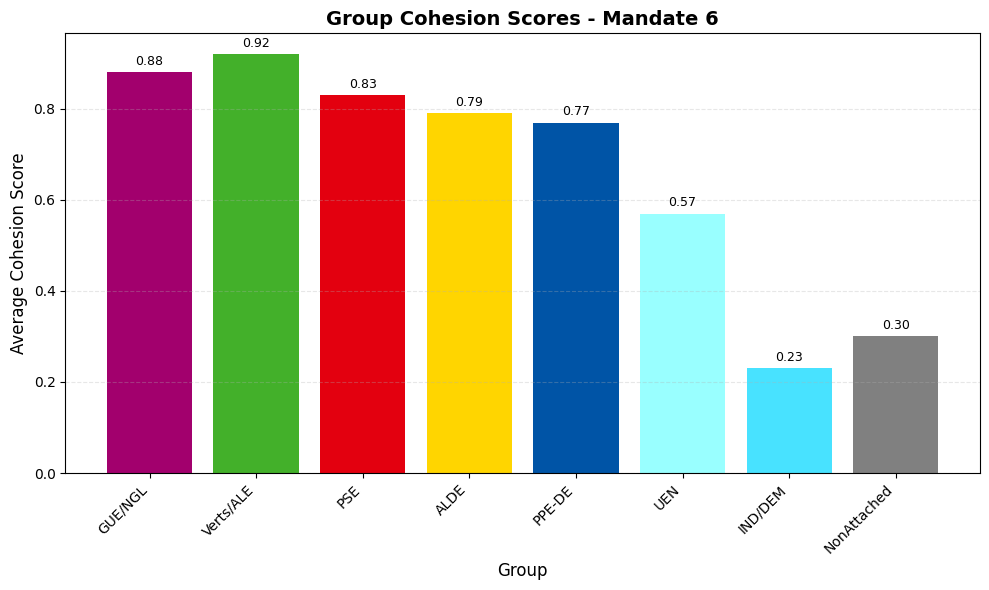

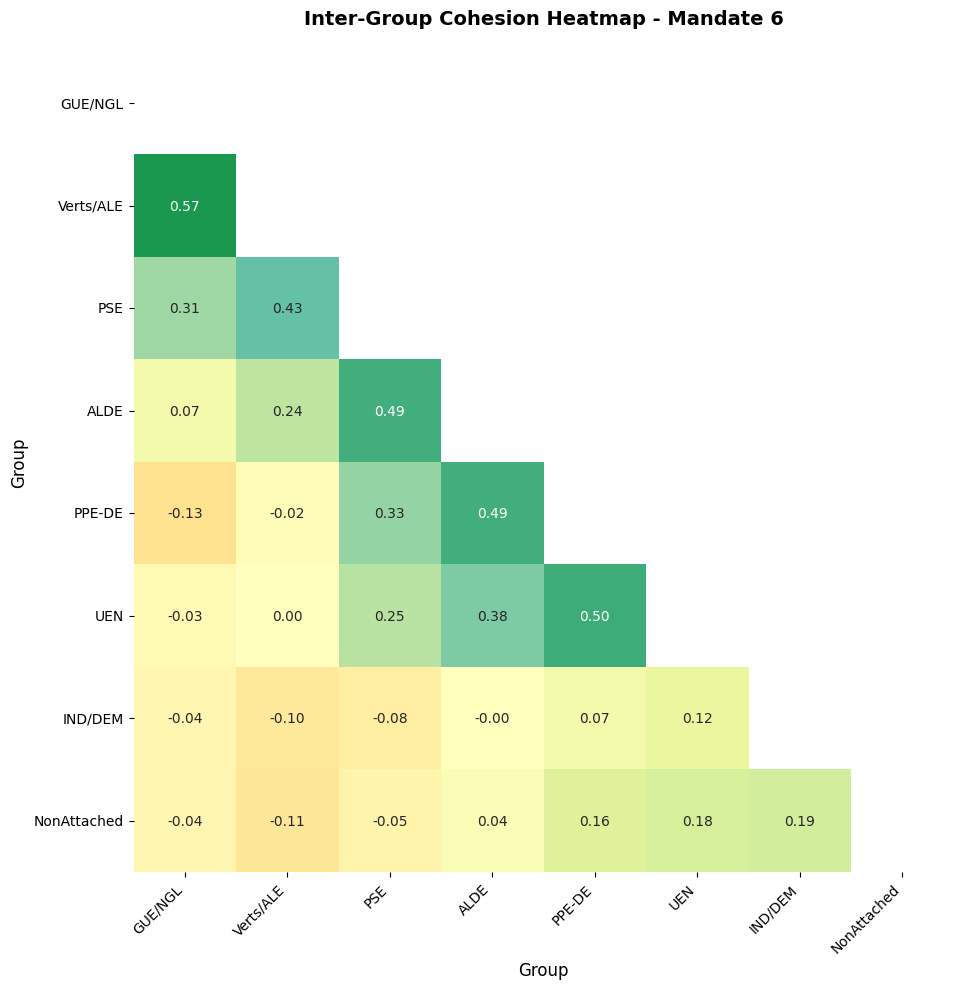

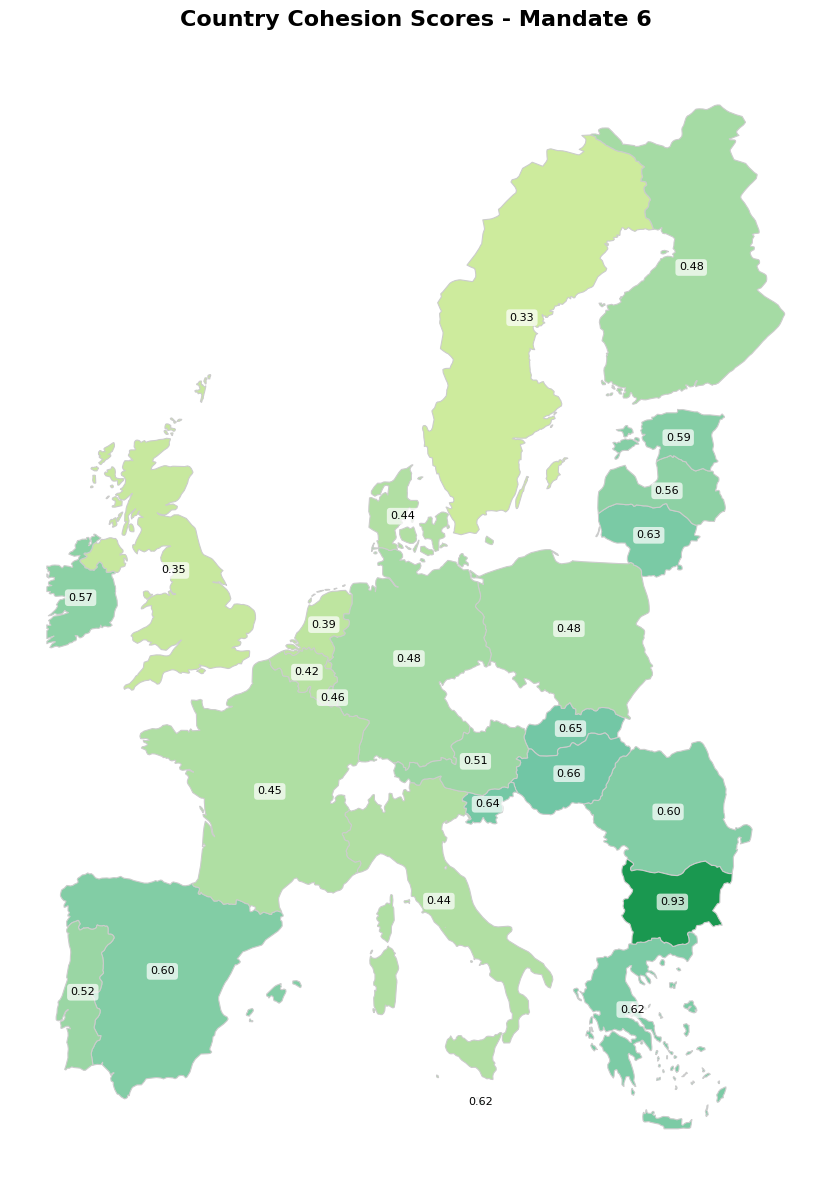

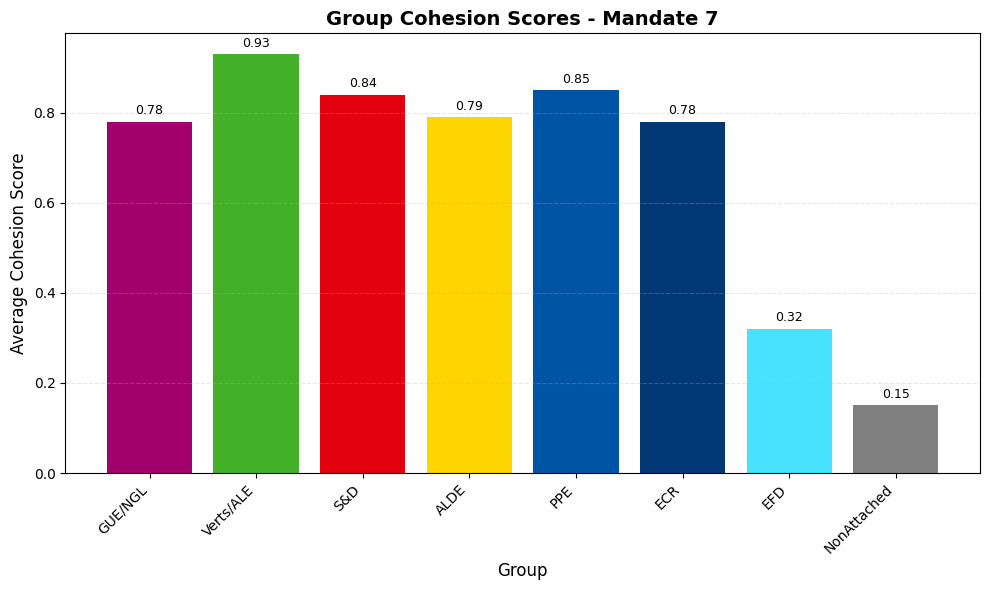

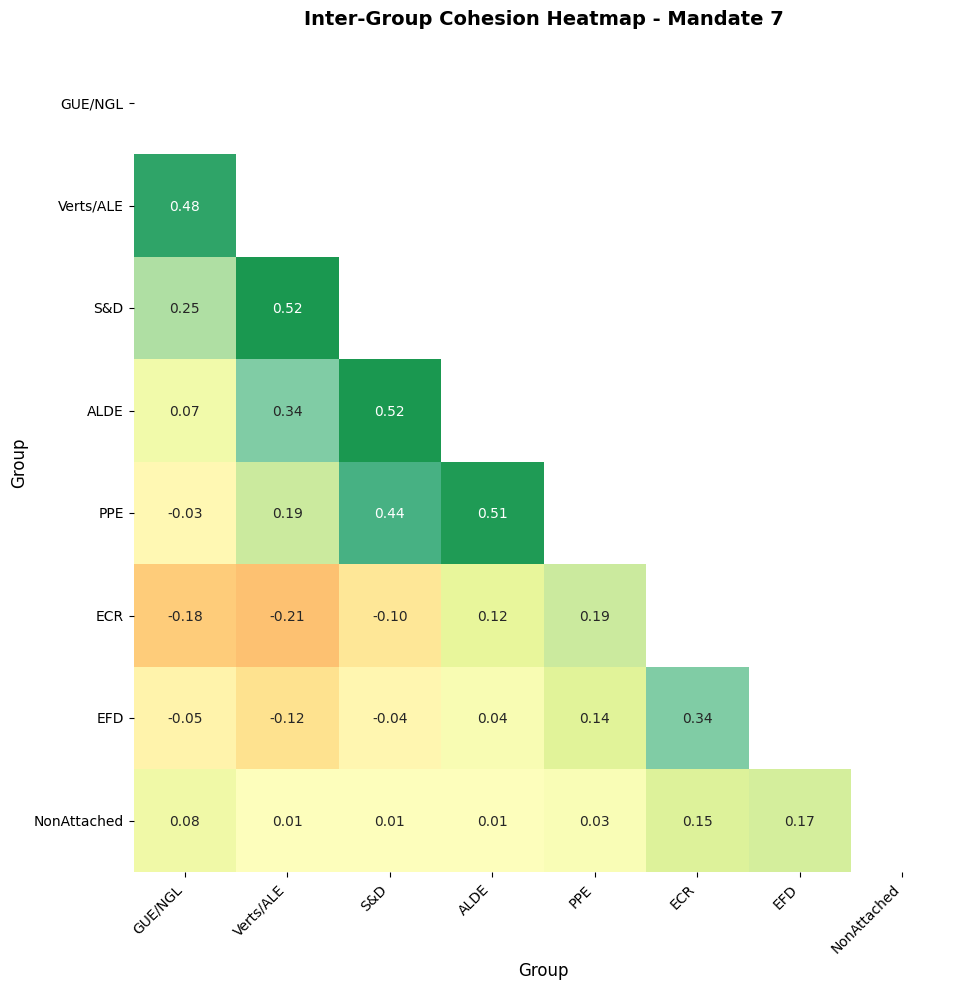

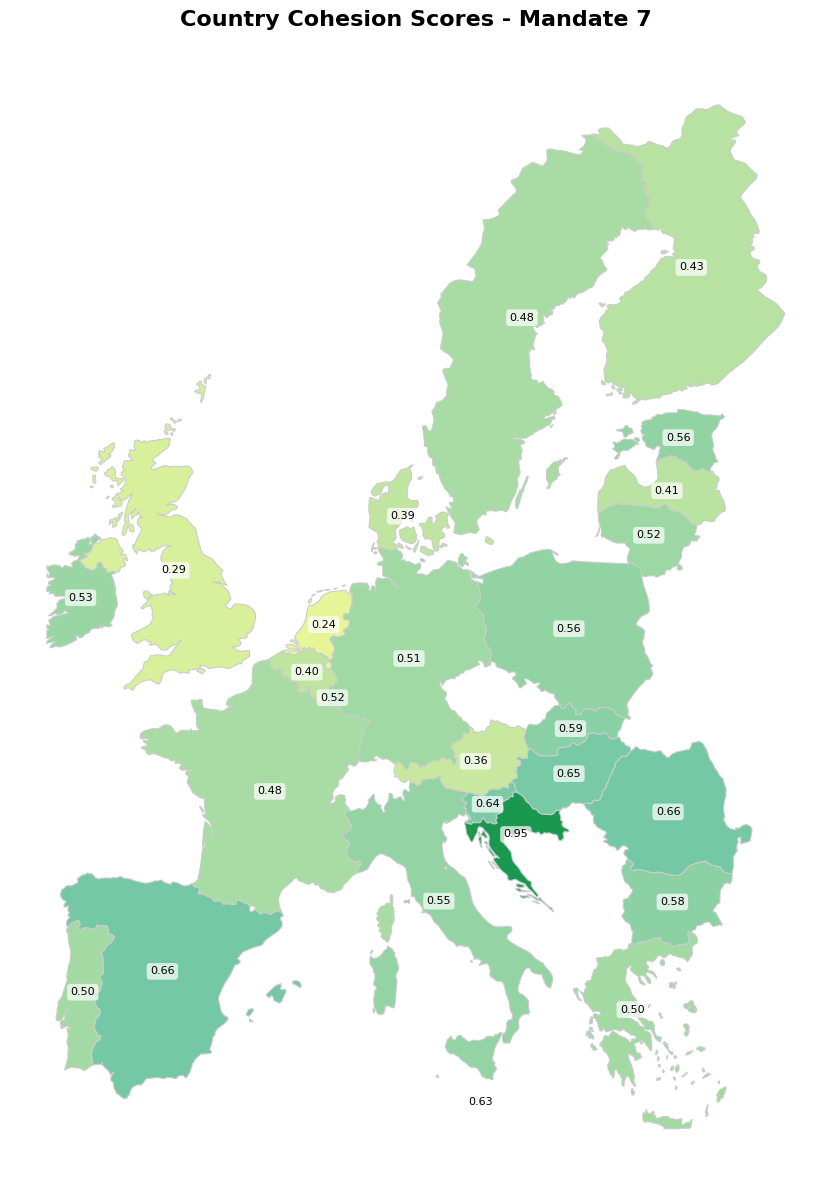

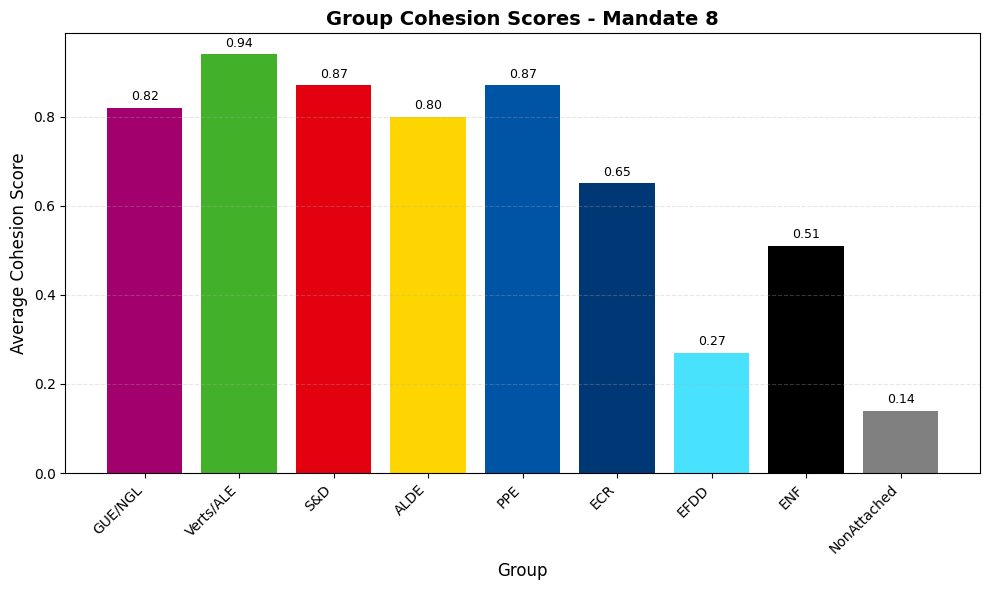

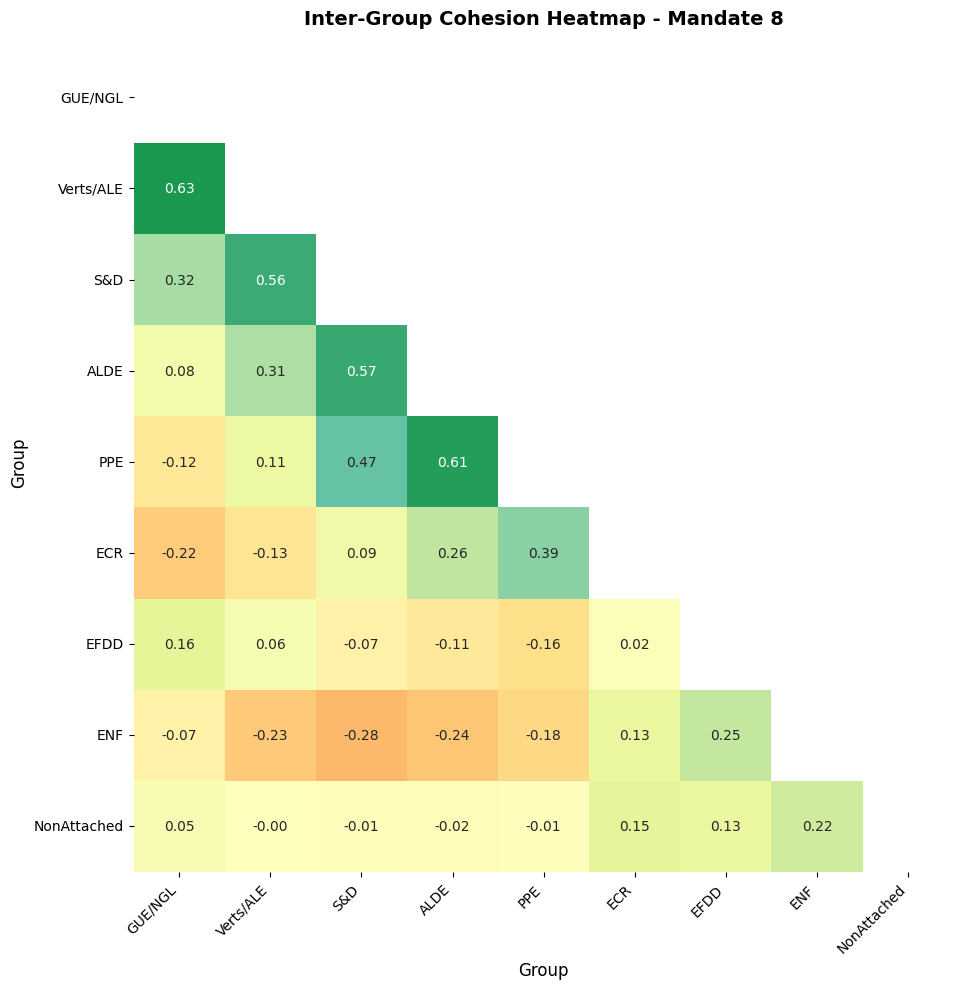

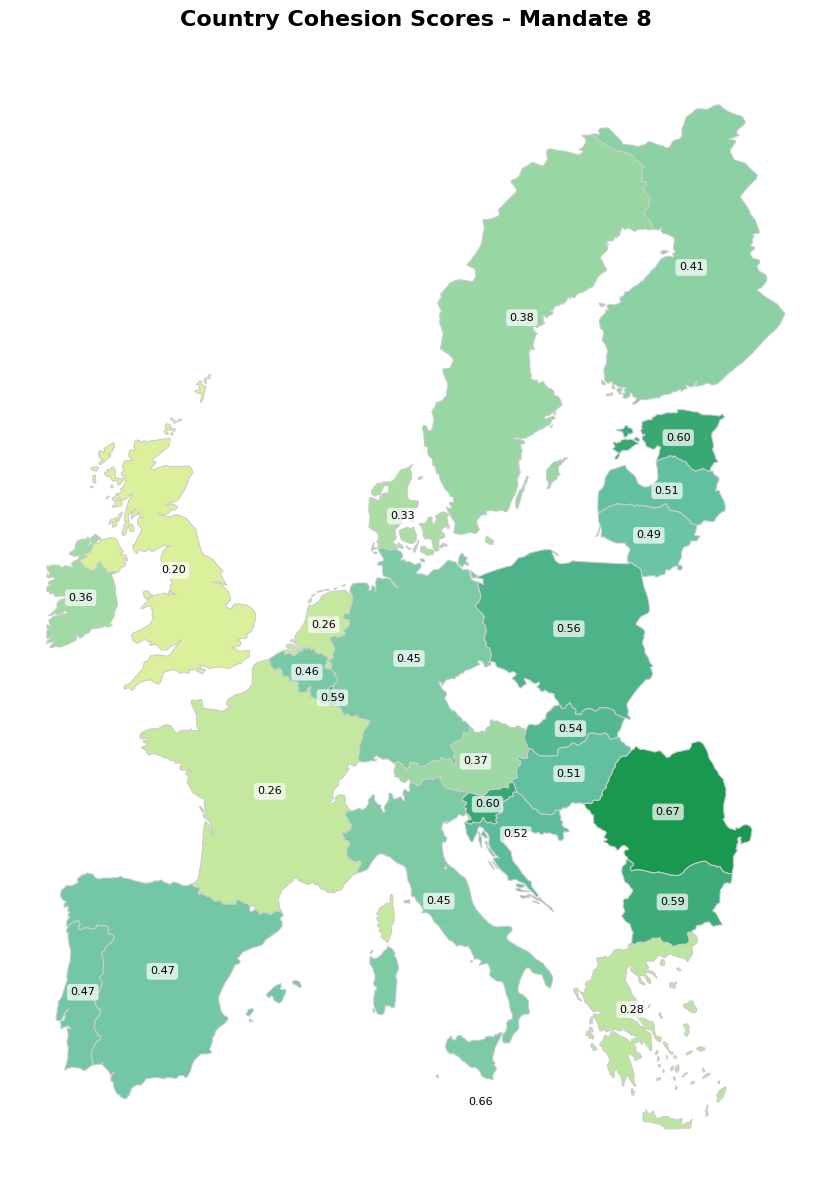

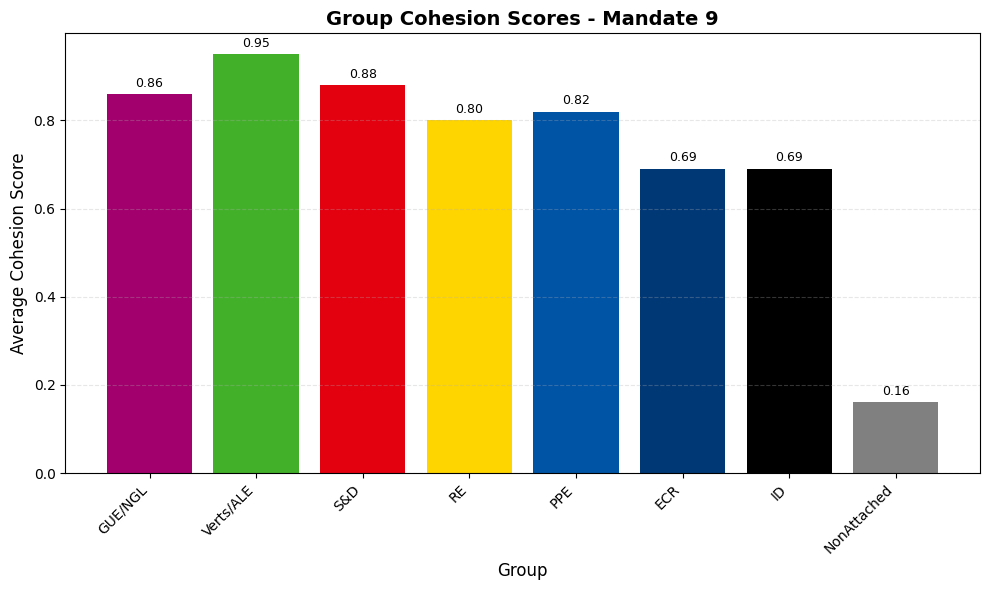

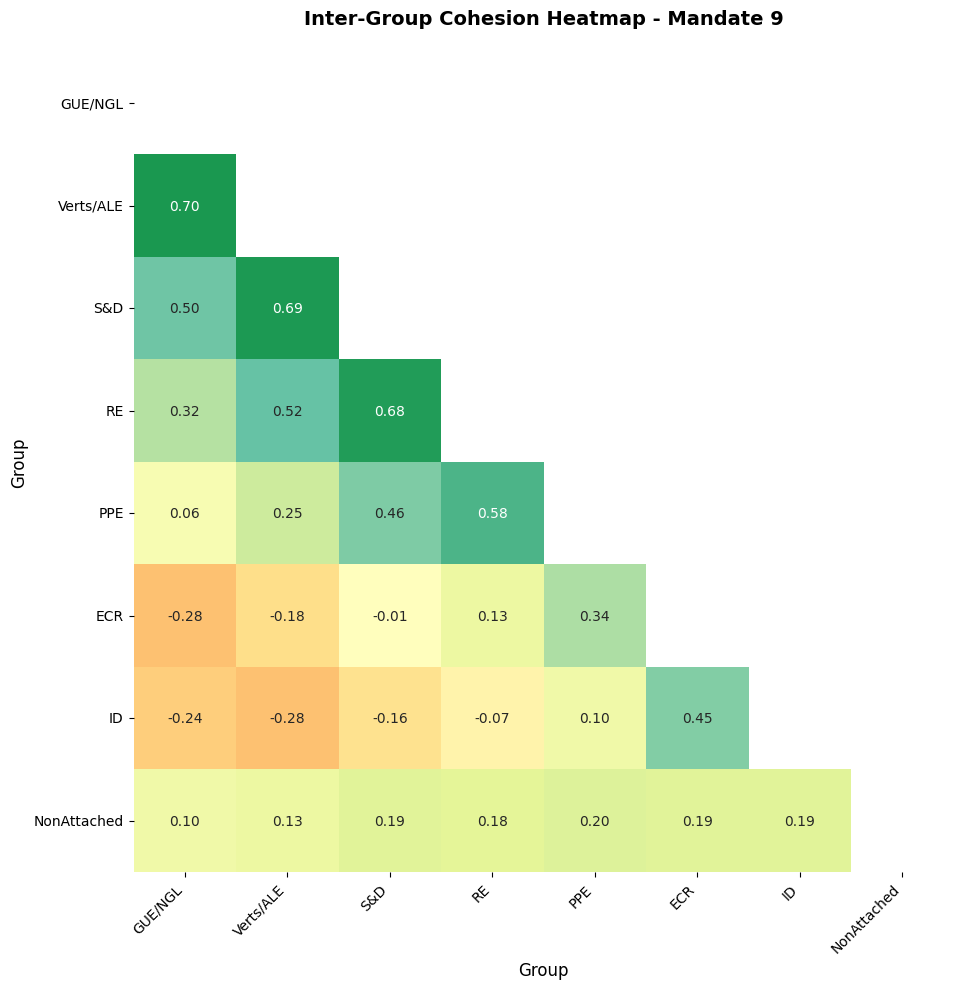

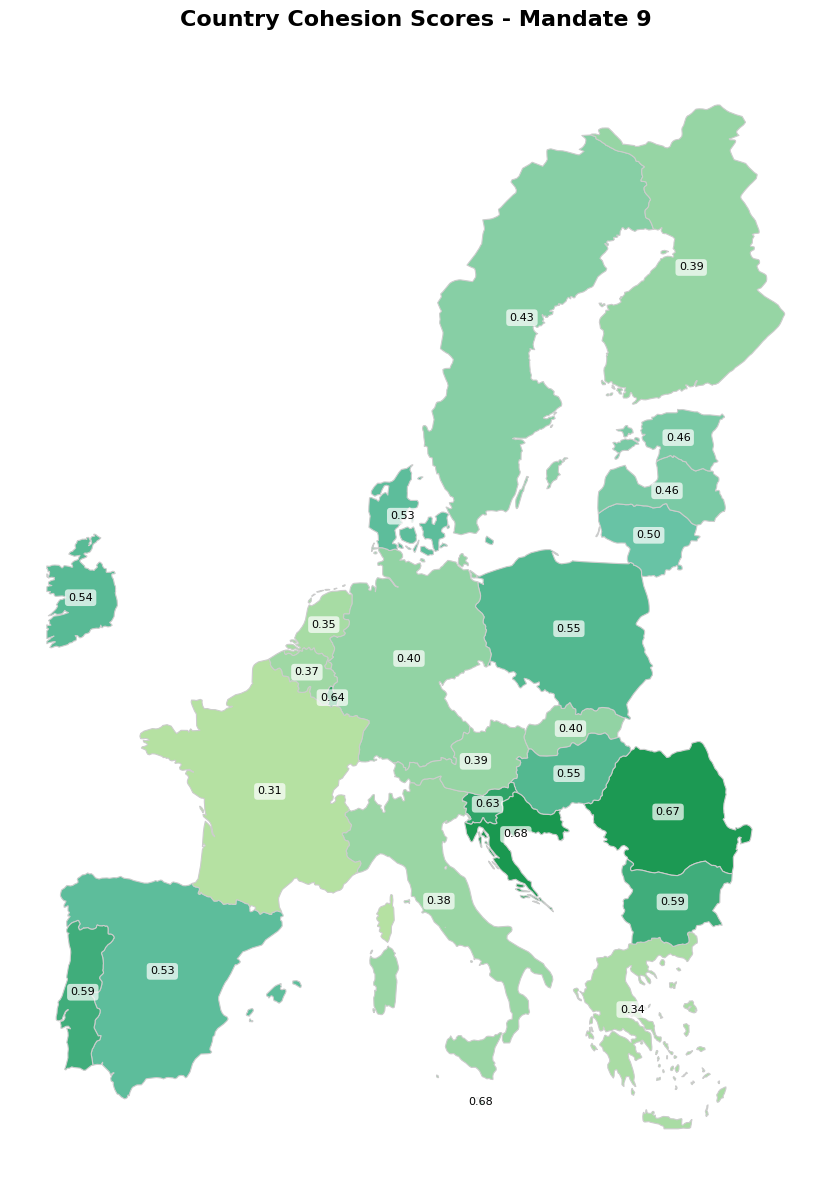

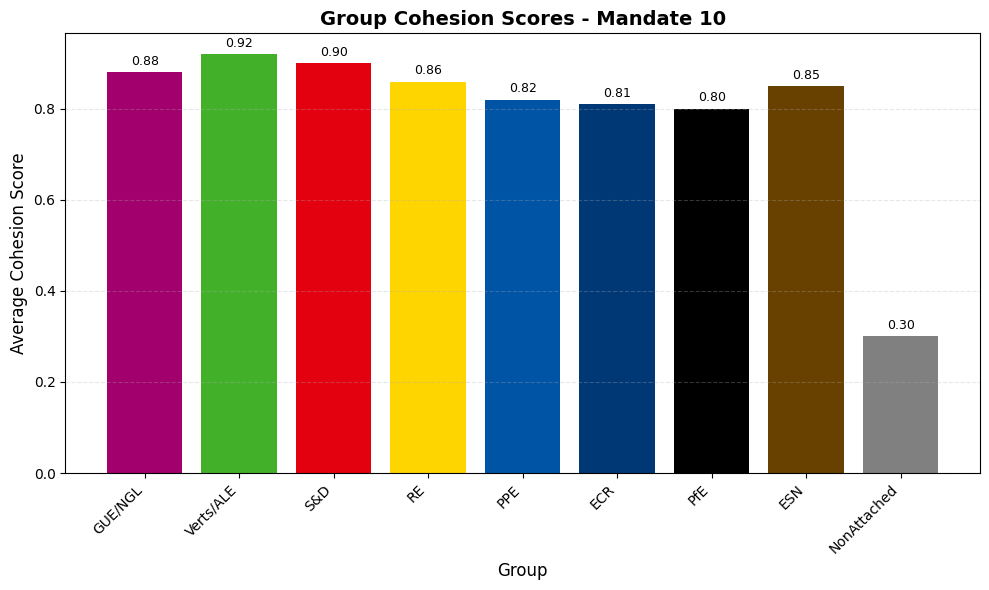

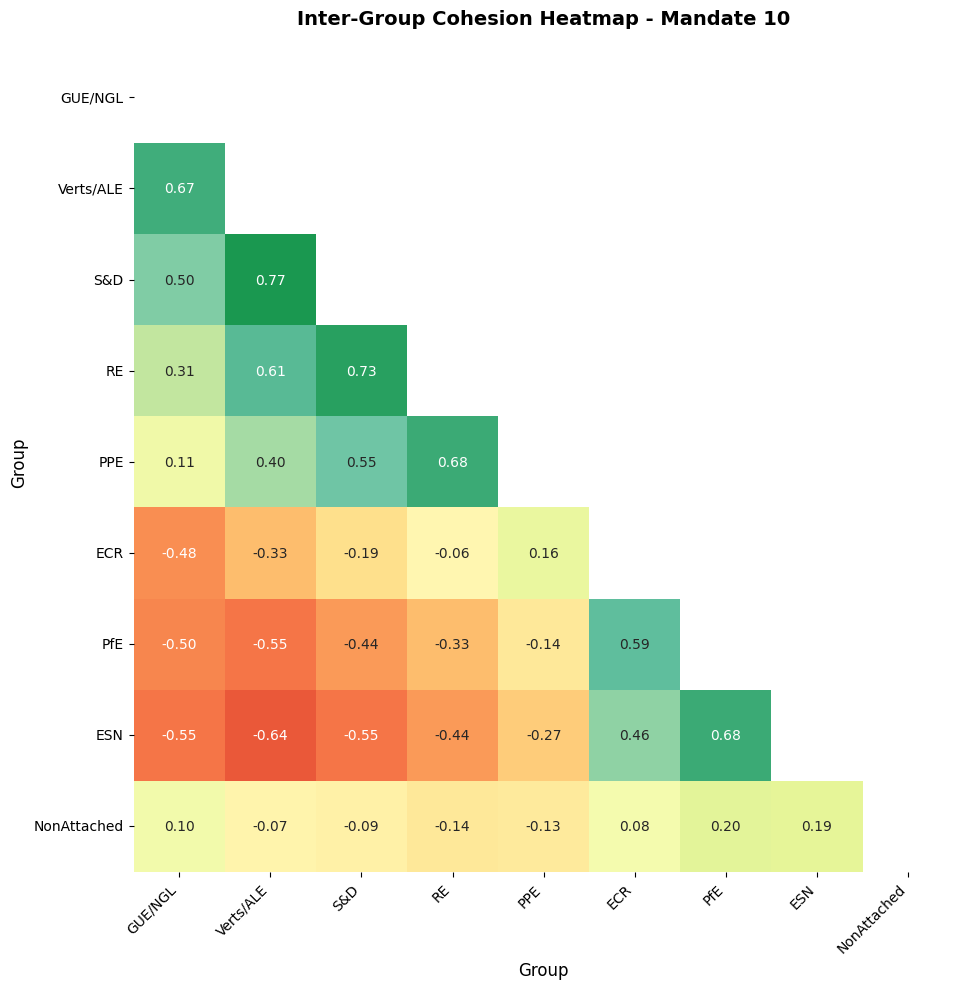

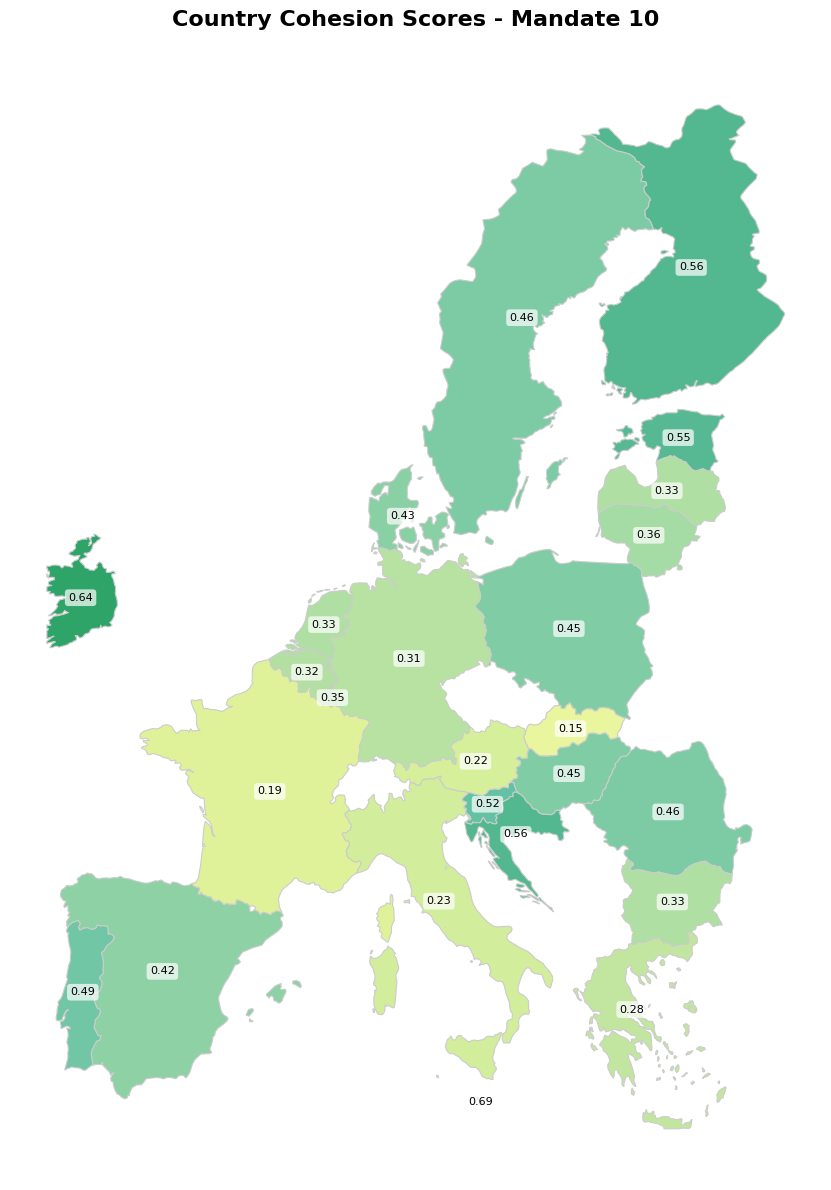

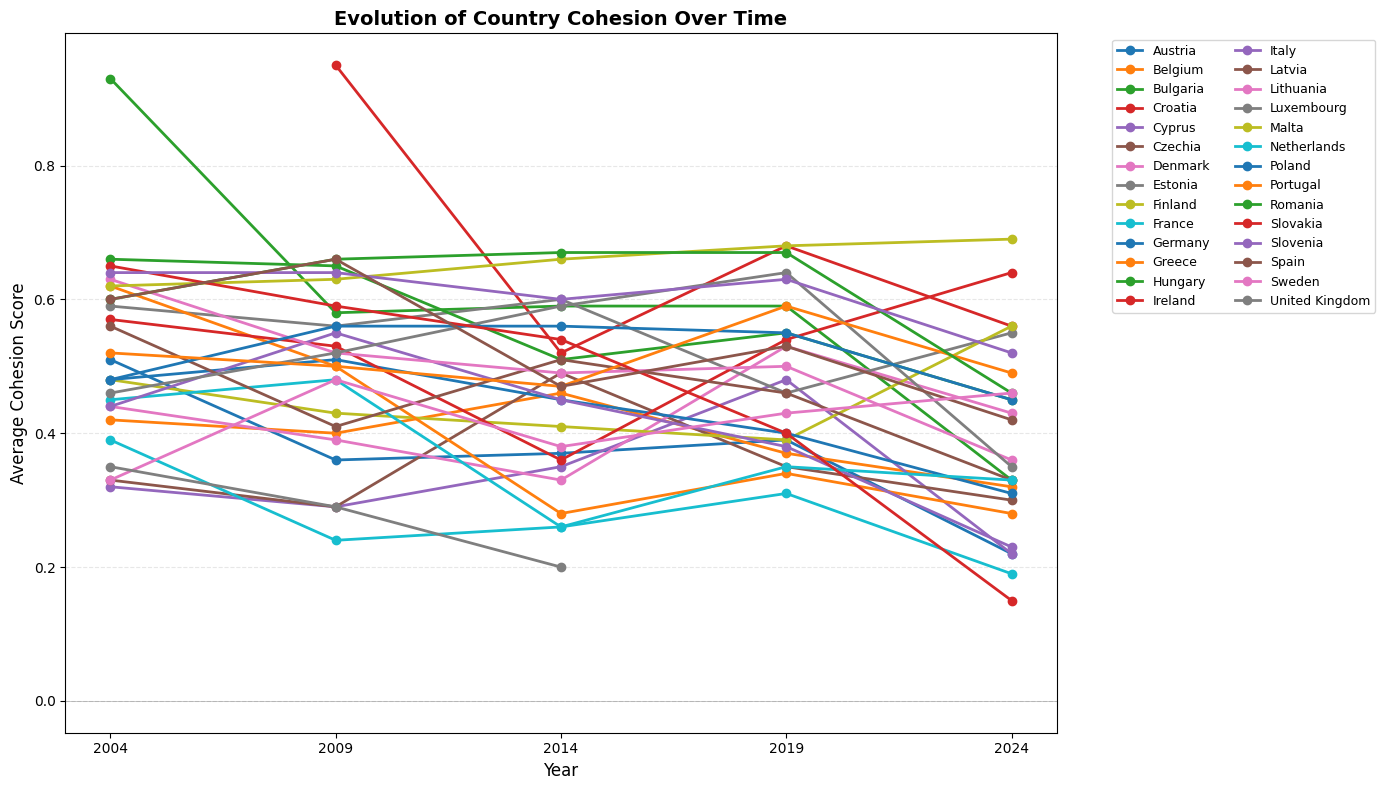

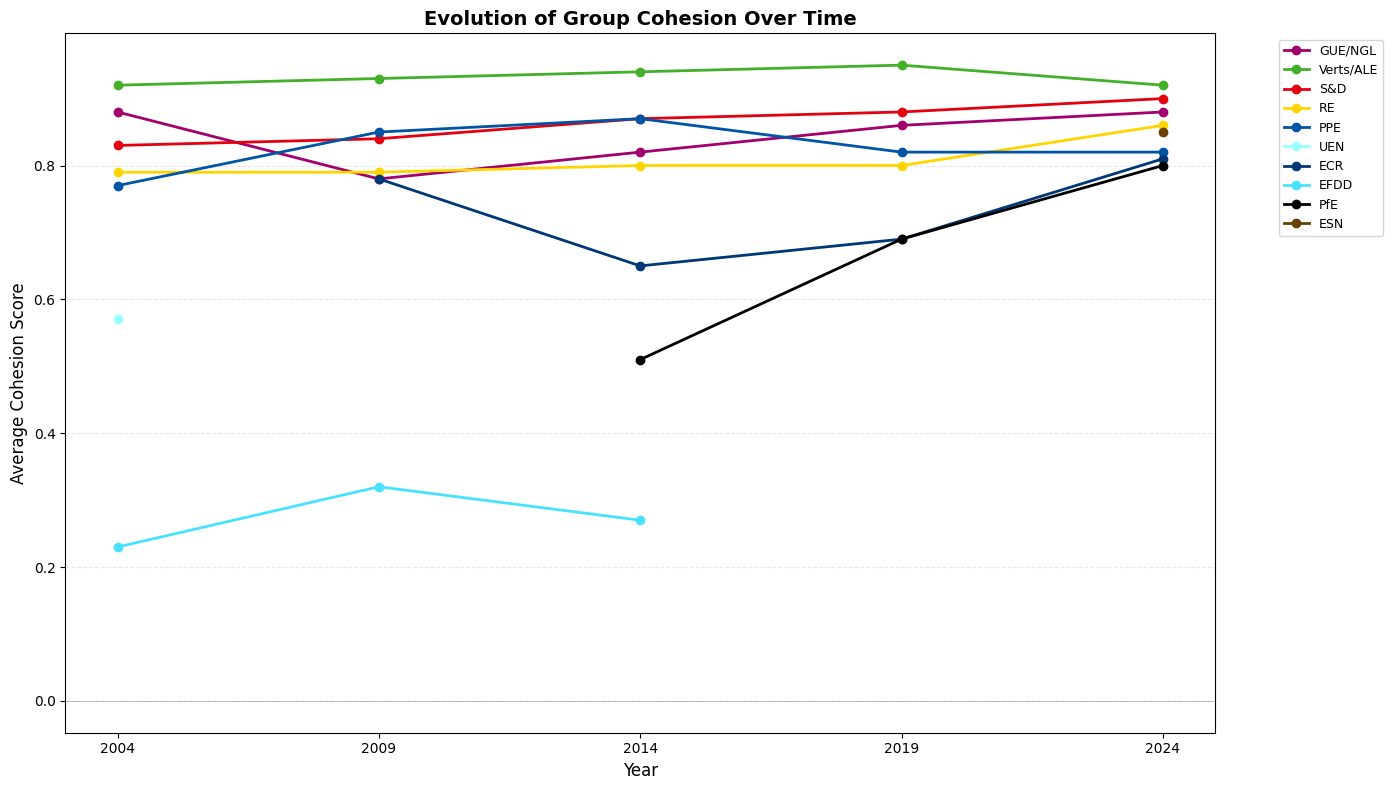

In [254]:
charts = generate_all_mandate_charts()

In [21]:
import requests
import json
import re
import time

def clean_committee_label(label):
    """
    Clean committee label by removing newlines, numbers in parentheses, and extra whitespace.
    Example: "Foreign Affairs\n (1)" -> "Foreign Affairs"
    """
    if not label:
        return ""
    # Remove newlines
    cleaned = label.replace('\n', ' ')
    # Remove numbers in parentheses like "(1)" or "(2)"
    cleaned = re.sub(r'\s*\(\d+\)\s*', '', cleaned)
    # Remove extra whitespace
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

def fetch_topic(epref, only_cod=False, retry_delay=2):
    """
    Fetch committee values for a given EP reference (e.g., "2021/0375").
    Extracts committee responsible or Commission DG values.
    Falls back to first-level subjects if no committees are found.
    Removes "(COD)" and other suffixes from the reference before searching.
    Handles both string and list inputs.
    
    Args:
        epref: EP reference (string or list)
        only_cod: If True, only process references with "(COD)" suffix. Default False.
        retry_delay: Initial delay in seconds between retries (exponential backoff). Default 2.
    
    Returns:
        First committee name or first-level subject (string), or None if not found or filtered out.
    """
    import sys
    # Ensure epref is a string
    if isinstance(epref, list):
        epref = epref[0] if len(epref) > 0 else None
    if not isinstance(epref, str):
        epref = str(epref) if epref is not None else ""

    if not epref:
        return None

    # If only_cod is True, check if the reference has "(COD)" suffix
    if only_cod:
        if not re.search(r'\(COD\)', epref, re.IGNORECASE):
            return None  # Skip if not COD

    # Remove "(COD)" and other common suffixes from the reference
    cleaned_ref = re.sub(r'\s*\([^)]+\)\s*$', '', epref).strip()

    url = "https://oeil.secure.europarl.europa.eu/oeil/en/search/facets"
    params = {
        "fullText.term": cleaned_ref,
        "fullText.mode": "EXACT_WORD"
    }

    # Keep trying forever until we get some result
    data = None
    attempt = 0
    while True:
        try:
            r = requests.get(url, params=params, timeout=15)
            r.raise_for_status()
            data = r.json()
            break  # Success, exit retry loop
        except Exception as e:
            attempt += 1
            print(f"API request failed for epref '{epref}' (attempt {attempt}): {type(e).__name__}: {str(e)}", file=sys.stderr)
            wait_time = retry_delay * (2 ** min(attempt - 1, 5))  # Cap exponential growth
            print(f"Retrying in {wait_time} seconds...", file=sys.stderr)
            time.sleep(wait_time)
            continue
    # After the loop, we must have `data` or we would still be looping

    try:
        committees = []
        
        # First, try to extract from committee responsible
        for field in data.get("fields", []):
            if field.get("name") == "committee" and field.get("type") == "field-group":
                # Look for committeeResponsible field
                for subfield in field.get("fields", []):
                    if subfield.get("name") == "committeeResponsible":
                        # Extract labels from availableValues (skip the first "All committees responsible" option)
                        for value in subfield.get("availableValues", []):
                            label = value.get("label", "")
                            if label and "All committees responsible" not in label:
                                cleaned = clean_committee_label(label)
                                if cleaned:
                                    committees.append(cleaned)
                        if committees:
                            return committees[0]  # Return first committee

            # If no committee responsible, try Commission DG
            if field.get("name") == "commissionDgId":
                for value in field.get("availableValues", []):
                    label = value.get("label", "")
                    if label and "All Commission DGs" not in label:
                        cleaned = clean_committee_label(label)
                        if cleaned:
                            committees.append(cleaned)
                if committees:
                    return committees[0]  # Return first Commission DG
        
        # If no committees found, fall back to first-level subjects
        for field in data.get("fields", []):
            if field.get("name") == "subject" and field.get("type") == "tree":
                # Extract first-level subjects (can be either groups or options)
                for value in field.get("availableValues", []):
                    # Skip "All subjects" option
                    if value.get("type") == "option" and value.get("label") == "All subjects":
                        continue
                    # Extract first-level groups (direct children of root)
                    if value.get("type") == "group":
                        label = value.get("label", "")
                        if label:
                            cleaned = clean_committee_label(label)
                            cleaned = re.sub(r'^\d+\.?\s*', '', cleaned).strip()
                            if cleaned:
                                committees.append(cleaned)
                    # Also handle direct option types (not nested in groups)
                    elif value.get("type") == "option":
                        label = value.get("label", "")
                        if label:
                            cleaned = clean_committee_label(label)
                            cleaned = re.sub(r'^\d+\.?\s*', '', cleaned).strip()
                            if cleaned:
                                committees.append(cleaned)
                if committees:
                    return committees[0]  # Return first subject

        return None
    except Exception as e:
        # Silently return None for parsing errors
        return None


In [22]:
import pprint
from concurrent.futures import ThreadPoolExecutor, as_completed, TimeoutError as FuturesTimeoutError
import time
from threading import Lock
from collections import defaultdict

def is_code_string(s):
    """
    Check if a string is actually a code (A, B, RC-B, or C code) rather than an epref.
    Returns (is_code, code_type, normalized_code) where:
    - is_code: True if it's a code, False if it's an epref
    - code_type: 'a', 'b', 'rc_b', 'c', or None
    - normalized_code: the normalized code string, or None
    """
    if not s or not isinstance(s, str):
        return False, None, None
    
    # Check for RC-B codes: RC-B{mandate}-NNNN/YYYY (handles both - and –)
    rc_b_match = re.match(r'RC[\u002D\u2013-]B(\d+)[\u002D\u2013-](\d{1,4})/(\d{4})$', s)
    if rc_b_match:
        mandate = rc_b_match.group(1)
        num = rc_b_match.group(2).zfill(4)
        year = rc_b_match.group(3)
        return True, 'rc_b', f"RC-B{mandate}-{num}/{year}"
    
    # Check for A codes: A{mandate}-NNNN/YYYY (handles both - and –)
    a_match = re.match(r'A(\d+)[\u002D\u2013-](\d{1,4})/(\d{4})$', s)
    if a_match:
        mandate = a_match.group(1)
        num = a_match.group(2).zfill(4)
        year = a_match.group(3)
        return True, 'a', f"A{mandate}-{num}/{year}"
    
    # Check for B codes: B{mandate}-NNNN/YYYY (handles both - and –)
    b_match = re.match(r'B(\d+)[\u002D\u2013-](\d{1,4})/(\d{4})$', s)
    if b_match:
        mandate = b_match.group(1)
        num = b_match.group(2).zfill(4)
        year = b_match.group(3)
        return True, 'b', f"B{mandate}-{num}/{year}"
    
    # Check for C codes: C{mandate}-NNNN/YYYY (handles both - and –)
    c_match = re.match(r'C(\d+)[\u002D\u2013-](\d{1,4})/(\d{4})$', s)
    if c_match:
        mandate = c_match.group(1)
        num = c_match.group(2).zfill(4)
        year = c_match.group(3)
        return True, 'c', f"C{mandate}-{num}/{year}"
    
    return False, None, None

def extract_b_code(title):
    """
    Extract B code from title (e.g., "B9-0421/2020" or "B10-0450/2025").
    B codes are similar to RC-B codes but without the "RC-" prefix.
    Handles both regular hyphens (-) and en dashes (–).
    """
    if not title:
        return None
    
    # Pattern: B{mandate}-{number}/{year} or B{mandate}–{number}/{year}
    # Handles both regular hyphen (-) and en dash (–)
    # Example: "B9-0421/2020", "B10-0450/2025", "B10–0450/2025"
    pattern = r'\bB(\d+)[\u002D\u2013-](\d{1,4})/(\d{4})\b'
    match = re.search(pattern, title)
    if match:
        mandate = match.group(1)
        num = match.group(2).zfill(4)  # Pad to 4 digits
        year = match.group(3)
        return f"B{mandate}-{num}/{year}"  # Normalize to regular hyphen
    return None

def extract_rc_b_code(title):
    """
    Extract RC-B code from title (e.g., "RC-B9-0281/2022" or "RC-B10-0220/2025").
    Returns the code if found, None otherwise.
    Handles both regular hyphens (-) and en dashes (–).
    """
    if not title:
        return None
    
    # Pattern: RC-B{mandate}-{number}/{year} or RC-B{mandate}–{number}/{year}
    # Handles both regular hyphen (-) and en dash (–)
    # Example: "RC-B9-0281/2022", "RC-B10-0220/2025", "RC–B10–0220/2025"
    pattern = r'RC[\u002D\u2013-]B(\d+)[\u002D\u2013-](\d+)/(\d{4})'
    match = re.search(pattern, title)
    if match:
        mandate = match.group(1)
        number = match.group(2)
        year = match.group(3)
        return f"RC-B{mandate}-{number}/{year}"  # Normalize to regular hyphens
    return None

def extract_a_code(title):
    """
    Extract A code from title (e.g., "A9-0088/2022" or "A10-0048/2025").
    Returns the code if found, None otherwise.
    Handles both regular hyphens (-) and en dashes (–).
    """
    if not title:
        return None
    
    # Pattern: A{mandate}-{number}/{year} or A{mandate}–{number}/{year}
    # Handles both regular hyphen (-) and en dash (–)
    # Example: "A9-0088/2022", "A10-0048/2025", "A10–0048/2025"
    pattern = r'\bA(\d+)[\u002D\u2013-](\d+)/(\d{4})\b'
    match = re.search(pattern, title)
    if match:
        mandate = match.group(1)
        number = match.group(2)
        year = match.group(3)
        return f"A{mandate}-{number}/{year}"  # Normalize to regular hyphen
    return None

def extract_c_code(title):
    """
    Extract C code from title (e.g., "C9-0120/2024" or "C10-0120/2025").
    Returns the code if found, None otherwise.
    Handles both regular hyphens (-) and en dashes (–).
    """
    if not title:
        return None
    
    # Pattern: C{mandate}-{number}/{year} or C{mandate}–{number}/{year}
    # Handles both regular hyphen (-) and en dash (–)
    # Example: "C9-0120/2024", "C10-0120/2025", "C10–0120/2025"
    pattern = r'\bC(\d+)[\u002D\u2013-](\d+)/(\d{4})\b'
    match = re.search(pattern, title)
    if match:
        mandate = match.group(1)
        number = match.group(2)
        year = match.group(3)
        return f"C{mandate}-{number}/{year}"  # Normalize to regular hyphen
    return None

def convert_b_to_url(b_code):
    """
    Convert B code to URL format.
    Example: "B9-0421/2020" -> "https://www.europarl.europa.eu/doceo/document/B-9-2020-0421_EN.html"
    Example: "B10-0450/2025" -> "https://www.europarl.europa.eu/doceo/document/B-10-2025-0450_EN.html"
    """
    if not b_code:
        return None
    
    # Pattern: B{mandate}-NNNN/YYYY
    match = re.match(r'B(\d+)-(\d{4})/(\d{4})', b_code)
    if match:
        mandate = match.group(1)
        num = match.group(2)
        year = match.group(3)
        return f"https://www.europarl.europa.eu/doceo/document/B-{mandate}-{year}-{num}_EN.html"
    return None

def convert_rc_b_to_url(rc_b_code):
    """
    Convert RC-B code to URL format.
    Example: "RC-B9-0068/2024" -> "https://www.europarl.europa.eu/doceo/document/RC-9-2024-0068_EN.html"
    """
    if not rc_b_code:
        return None
    
    # Extract components: RC-B{mandate}-{number}/{year}
    match = re.match(r'RC-B(\d+)-(\d+)/(\d{4})', rc_b_code)
    if match:
        mandate = match.group(1)
        number = match.group(2)
        year = match.group(3)
        # Format: RC-{mandate}-{year}-{number}_EN.html
        url = f"https://www.europarl.europa.eu/doceo/document/RC-{mandate}-{year}-{number}_EN.html"
        return url
    return None

def convert_a_to_url(a_code):
    """
    Convert A code to URL format.
    Example: "A9-0088/2022" -> "https://www.europarl.europa.eu/doceo/document/A-9-2022-0088_EN.html"
    """
    if not a_code:
        return None
    
    # Extract components: A{mandate}-{number}/{year}
    match = re.match(r'A(\d+)-(\d+)/(\d{4})', a_code)
    if match:
        mandate = match.group(1)
        number = match.group(2)
        year = match.group(3)
        # Format: A-{mandate}-{year}-{number}_EN.html
        url = f"https://www.europarl.europa.eu/doceo/document/A-{mandate}-{year}-{number}_EN.html"
        return url
    return None

def convert_c_to_eurlex_search_url(c_code):
    """
    Convert C code to EUR-Lex search URL.
    Example: "C9-0120/2024" -> "https://eur-lex.europa.eu/search.html?text=C9-0120%2F2024&lang=en&type=quick&scope=EURLEX"
    """
    if not c_code:
        return None
    
    # URL encode the code (especially the forward slash)
    import urllib.parse
    encoded_code = urllib.parse.quote(c_code, safe='')
    url = f"https://eur-lex.europa.eu/search.html?text={encoded_code}&lang=en&type=quick&scope=EURLEX"
    return url

def fetch_epref_from_eurlex_search(url, retry_delay=2, max_retries=3, max_total_time=10):
    """
    Fetch epref from EUR-Lex search results page.
    Gets the first result and extracts the epref (like "2024/0073(COD)") from its title.
    Retries up to max_retries times on network errors, with exponential backoff.
    Total time is limited to max_total_time seconds.
    """
    if not url:
        return None

    import time

    html_content = None
    attempt = 0
    start_time = time.time()
    while attempt < max_retries:
        # Check if we've exceeded total time limit
        if time.time() - start_time > max_total_time:
            return None
        try:
            r = requests.get(url, timeout=10)
            r.raise_for_status()
            html_content = r.text
            break  # Success, exit retry loop
        except (requests.exceptions.RequestException, requests.exceptions.ConnectionError) as e:
            attempt += 1
            if attempt < max_retries:
                wait_time = min(retry_delay * (2 ** (attempt - 1)), 5)  # Cap wait time at 5 seconds
                # Don't wait if we're already close to timeout
                if time.time() - start_time + wait_time < max_total_time:
                    time.sleep(wait_time)
            continue
        except Exception as e:
            return None

    if not html_content:
        return None

    try:
        # Find the first search result
        # The first result is in a div with class "SearchResult" and has an h2 > a with class "title"
        # Pattern: <h2><a ... class="title" ...>...title text...</a></h2>
        
        # Try to find the first SearchResult div
        first_result_pattern = r'<div[^>]*class="SearchResult"[^>]*>.*?<h2>.*?<a[^>]*class="title"[^>]*>(.*?)</a>.*?</h2>'
        first_result_match = re.search(first_result_pattern, html_content, re.DOTALL)
        
        if first_result_match:
            title_html = first_result_match.group(1)
            # Clean HTML tags from title
            title_text = re.sub(r'<[^>]+>', '', title_html)
            
            # Look for epref pattern in the title: YYYY/NNNN(XXX) or YYYY/NNNNR(XXX) where R is an optional letter
            epref_pattern = r'(\d{4}/\d{4}[A-Z]?\([^)]+\))'
            epref_match = re.search(epref_pattern, title_text)
            if epref_match:
                return epref_match.group(1)
        
        # Fallback: search for the pattern anywhere in the HTML (less reliable)
        epref_pattern = r'(\d{4}/\d{4}[A-Z]?\([^)]+\))'
        general_match = re.search(epref_pattern, html_content)
        if general_match:
            return general_match.group(1)
        
        return None
    except Exception as e:
        return None

def fetch_epref_from_document_page(url, retry_delay=2, max_retries=3, max_total_time=10):
    """
    Fetch epref from document page HTML (works for both RC-B and A codes).
    Looks for pattern like "2024/2508(RSP)" in links within the main tag.
    Retries up to max_retries times on network errors, with exponential backoff.
    Total time is limited to max_total_time seconds.
    """
    if not url:
        return None

    import time

    html_content = None
    attempt = 0
    start_time = time.time()
    while attempt < max_retries:
        # Check if we've exceeded total time limit
        if time.time() - start_time > max_total_time:
            return None
        try:
            r = requests.get(url, timeout=10)
            r.raise_for_status()
            html_content = r.text
            break  # Success, exit retry loop
        except (requests.exceptions.RequestException, requests.exceptions.ConnectionError) as e:
            attempt += 1
            if attempt < max_retries:
                wait_time = min(retry_delay * (2 ** (attempt - 1)), 5)  # Cap wait time at 5 seconds
                # Don't wait if we're already close to timeout
                if time.time() - start_time + wait_time < max_total_time:
                    time.sleep(wait_time)
            continue
        except Exception as e:
            return None

    if not html_content:
        return None

    try:
        # Parse HTML to find epref in links
        # Look for pattern: YYYY/NNNN(XXX) or YYYY/NNNNR(XXX) where R is an optional letter
        # The epref appears in links like: href="...reference=2024/2508(RSP)" or "2021/0429R(APP)"
        # Pattern allows optional letter between digits and parenthesis
        pattern = r'(\d{4}/\d{4}[A-Z]?\([^)]+\))'
        
        # Try to find in href attributes first (more reliable)
        href_pattern = r'href="[^"]*reference=(\d{4}/\d{4}[A-Z]?\([^)]+\))"'
        href_match = re.search(href_pattern, html_content)
        if href_match:
            return href_match.group(1)
        
        # Fallback: search in link text (inside <a> tags)
        # Look for links containing the pattern
        link_pattern = r'<a[^>]*>.*?(\d{4}/\d{4}[A-Z]?\([^)]+\)).*?</a>'
        link_match = re.search(link_pattern, html_content, re.DOTALL)
        if link_match:
            return link_match.group(1)
        
        # Last resort: search anywhere in the HTML for the pattern
        general_match = re.search(pattern, html_content)
        if general_match:
            return general_match.group(1)
        
        return None
    except Exception as e:
        return None

# Alias for backward compatibility
fetch_epref_from_rc_b_page = fetch_epref_from_document_page

def extract_all_codes_from_title(title):
    """
    Extract all codes from title, including:
    - Codes with parentheses: YYYY/NNNN(COD), YYYY/NNNN(RSP), etc.
    - Codes without parentheses: 0396/2020, etc.
    - RC-B codes: RC-B9-0281/2022 (which need to be fetched from HTML page)
    - A codes: A9-0088/2022 (which need to be fetched from HTML page)
    - C codes: C9-0120/2024 (which need to be fetched from EUR-Lex search)
    
    Returns a tuple: (code_with_parentheses, codes_without_parentheses, all_codes, rc_b_code, a_code, c_code, b_code)
    - code_with_parentheses: The code with parentheses suffix (e.g., "2020/0366" from "2020/0366(COD)")
    - codes_without_parentheses: List of codes without parentheses (e.g., ["0396/2020"])
    - all_codes: List of all codes found (normalized to YYYY/NNNN format)
    - rc_b_code: RC-B code if found (e.g., "RC-B9-0281/2022")
    - a_code: A code if found (e.g., "A9-0088/2022")
    - c_code: C code if found (e.g., "C9-0120/2024")
    - b_code: B code if found (e.g., "B9-0421/2020")
    """
    if not title:
        return None, [], [], None, None, None, None
    
    code_with_parentheses = None
    codes_without_parentheses = []
    all_codes = []
    rc_b_code = None
    a_code = None
    c_code = None
    b_code = None
    
    # Pattern 0: RC-B codes like "RC-B9-0281/2022"
    rc_b_match = extract_rc_b_code(title)
    if rc_b_match:
        rc_b_code = rc_b_match
    
    # Pattern 0.25: B codes like "B9-0421/2020" (without RC- prefix)
    b_match = extract_b_code(title)
    if b_match:
        b_code = b_match
    
    # Pattern 0.5: A codes like "A9-0088/2022"
    a_match = extract_a_code(title)
    if a_match:
        a_code = a_match
    
    # Pattern 0.6: C codes like "C9-0120/2024"
    c_match = extract_c_code(title)
    if c_match:
        c_code = c_match
    
    # Pattern 1: Codes with parentheses like "2020/0366(COD)" or "2020/0366 (COD)"
    pattern_with_parens = r'(\d{4}/\d{4})\s*\([^)]+\)'
    matches_with_parens = re.findall(pattern_with_parens, title)
    if matches_with_parens:
        # Use the first code with parentheses (prefer this one for API lookup)
        code_with_parentheses = matches_with_parens[0]
        all_codes.append(code_with_parentheses)
    
    # Pattern 2: Codes without parentheses like "0396/2020"
    # Match patterns like just "0396/2020" (but exclude C codes, A codes, and RC-B codes - they're handled separately)
    # We can't use variable-width lookbehind, so we'll match all YYYY/NNNN patterns and filter out those that are part of special codes
    pattern_without_parens = r'(\d{4}/\d{4})(?!\s*\()'
    all_matches = re.finditer(pattern_without_parens, title)
    
    for match_obj in all_matches:
        match = match_obj.group(1)
        start_pos = match_obj.start()
        end_pos = match_obj.end()
        
        # Check if this match is part of a special code by looking at the substring ending at this position
        # Look back enough to catch patterns like "RC-B9-", "A9-", or "C9-"
        substring_end = title[:end_pos]
        
        # Check if the substring ending at this position matches a special code pattern
        # Pattern: C{mandate}-{number}/{year} or C{mandate}–{number}/{year} where {number}/{year} is our match
        # Handles both regular hyphen (-) and en dash (–)
        if re.search(r'C\d+[\u002D\u2013-]' + re.escape(match) + r'$', substring_end):
            continue
        
        # Pattern: A{mandate}-{number}/{year} or A{mandate}–{number}/{year}
        if re.search(r'A\d+[\u002D\u2013-]' + re.escape(match) + r'$', substring_end):
            continue
        
        # Pattern: RC-B{mandate}-{number}/{year} or RC-B{mandate}–{number}/{year} or RC–B{mandate}–{number}/{year}
        if re.search(r'RC[\u002D\u2013-]B\d+[\u002D\u2013-]' + re.escape(match) + r'$', substring_end):
            continue
        
        # Pattern: B{mandate}-{number}/{year} or B{mandate}–{number}/{year}
        if re.search(r'B\d+[\u002D\u2013-]' + re.escape(match) + r'$', substring_end):
            continue
        
        # This is a regular code without parentheses
        if match not in all_codes:  # Avoid duplicates
            codes_without_parentheses.append(match)
            all_codes.append(match)
    
    return code_with_parentheses, codes_without_parentheses, all_codes, rc_b_code, a_code, c_code, b_code

def extract_epref_from_title(title):
    """
    Extract epref reference from title.
    Prefers codes with parentheses suffix (like 2020/0366(COD)).
    Falls back to codes without parentheses if no code with parentheses is found.
    Note: RC-B, A, and C codes are handled separately in the enrichment function.
    Returns the code in YYYY/NNNN format (without suffix), or None.
    """
    code_with_parens, codes_without_parens, _, _, _, _ = extract_all_codes_from_title(title)
    
    # Prefer code with parentheses
    if code_with_parens:
        return code_with_parens
    
    # Fall back to first code without parentheses
    if codes_without_parens:
        return codes_without_parens[0]
    
    return None

def enrich_dataset_with_topics(mandate, max_sessions=None, only_cod=False, show_count=True, 
                                max_workers=5, use_cache=True, cache_file=None, code_cache_file=None):
    """
    Enrich dataset with committee values for sessions that have 'epref' field.
    OPTIMIZED VERSION with parallel processing and caching.
    
    Extracts committee responsible or Commission DG values from the API.
    Falls back to first-level subjects if no committees are found.
    If 'epref' field doesn't exist, tries to extract it from title.
    Handles both string and list formats for epref.
    
    NEW: Maps codes with parentheses (e.g., 2020/0366(COD)) to codes without (e.g., 0396/2020),
    so all related sessions get the same topic.

    Args:
        mandate: Mandate number (e.g., 9, 10)
        max_sessions: Maximum number of sessions to process (None for all)
        only_cod: If True, only process epref references with "(COD)" suffix. Default False.
        show_count: If True, print out counts statistics after enrichment.
        max_workers: Number of parallel threads for API calls (default: 10)
        use_cache: If True, cache results to avoid duplicate API calls (default: True)
        cache_file: Path to epref-to-topic cache file (default: 'data/epref_cache.json')
        code_cache_file: Path to code-to-epref cache file (default: 'data/code_to_epref_cache.json')
    """
    # Load the data
    with open(f'data/ep_votes_{mandate}.json', 'r') as f:
        data = json.load(f)
    
    # Load or initialize caches (separate for code-to-epref and epref-to-topic)
    epref_cache = {}  # Maps epref -> topic
    code_cache = {}   # Maps codes (RC-B, A, C, B) -> epref
    
    if use_cache:
        # Load epref-to-topic cache
        if cache_file is None:
            cache_file = 'data/epref_cache.json'
        try:
            with open(cache_file, 'r') as f:
                epref_cache = json.load(f)
            # Filter to only keep entries in YYYY/XXXX format (no parentheses suffix, no code entries)
            # epref_cache should only contain epref keys in YYYY/XXXX format
            filtered_cache = {}
            for k, v in epref_cache.items():
                # Only keep if key is exactly in YYYY/XXXX format (no parentheses, no codes like RC-B, A, C, B)
                if re.match(r'^\d{4}/\d{4}$', k):
                    filtered_cache[k] = v
            epref_cache = filtered_cache
            print(f"Loaded {len(epref_cache)} cached epref-to-topic mappings (filtered to YYYY/XXXX format only)")
        except FileNotFoundError:
            epref_cache = {}
        
        # Load code-to-epref cache
        if code_cache_file is None:
            code_cache_file = 'data/code_to_epref_cache.json'
        try:
            with open(code_cache_file, 'r') as f:
                code_cache = json.load(f)
            print(f"Loaded {len(code_cache)} cached code-to-epref mappings")
        except FileNotFoundError:
            code_cache = {}
    
    # Find sessions with epref or extract from title
    # Build mapping: code_with_parens -> [codes_without_parens]
    code_mapping = defaultdict(set)  # Maps codes with parentheses to codes without
    rc_b_to_epref = {}  # Maps RC-B codes to their epref (fetched from HTML)
    a_to_epref = {}  # Maps A codes to their epref (fetched from HTML)
    c_to_epref = {}  # Maps C codes to their epref (fetched from EUR-Lex search)
    b_to_epref = {}  # Maps B codes to their epref (fetched from HTML)
    sessions_to_enrich = []
    epref_to_sessions = defaultdict(list)  # Group sessions by epref to minimize API calls
    
    # First pass: collect all RC-B, A, C, and B codes and fetch their eprefs
    rc_b_codes_to_fetch = set()
    a_codes_to_fetch = set()
    c_codes_to_fetch = set()
    b_codes_to_fetch = set()
    for session in data:
        # Extract codes from title
        if 'title' in session and session['title']:
            _, _, _, rc_b_code, a_code, c_code, b_code = extract_all_codes_from_title(session['title'])
            if rc_b_code:
                rc_b_codes_to_fetch.add(rc_b_code)
            if a_code:
                a_codes_to_fetch.add(a_code)
            if c_code:
                c_codes_to_fetch.add(c_code)
            if b_code:
                b_codes_to_fetch.add(b_code)
        
        # Check if epref field contains a code instead of an actual epref
        if 'epref' in session and session['epref']:
            epref_raw = session['epref']
            # Handle both list and string formats
            if isinstance(epref_raw, list):
                epref_value = epref_raw[0] if len(epref_raw) > 0 else None
            elif isinstance(epref_raw, str):
                epref_value = epref_raw
            else:
                epref_value = None
            
            # Check if the epref is actually a code
            if epref_value:
                is_code, code_type, normalized_code = is_code_string(epref_value)
                if is_code:
                    if code_type == 'rc_b':
                        rc_b_codes_to_fetch.add(normalized_code)
                    elif code_type == 'a':
                        a_codes_to_fetch.add(normalized_code)
                    elif code_type == 'b':
                        b_codes_to_fetch.add(normalized_code)
                    elif code_type == 'c':
                        c_codes_to_fetch.add(normalized_code)
    
    # Filter out codes that should be ignored (known to hang)
    ignored_a_codes = {'A9-0280/2019', 'A9-0621/2020'}
    ignored_b_codes = {'B9-0664/2022'}
    
    codes_to_ignore_a = ignored_a_codes & a_codes_to_fetch
    if codes_to_ignore_a:
        print(f"[DEBUG] Ignoring {len(codes_to_ignore_a)} A codes that are known to hang: {codes_to_ignore_a}", flush=True)
    a_codes_to_fetch = a_codes_to_fetch - ignored_a_codes
    
    codes_to_ignore_b = ignored_b_codes & b_codes_to_fetch
    if codes_to_ignore_b:
        print(f"[DEBUG] Ignoring {len(codes_to_ignore_b)} B codes that are known to hang: {codes_to_ignore_b}", flush=True)
    b_codes_to_fetch = b_codes_to_fetch - ignored_b_codes
    
    # Load cached mappings for RC-B, A, C, and B codes from code_cache
    if use_cache:
        for code in list(rc_b_codes_to_fetch):
            if code in code_cache:
                cached_epref = code_cache[code]
                # Check if it's an epref (format YYYY/NNNN)
                if cached_epref and re.match(r'^\d{4}/\d{4}$', str(cached_epref)):
                    rc_b_to_epref[code] = cached_epref
                    rc_b_codes_to_fetch.remove(code)
        for code in list(a_codes_to_fetch):
            if code in code_cache:
                cached_epref = code_cache[code]
                # Check if it's an epref (format YYYY/NNNN)
                if cached_epref and re.match(r'^\d{4}/\d{4}$', str(cached_epref)):
                    a_to_epref[code] = cached_epref
                    a_codes_to_fetch.remove(code)
        for code in list(c_codes_to_fetch):
            if code in code_cache:
                cached_epref = code_cache[code]
                # Check if it's an epref (format YYYY/NNNN)
                if cached_epref and re.match(r'^\d{4}/\d{4}$', str(cached_epref)):
                    c_to_epref[code] = cached_epref
                    c_codes_to_fetch.remove(code)
        for code in list(b_codes_to_fetch):
            if code in code_cache:
                cached_epref = code_cache[code]
                # Check if it's an epref (format YYYY/NNNN)
                if cached_epref and re.match(r'^\d{4}/\d{4}$', str(cached_epref)):
                    b_to_epref[code] = cached_epref
                    b_codes_to_fetch.remove(code)
        if rc_b_to_epref or a_to_epref or c_to_epref or b_to_epref:
            cached_count = len(rc_b_to_epref) + len(a_to_epref) + len(c_to_epref) + len(b_to_epref)
            print(f"Loaded {cached_count} cached code-to-epref mappings (RC-B: {len(rc_b_to_epref)}, A: {len(a_to_epref)}, C: {len(c_to_epref)}, B: {len(b_to_epref)})")
    
    # Fetch eprefs for RC-B codes in parallel
    if rc_b_codes_to_fetch:
        print(f"Found {len(rc_b_codes_to_fetch)} unique RC-B codes to fetch eprefs for...")
        def fetch_rc_b_epref(rc_b_code):
            """Fetch epref for a single RC-B code"""
            try:
                url = convert_rc_b_to_url(rc_b_code)
                if url:
                    epref = fetch_epref_from_document_page(url)
                    if epref:
                        # Extract just YYYY/NNNN (without parentheses suffix) for consistency
                        epref_base = re.match(r'(\d{4}/\d{4})', epref)
                        if epref_base:
                            return ('rc_b', rc_b_code, epref_base.group(1))
                    return ('rc_b', rc_b_code, None)
                return ('rc_b', rc_b_code, None)
            except Exception as e:
                print(f"Error fetching epref for {rc_b_code}: {e}")
                return ('rc_b', rc_b_code, None)
        
        # Fetch in parallel
        print(f"[DEBUG] Starting to fetch {len(rc_b_codes_to_fetch)} RC-B codes...", flush=True)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Create a mapping of future to code for tracking
            future_to_code = {}
            futures = []
            for rc_b_code in rc_b_codes_to_fetch:
                future = executor.submit(fetch_rc_b_epref, rc_b_code)
                futures.append(future)
                future_to_code[future] = rc_b_code
            
            completed = 0
            start_time = time.time()
            last_progress_time = start_time
            last_few_start_time = None  # Track when we first detected last few codes
            timeout_per_future = 15  # 15 seconds per future
            max_total_time = min(300, timeout_per_future * max_workers)  # Maximum total time: 5 minutes or 15s * workers
            progress_check_interval = 10  # Check for stuck futures every 10 seconds
            last_few_timeout = 20  # Give up on last few after 20 seconds
            
            # Use a thread to periodically report progress
            import threading
            stop_progress_thread = threading.Event()
            
            def report_progress():
                while not stop_progress_thread.is_set():
                    time.sleep(progress_check_interval)
                    if stop_progress_thread.is_set():
                        break
                    elapsed = time.time() - start_time
                    pending = [f for f in futures if not f.done()]
                    if pending and len(pending) <= 5:  # Only report if few remaining
                        pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                        print(f"[DEBUG] Still processing {len(pending)} RC-B codes after {elapsed:.1f}s: {pending_codes}", flush=True)
            
            progress_thread = threading.Thread(target=report_progress, daemon=True)
            progress_thread.start()
            
            try:
                for future in as_completed(futures, timeout=max_total_time):
                    try:
                        code_type, code, epref = future.result(timeout=1)
                        completed += 1
                        elapsed = time.time() - start_time
                        if epref:
                            rc_b_to_epref[code] = epref
                            # Cache the mapping in code_cache
                            if use_cache:
                                code_cache[code] = epref
                            print(f"  ✓ {code} -> {epref} [{completed}/{len(rc_b_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        else:
                            print(f"  ✗ {code} -> No epref found [{completed}/{len(rc_b_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        last_progress_time = time.time()
                        
                        # Check if we're down to last few and they're taking too long
                        pending = [f for f in futures if not f.done()]
                        if len(pending) <= 5 and len(pending) > 0:
                            # Track when we first detected we were down to last few
                            if last_few_start_time is None:
                                last_few_start_time = time.time()
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Down to last {len(pending)} RC-B codes: {pending_codes}. Will give up after {last_few_timeout}s...", flush=True)
                            
                            # Check if we've been waiting too long on the last few
                            time_waiting_on_last_few = time.time() - last_few_start_time
                            if time_waiting_on_last_few > last_few_timeout:
                                elapsed = time.time() - start_time
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Last {len(pending)} RC-B codes hanging for {time_waiting_on_last_few:.1f}s. Giving up and continuing...", flush=True)
                                print(f"[DEBUG] Skipping: {pending_codes}", flush=True)
                                # Cancel and break out of loop
                                for f in pending:
                                    f.cancel()
                                break
                        else:
                            # Reset if we're no longer in "last few" state
                            last_few_start_time = None
                    except Exception as e:
                        code = future_to_code.get(future, "unknown")
                        completed += 1
                        print(f"  ✗ {code} -> Error: {e} [{completed}/{len(rc_b_codes_to_fetch)}]", flush=True)
            except FuturesTimeoutError:
                elapsed = time.time() - start_time
                print(f"[DEBUG] WARNING: Timeout after {elapsed:.1f}s. Checking remaining futures...", flush=True)
            finally:
                stop_progress_thread.set()
            
            # Check for any remaining pending futures
            pending = [f for f in futures if not f.done()]
            if pending:
                elapsed = time.time() - start_time
                if len(pending) <= 5:
                    # If only a few left, just skip them
                    pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                    print(f"[DEBUG] Skipping {len(pending)} remaining RC-B codes that are still pending after {elapsed:.1f}s:", flush=True)
                    for code in pending_codes:
                        print(f"  - {code} (skipped)", flush=True)
                    for future in pending:
                        future.cancel()
                else:
                    print(f"[DEBUG] WARNING: {len(pending)} RC-B codes still pending after {elapsed:.1f}s:", flush=True)
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        print(f"  - {code} (still processing...)", flush=True)
                    # Try to get results with a short timeout, then cancel
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        try:
                            code_type, code_check, epref = future.result(timeout=5)
                            completed += 1
                            if epref:
                                rc_b_to_epref[code] = epref
                                if use_cache:
                                    code_cache[code] = epref
                                print(f"  ✓ {code} -> {epref} [late completion]", flush=True)
                            else:
                                print(f"  ✗ {code} -> No epref found [late completion]", flush=True)
                        except:
                            print(f"  ✗ {code} -> Cancelled (timeout)", flush=True)
                            future.cancel()
                print(f"[DEBUG] Processed {completed}/{len(rc_b_codes_to_fetch)} RC-B codes", flush=True)
        
        print(f"[DEBUG] Finished fetching RC-B codes. Total: {len(rc_b_to_epref)} mappings", flush=True)
    
    # Fetch eprefs for A codes in parallel
    print(f"[DEBUG] About to check A codes. Codes to fetch: {len(a_codes_to_fetch)}")
    if a_codes_to_fetch:
        print(f"Found {len(a_codes_to_fetch)} unique A codes to fetch eprefs for...")
        def fetch_a_epref(a_code):
            """Fetch epref for a single A code"""
            try:
                url = convert_a_to_url(a_code)
                if url:
                    epref = fetch_epref_from_document_page(url)
                    if epref:
                        # Extract just YYYY/NNNN (without parentheses suffix) for consistency
                        epref_base = re.match(r'(\d{4}/\d{4})', epref)
                        if epref_base:
                            return ('a', a_code, epref_base.group(1))
                    return ('a', a_code, None)
                return ('a', a_code, None)
            except Exception as e:
                print(f"Error fetching epref for {a_code}: {e}")
                return ('a', a_code, None)
        
        # Fetch in parallel
        print(f"[DEBUG] Starting to fetch {len(a_codes_to_fetch)} A codes...", flush=True)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Create a mapping of future to code for tracking
            future_to_code = {}
            futures = []
            for a_code in a_codes_to_fetch:
                future = executor.submit(fetch_a_epref, a_code)
                futures.append(future)
                future_to_code[future] = a_code
            
            completed = 0
            start_time = time.time()
            last_progress_time = start_time
            last_few_start_time = None  # Track when we first detected last few codes
            timeout_per_future = 15  # 15 seconds per future
            max_total_time = min(300, timeout_per_future * max_workers)  # Maximum total time: 5 minutes or 15s * workers
            progress_check_interval = 10  # Check for stuck futures every 10 seconds
            last_few_timeout = 20  # Give up on last few after 20 seconds
            
            # Use a thread to periodically report progress
            import threading
            stop_progress_thread = threading.Event()
            
            def report_progress():
                while not stop_progress_thread.is_set():
                    time.sleep(progress_check_interval)
                    if stop_progress_thread.is_set():
                        break
                    elapsed = time.time() - start_time
                    pending = [f for f in futures if not f.done()]
                    if pending and len(pending) <= 5:  # Only report if few remaining
                        pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                        print(f"[DEBUG] Still processing {len(pending)} A codes after {elapsed:.1f}s: {pending_codes}", flush=True)
            
            progress_thread = threading.Thread(target=report_progress, daemon=True)
            progress_thread.start()
            
            try:
                for future in as_completed(futures, timeout=max_total_time):
                    try:
                        code_type, code, epref = future.result(timeout=1)
                        completed += 1
                        elapsed = time.time() - start_time
                        if epref:
                            a_to_epref[code] = epref
                            # Cache the mapping in code_cache
                            if use_cache:
                                code_cache[code] = epref
                            print(f"  ✓ {code} -> {epref} [{completed}/{len(a_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        else:
                            print(f"  ✗ {code} -> No epref found [{completed}/{len(a_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        last_progress_time = time.time()
                        
                        # Check if we're down to last few and they're taking too long
                        pending = [f for f in futures if not f.done()]
                        if len(pending) <= 5 and len(pending) > 0:
                            # Track when we first detected we were down to last few
                            if last_few_start_time is None:
                                last_few_start_time = time.time()
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Down to last {len(pending)} A codes: {pending_codes}. Will give up after {last_few_timeout}s...", flush=True)
                            
                            # Check if we've been waiting too long on the last few
                            time_waiting_on_last_few = time.time() - last_few_start_time
                            if time_waiting_on_last_few > last_few_timeout:
                                elapsed = time.time() - start_time
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Last {len(pending)} A codes hanging for {time_waiting_on_last_few:.1f}s. Giving up and continuing...", flush=True)
                                print(f"[DEBUG] Skipping: {pending_codes}", flush=True)
                                # Cancel and break out of loop
                                for f in pending:
                                    f.cancel()
                                break
                        else:
                            # Reset if we're no longer in "last few" state
                            last_few_start_time = None
                    except Exception as e:
                        code = future_to_code.get(future, "unknown")
                        completed += 1
                        print(f"  ✗ {code} -> Error: {e} [{completed}/{len(a_codes_to_fetch)}]", flush=True)
            except FuturesTimeoutError:
                elapsed = time.time() - start_time
                print(f"[DEBUG] WARNING: Timeout after {elapsed:.1f}s. Checking remaining futures...", flush=True)
            finally:
                stop_progress_thread.set()
            
            # Check for any remaining pending futures
            pending = [f for f in futures if not f.done()]
            if pending:
                elapsed = time.time() - start_time
                if len(pending) <= 5:
                    # If only a few left, just skip them
                    pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                    print(f"[DEBUG] Skipping {len(pending)} remaining A codes that are still pending after {elapsed:.1f}s:", flush=True)
                    for code in pending_codes:
                        print(f"  - {code} (skipped)", flush=True)
                    for future in pending:
                        future.cancel()
                else:
                    print(f"[DEBUG] WARNING: {len(pending)} A codes still pending after {elapsed:.1f}s:", flush=True)
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        print(f"  - {code} (still processing...)", flush=True)
                    # Try to get results with a short timeout, then cancel
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        try:
                            code_type, code_check, epref = future.result(timeout=5)
                            completed += 1
                            if epref:
                                a_to_epref[code] = epref
                                if use_cache:
                                    code_cache[code] = epref
                                print(f"  ✓ {code} -> {epref} [late completion]", flush=True)
                            else:
                                print(f"  ✗ {code} -> No epref found [late completion]", flush=True)
                        except:
                            print(f"  ✗ {code} -> Cancelled (timeout)", flush=True)
                            future.cancel()
                print(f"[DEBUG] Processed {completed}/{len(a_codes_to_fetch)} A codes", flush=True)
        
        print(f"[DEBUG] Finished fetching A codes. Total: {len(a_to_epref)} mappings", flush=True)
    
    # Fetch eprefs for C codes in parallel
    print(f"[DEBUG] About to check C codes. Codes to fetch: {len(c_codes_to_fetch)}", flush=True)
    if c_codes_to_fetch:
        print(f"Found {len(c_codes_to_fetch)} unique C codes to fetch eprefs for...")
        def fetch_c_epref(c_code):
            """Fetch epref for a single C code"""
            try:
                url = convert_c_to_eurlex_search_url(c_code)
                if url:
                    epref = fetch_epref_from_eurlex_search(url)
                    if epref:
                        # Extract just YYYY/NNNN (without parentheses suffix) for consistency
                        epref_base = re.match(r'(\d{4}/\d{4})', epref)
                        if epref_base:
                            return ('c', c_code, epref_base.group(1))
                    return ('c', c_code, None)
                return ('c', c_code, None)
            except Exception as e:
                print(f"Error fetching epref for {c_code}: {e}")
                return ('c', c_code, None)
        
        # Fetch in parallel
        print(f"[DEBUG] Starting to fetch {len(c_codes_to_fetch)} C codes...", flush=True)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Create a mapping of future to code for tracking
            future_to_code = {}
            futures = []
            for c_code in c_codes_to_fetch:
                future = executor.submit(fetch_c_epref, c_code)
                futures.append(future)
                future_to_code[future] = c_code
            
            completed = 0
            start_time = time.time()
            last_progress_time = start_time
            last_few_start_time = None  # Track when we first detected last few codes
            timeout_per_future = 15  # 15 seconds per future
            max_total_time = min(300, timeout_per_future * max_workers)  # Maximum total time: 5 minutes or 15s * workers
            progress_check_interval = 10  # Check for stuck futures every 10 seconds
            last_few_timeout = 20  # Give up on last few after 20 seconds
            
            # Use a thread to periodically report progress
            import threading
            stop_progress_thread = threading.Event()
            
            def report_progress():
                while not stop_progress_thread.is_set():
                    time.sleep(progress_check_interval)
                    if stop_progress_thread.is_set():
                        break
                    elapsed = time.time() - start_time
                    pending = [f for f in futures if not f.done()]
                    if pending and len(pending) <= 5:  # Only report if few remaining
                        pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                        print(f"[DEBUG] Still processing {len(pending)} C codes after {elapsed:.1f}s: {pending_codes}", flush=True)
            
            progress_thread = threading.Thread(target=report_progress, daemon=True)
            progress_thread.start()
            
            try:
                for future in as_completed(futures, timeout=max_total_time):
                    try:
                        code_type, code, epref = future.result(timeout=1)
                        completed += 1
                        elapsed = time.time() - start_time
                        if epref:
                            c_to_epref[code] = epref
                            # Cache the mapping in code_cache
                            if use_cache:
                                code_cache[code] = epref
                            print(f"  ✓ {code} -> {epref} [{completed}/{len(c_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        else:
                            print(f"  ✗ {code} -> No epref found [{completed}/{len(c_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        last_progress_time = time.time()
                        
                        # Check if we're down to last few and they're taking too long
                        pending = [f for f in futures if not f.done()]
                        if len(pending) <= 5 and len(pending) > 0:
                            # Track when we first detected we were down to last few
                            if last_few_start_time is None:
                                last_few_start_time = time.time()
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Down to last {len(pending)} C codes: {pending_codes}. Will give up after {last_few_timeout}s...", flush=True)
                            
                            # Check if we've been waiting too long on the last few
                            time_waiting_on_last_few = time.time() - last_few_start_time
                            if time_waiting_on_last_few > last_few_timeout:
                                elapsed = time.time() - start_time
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Last {len(pending)} C codes hanging for {time_waiting_on_last_few:.1f}s. Giving up and continuing...", flush=True)
                                print(f"[DEBUG] Skipping: {pending_codes}", flush=True)
                                # Cancel and break out of loop
                                for f in pending:
                                    f.cancel()
                                break
                        else:
                            # Reset if we're no longer in "last few" state
                            last_few_start_time = None
                    except Exception as e:
                        code = future_to_code.get(future, "unknown")
                        completed += 1
                        print(f"  ✗ {code} -> Error: {e} [{completed}/{len(c_codes_to_fetch)}]", flush=True)
            except FuturesTimeoutError:
                elapsed = time.time() - start_time
                print(f"[DEBUG] WARNING: Timeout after {elapsed:.1f}s. Checking remaining futures...", flush=True)
            finally:
                stop_progress_thread.set()
            
            # Check for any remaining pending futures
            pending = [f for f in futures if not f.done()]
            if pending:
                elapsed = time.time() - start_time
                if len(pending) <= 5:
                    # If only a few left, just skip them
                    pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                    print(f"[DEBUG] Skipping {len(pending)} remaining C codes that are still pending after {elapsed:.1f}s:", flush=True)
                    for code in pending_codes:
                        print(f"  - {code} (skipped)", flush=True)
                    for future in pending:
                        future.cancel()
                else:
                    print(f"[DEBUG] WARNING: {len(pending)} C codes still pending after {elapsed:.1f}s:", flush=True)
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        print(f"  - {code} (still processing...)", flush=True)
                    # Try to get results with a short timeout, then cancel
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        try:
                            code_type, code_check, epref = future.result(timeout=5)
                            completed += 1
                            if epref:
                                c_to_epref[code] = epref
                                if use_cache:
                                    code_cache[code] = epref
                                print(f"  ✓ {code} -> {epref} [late completion]", flush=True)
                            else:
                                print(f"  ✗ {code} -> No epref found [late completion]", flush=True)
                        except:
                            print(f"  ✗ {code} -> Cancelled (timeout)", flush=True)
                            future.cancel()
                print(f"[DEBUG] Processed {completed}/{len(c_codes_to_fetch)} C codes", flush=True)
        
        print(f"[DEBUG] Finished fetching C codes. Total: {len(c_to_epref)} mappings", flush=True)
    
    # Fetch eprefs for B codes in parallel
    print(f"[DEBUG] About to check B codes. Codes to fetch: {len(b_codes_to_fetch)}", flush=True)
    if b_codes_to_fetch:
        print(f"Found {len(b_codes_to_fetch)} unique B codes to fetch eprefs for...")
        def fetch_b_epref(b_code):
            """Fetch epref for a single B code"""
            try:
                url = convert_b_to_url(b_code)
                if url:
                    epref = fetch_epref_from_document_page(url)
                    if epref:
                        # Extract just YYYY/NNNN (without parentheses suffix) for consistency
                        epref_base = re.match(r'(\d{4}/\d{4})', epref)
                        if epref_base:
                            return ('b', b_code, epref_base.group(1))
                    return ('b', b_code, None)
                return ('b', b_code, None)
            except Exception as e:
                print(f"Error fetching epref for {b_code}: {e}")
                return ('b', b_code, None)
        
        # Fetch in parallel
        print(f"[DEBUG] Starting to fetch {len(b_codes_to_fetch)} B codes...", flush=True)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Create a mapping of future to code for tracking
            future_to_code = {}
            futures = []
            for b_code in b_codes_to_fetch:
                future = executor.submit(fetch_b_epref, b_code)
                futures.append(future)
                future_to_code[future] = b_code
            
            completed = 0
            start_time = time.time()
            last_progress_time = start_time
            last_few_start_time = None  # Track when we first detected last few codes
            timeout_per_future = 15  # 15 seconds per future
            max_total_time = min(300, timeout_per_future * max_workers)  # Maximum total time: 5 minutes or 15s * workers
            progress_check_interval = 10  # Check for stuck futures every 10 seconds
            last_few_timeout = 20  # Give up on last few after 20 seconds
            
            # Use a thread to periodically report progress
            import threading
            stop_progress_thread = threading.Event()
            
            def report_progress():
                while not stop_progress_thread.is_set():
                    time.sleep(progress_check_interval)
                    if stop_progress_thread.is_set():
                        break
                    elapsed = time.time() - start_time
                    pending = [f for f in futures if not f.done()]
                    if pending and len(pending) <= 5:  # Only report if few remaining
                        pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                        print(f"[DEBUG] Still processing {len(pending)} B codes after {elapsed:.1f}s: {pending_codes}", flush=True)
            
            progress_thread = threading.Thread(target=report_progress, daemon=True)
            progress_thread.start()
            
            try:
                for future in as_completed(futures, timeout=max_total_time):
                    try:
                        code_type, code, epref = future.result(timeout=1)
                        completed += 1
                        elapsed = time.time() - start_time
                        if epref:
                            b_to_epref[code] = epref
                            # Cache the mapping in code_cache
                            if use_cache:
                                code_cache[code] = epref
                            print(f"  ✓ {code} -> {epref} [{completed}/{len(b_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        else:
                            print(f"  ✗ {code} -> No epref found [{completed}/{len(b_codes_to_fetch)}] ({elapsed:.1f}s)", flush=True)
                        last_progress_time = time.time()
                        
                        # Check if we're down to last few and they're taking too long
                        pending = [f for f in futures if not f.done()]
                        if len(pending) <= 5 and len(pending) > 0:
                            # Track when we first detected we were down to last few
                            if last_few_start_time is None:
                                last_few_start_time = time.time()
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Down to last {len(pending)} B codes: {pending_codes}. Will give up after {last_few_timeout}s...", flush=True)
                            
                            # Check if we've been waiting too long on the last few
                            time_waiting_on_last_few = time.time() - last_few_start_time
                            if time_waiting_on_last_few > last_few_timeout:
                                elapsed = time.time() - start_time
                                pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                                print(f"[DEBUG] Last {len(pending)} B codes hanging for {time_waiting_on_last_few:.1f}s. Giving up and continuing...", flush=True)
                                print(f"[DEBUG] Skipping: {pending_codes}", flush=True)
                                # Cancel and break out of loop
                                for f in pending:
                                    f.cancel()
                                break
                        else:
                            # Reset if we're no longer in "last few" state
                            last_few_start_time = None
                    except Exception as e:
                        code = future_to_code.get(future, "unknown")
                        completed += 1
                        print(f"  ✗ {code} -> Error: {e} [{completed}/{len(b_codes_to_fetch)}]", flush=True)
            except FuturesTimeoutError:
                elapsed = time.time() - start_time
                print(f"[DEBUG] WARNING: Timeout after {elapsed:.1f}s. Checking remaining futures...", flush=True)
            finally:
                stop_progress_thread.set()
            
            # Check for any remaining pending futures
            pending = [f for f in futures if not f.done()]
            if pending:
                elapsed = time.time() - start_time
                if len(pending) <= 5:
                    # If only a few left, just skip them
                    pending_codes = [future_to_code.get(f, "unknown") for f in pending]
                    print(f"[DEBUG] Skipping {len(pending)} remaining B codes that are still pending after {elapsed:.1f}s:", flush=True)
                    for code in pending_codes:
                        print(f"  - {code} (skipped)", flush=True)
                    for future in pending:
                        future.cancel()
                else:
                    print(f"[DEBUG] WARNING: {len(pending)} B codes still pending after {elapsed:.1f}s:", flush=True)
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        print(f"  - {code} (still processing...)", flush=True)
                    # Try to get results with a short timeout, then cancel
                    for future in pending:
                        code = future_to_code.get(future, "unknown")
                        try:
                            code_type, code_check, epref = future.result(timeout=5)
                            completed += 1
                            if epref:
                                b_to_epref[code] = epref
                                if use_cache:
                                    code_cache[code] = epref
                                print(f"  ✓ {code} -> {epref} [late completion]", flush=True)
                            else:
                                print(f"  ✗ {code} -> No epref found [late completion]", flush=True)
                        except:
                            print(f"  ✗ {code} -> Cancelled (timeout)", flush=True)
                            future.cancel()
                print(f"[DEBUG] Processed {completed}/{len(b_codes_to_fetch)} B codes", flush=True)
        
        print(f"[DEBUG] Finished fetching B codes. Total: {len(b_to_epref)} mappings", flush=True)
    
    # Save cache after fetching code mappings (if any new mappings were added)
    print(f"[DEBUG] About to save cache. RC-B: {len(rc_b_to_epref)}, A: {len(a_to_epref)}, C: {len(c_to_epref)}, B: {len(b_to_epref)}")
    if use_cache and (rc_b_to_epref or a_to_epref or c_to_epref or b_to_epref):
        # Ensure all mappings are in code_cache (they should already be from fetching, but double-check)
        for code, epref in rc_b_to_epref.items():
            code_cache[code] = epref
        for code, epref in a_to_epref.items():
            code_cache[code] = epref
        for code, epref in c_to_epref.items():
            code_cache[code] = epref
        for code, epref in b_to_epref.items():
            code_cache[code] = epref
        # Always save if there are any mappings (they're already in code_cache from fetching)
        # Save the cache file (contains all mappings: old + new)
        total_mappings = len(code_cache)
        print(f"[DEBUG] Saving {total_mappings} total code-to-epref mappings to code cache (RC-B: {len(rc_b_to_epref)}, A: {len(a_to_epref)}, C: {len(c_to_epref)}, B: {len(b_to_epref)})...", flush=True)
        with open(code_cache_file, 'w') as f:
            json.dump(code_cache, f, ensure_ascii=False, indent=2)
        print(f"✓ Saved code-to-epref mappings to {code_cache_file}", flush=True)
    else:
        print(f"[DEBUG] Skipping cache save (use_cache={use_cache}, mappings: RC-B={len(rc_b_to_epref)}, A={len(a_to_epref)}, C={len(c_to_epref)})")
    
    # Second pass: process all sessions
    print(f"[DEBUG] Starting second pass: processing {len(data)} sessions...")
    processed_sessions = set()  # Track which sessions were processed (had epref/codes)
    
    for session in data:
        epref = None
        code_with_parens = None
        codes_without_parens = []
        rc_b_code = None
        a_code = None
        c_code = None

        # Always try to extract codes from title to build mapping (even if epref exists)
        if 'title' in session and session['title']:
            code_with_parens, codes_without_parens, all_codes, rc_b_code, a_code, c_code, b_code = extract_all_codes_from_title(session['title'])
            # Build mapping: codes with parentheses -> codes without
            if code_with_parens and codes_without_parens:
                for code_without in codes_without_parens:
                    code_mapping[code_with_parens].add(code_without)
            
            # If we have an RC-B code, use the fetched epref
            if rc_b_code and rc_b_code in rc_b_to_epref:
                epref = rc_b_to_epref[rc_b_code]
                # Map the RC-B code to the epref for consistency
                code_mapping[epref].add(rc_b_code)
            
            # If we have an A code, use the fetched epref
            if a_code and a_code in a_to_epref:
                epref = a_to_epref[a_code]
                # Map the A code to the epref for consistency
                code_mapping[epref].add(a_code)
            
            # If we have a C code, use the fetched epref
            if c_code and c_code in c_to_epref:
                epref = c_to_epref[c_code]
                # Map the C code to the epref for consistency
                code_mapping[epref].add(c_code)
            
            # If we have a B code, use the fetched epref
            if b_code and b_code in b_to_epref:
                epref = b_to_epref[b_code]
                # Map the B code to the epref for consistency
                code_mapping[epref].add(b_code)

        # Check if epref field exists
        if 'epref' in session and session['epref']:
            epref_raw = session['epref']
            # Handle both list and string formats
            if isinstance(epref_raw, list):
                epref_value = epref_raw[0] if len(epref_raw) > 0 else None
            elif isinstance(epref_raw, str):
                epref_value = epref_raw
            else:
                epref_value = None
            
            # Check if the epref is actually a code (A, B, RC-B, or C)
            if epref_value:
                is_code, code_type, normalized_code = is_code_string(epref_value)
                if is_code:
                    # This is a code, not an epref - look it up in code-to-epref mappings
                    if code_type == 'rc_b' and normalized_code in rc_b_to_epref:
                        epref = rc_b_to_epref[normalized_code]
                    elif code_type == 'a' and normalized_code in a_to_epref:
                        epref = a_to_epref[normalized_code]
                    elif code_type == 'b' and normalized_code in b_to_epref:
                        epref = b_to_epref[normalized_code]
                    elif code_type == 'c' and normalized_code in c_to_epref:
                        epref = c_to_epref[normalized_code]
                    else:
                        # Code not found in mappings (should have been fetched, but wasn't found)
                        # Skip this session - don't treat the code as an epref
                        epref = None
                else:
                    # It's a real epref, use it as-is
                    epref = epref_value
            else:
                epref = None
        # Otherwise, use code from title (or RC-B/A/C epref if available)
        elif epref:  # Already set from RC-B, A, or C code above
            pass
        elif code_with_parens:
            epref = code_with_parens
        elif codes_without_parens:
            epref = codes_without_parens[0]

        # If only_cod is True, filter to only include references with "(COD)"
        if epref and only_cod:
            epref_str = epref if isinstance(epref, str) else str(epref)
            # Check if the original title had (COD) - we need to check the title
            if 'title' in session and session['title']:
                if not re.search(r'\(COD\)', session['title'], re.IGNORECASE):
                    continue  # Skip if not COD
            elif not re.search(r'\(COD\)', epref_str, re.IGNORECASE):
                continue  # Skip if not COD

        if epref:
            # Normalize epref to string
            epref_str = epref if isinstance(epref, str) else str(epref)
            sessions_to_enrich.append((session, epref_str, code_with_parens, codes_without_parens))
            epref_to_sessions[epref_str].append(session)
            processed_sessions.add(id(session))  # Track that this session was processed

    if max_sessions:
        sessions_to_enrich = sessions_to_enrich[:max_sessions]
        # Rebuild epref_to_sessions and code_mapping for limited sessions
        epref_to_sessions = defaultdict(list)
        code_mapping = defaultdict(set)
        for session, epref_str, code_with_parens, codes_without_parens in sessions_to_enrich:
            epref_to_sessions[epref_str].append(session)
            if code_with_parens and codes_without_parens:
                for code_without in codes_without_parens:
                    code_mapping[code_with_parens].add(code_without)

    # Build reverse mapping: code_without -> code_with_parens
    reverse_code_mapping = {}
    for code_with_parens, codes_without_set in code_mapping.items():
        for code_without in codes_without_set:
            reverse_code_mapping[code_without] = code_with_parens
    
    # Get unique eprefs to fetch (excluding cached ones)
    # Prefer codes with parentheses for API lookup
    unique_eprefs = list(epref_to_sessions.keys())
    
    # Determine which codes to fetch:
    # 1. Normalize epref to YYYY/XXXX format before checking epref_cache
    # 2. Codes with parentheses that aren't cached
    # 3. Codes without parentheses that don't have a mapped code_with_parens in cache
    eprefs_to_fetch = []
    for epref in unique_eprefs:
        # Normalize epref to YYYY/XXXX format for cache lookup
        epref_normalized = re.match(r'(\d{4}/\d{4})', epref)
        epref_key = epref_normalized.group(1) if epref_normalized else epref
        
        if epref_key not in epref_cache:
            # Check if this is a code without parentheses that maps to a code with parentheses
            if epref in reverse_code_mapping:
                mapped_code = reverse_code_mapping[epref]
                # Normalize mapped code for cache lookup
                mapped_normalized = re.match(r'(\d{4}/\d{4})', mapped_code) if mapped_code else None
                mapped_key = mapped_normalized.group(1) if mapped_normalized else mapped_code
                # If the mapped code is cached, use it; otherwise fetch the mapped code
                if mapped_key and mapped_key in epref_cache:
                    # Will be handled in application phase
                    continue
                else:
                    # Fetch the mapped code (code with parentheses)
                    if mapped_code not in eprefs_to_fetch:
                        eprefs_to_fetch.append(mapped_code)
            else:
                # Regular code, fetch it
                eprefs_to_fetch.append(epref)
    
    print(f"Total unique eprefs: {len(unique_eprefs)}")
    print(f"Already cached: {len(unique_eprefs) - len(eprefs_to_fetch)}")
    print(f"To fetch: {len(eprefs_to_fetch)}")
    if code_mapping:
        print(f"Code mappings found: {len(code_mapping)} codes with parentheses mapped to codes without")
    
    # Parallel fetching with progress tracking
    cache_lock = Lock()
    progress_lock = Lock()
    fetched_count = [0]
    total_to_fetch = len(eprefs_to_fetch)
    
    def fetch_and_cache(epref):
        """Fetch topic for a single epref and update epref_cache"""
        try:
            subject = fetch_topic(epref, only_cod=only_cod)
            
            # Normalize epref to YYYY/XXXX format (remove parentheses suffix) before saving
            # Only save to epref_cache if it can be normalized to YYYY/XXXX format
            epref_normalized = re.match(r'(\d{4}/\d{4})', epref)
            if epref_normalized:
                epref_key = epref_normalized.group(1)
                # Update epref_cache (only epref->topic, not code->topic)
                # Always use normalized format YYYY/XXXX as key
                with cache_lock:
                    epref_cache[epref_key] = subject
            else:
                # Cannot normalize to YYYY/XXXX format - don't save to epref_cache
                # This is likely a code (A, B, RC-B, C) that shouldn't be in epref_cache
                print(f"[WARNING] Skipping epref_cache save for '{epref}' - not in YYYY/XXXX format")
            
            with progress_lock:
                fetched_count[0] += 1
                pct = (fetched_count[0] / total_to_fetch) * 100 if total_to_fetch else 0
                if fetched_count[0] % 10 == 0 or fetched_count[0] == total_to_fetch:
                    mapped_info = f" (mapped to {len(code_mapping.get(epref, []))} codes)" if epref in code_mapping else ""
                    print(f"[Fetching: {fetched_count[0]}/{total_to_fetch} | {pct:.1f}%] epref: {epref}{mapped_info} | subject: {subject}")
            
            return epref, subject
        except Exception as e:
            print(f"Error fetching {epref}: {e}")
            # Normalize epref to YYYY/XXXX format before saving
            # Only save to epref_cache if it can be normalized to YYYY/XXXX format
            epref_normalized = re.match(r'(\d{4}/\d{4})', epref)
            if epref_normalized:
                epref_key = epref_normalized.group(1)
                with cache_lock:
                    epref_cache[epref_key] = None
            else:
                # Cannot normalize to YYYY/XXXX format - don't save to epref_cache
                print(f"[WARNING] Skipping epref_cache save for '{epref}' - not in YYYY/XXXX format")
            return epref, None
    
    # Fetch topics in parallel
    if eprefs_to_fetch:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(fetch_and_cache, epref) for epref in eprefs_to_fetch]
            for future in as_completed(futures):
                future.result()  # Wait for completion and handle any exceptions
    
    # Save epref_cache (only epref->topic mappings)
    # Filter to only keep YYYY/XXXX format keys before saving
    if use_cache:
        original_count = len(epref_cache)
        filtered_epref_cache = {}
        for k, v in epref_cache.items():
            # Only keep if key is exactly in YYYY/XXXX format
            if re.match(r'^\d{4}/\d{4}$', k):
                filtered_epref_cache[k] = v
        
        # Update in-memory cache to filtered version
        epref_cache = filtered_epref_cache
        
        # Save the filtered cache
        with open(cache_file, 'w') as f:
            json.dump(filtered_epref_cache, f, ensure_ascii=False, indent=2)
        
        removed_count = original_count - len(filtered_epref_cache)
        if removed_count > 0:
            print(f"✓ Saved epref-to-topic cache to {cache_file} (removed {removed_count} non-YYYY/XXXX keys)")
        else:
            print(f"✓ Saved epref-to-topic cache to {cache_file}")
    
    # Apply results to all sessions
    enriched_count = 0
    no_subject_count = 0
    total_to_process = len(sessions_to_enrich)
    
    print(f"\nApplying results to {total_to_process} sessions...")
    for session, epref_str, code_with_parens, codes_without_parens in sessions_to_enrich:
        subject = None
        
        # Try to get subject from epref_cache
        # Normalize epref to YYYY/XXXX format (remove parentheses suffix) for lookup
        # epref_cache only stores keys in YYYY/XXXX format
        epref_base = re.match(r'(\d{4}/\d{4})', epref_str)
        epref_for_lookup = epref_base.group(1) if epref_base else epref_str
        
        # 1. Direct lookup by normalized epref (YYYY/XXXX format)
        if epref_for_lookup in epref_cache:
            subject = epref_cache[epref_for_lookup]
        # 2. If this is a code without parentheses, check if mapped epref has a subject
        elif epref_str in reverse_code_mapping:
            mapped_epref = reverse_code_mapping[epref_str]
            mapped_base = re.match(r'(\d{4}/\d{4})', mapped_epref) if mapped_epref else None
            mapped_for_lookup = mapped_base.group(1) if mapped_base else mapped_epref
            if mapped_for_lookup and mapped_for_lookup in epref_cache:
                subject = epref_cache[mapped_for_lookup]
        
        if subject:
            session['subject'] = subject
            # Store the cleaned epref (as string)
            session['epref'] = epref_str
            enriched_count += 1
        else:
            no_subject_count += 1
    
    if show_count:
        print("\n--- Enrichment statistics ---")
        print(f"Total sessions processed: {total_to_process}")
        print(f"Sessions enriched with subject: {enriched_count} "
              f"({enriched_count/total_to_process*100:.1f}%)" if total_to_process else "N/A")
        print(f"Sessions without subject: {no_subject_count} "
              f"({no_subject_count/total_to_process*100:.1f}%)" if total_to_process else "N/A")
        print("------------------------------\n")
    
    # Fallback: If session has no epref and no codes but title contains "budget", set subject to "Budgets"
    # Only apply to sessions that were NEVER processed (not in sessions_to_enrich)
    budget_fallback_count = 0
    total_unprocessed = 0
    unprocessed_with_subject = 0
    for session in data:
        # Only process sessions that were never in sessions_to_enrich (no epref/codes from the start)
        if id(session) not in processed_sessions:
            total_unprocessed += 1
            # Check if session already has a subject (shouldn't happen, but let's verify)
            if 'subject' in session and session.get('subject'):
                unprocessed_with_subject += 1
                continue  # Skip sessions that already have a subject
            
            # Check if session has no subject
            if 'subject' not in session or not session.get('subject'):
                # Check if session has no epref (or epref is None/empty)
                has_epref = 'epref' in session and session.get('epref')
                
                # Check if session has no codes in title
                has_codes = False
                if 'title' in session and session.get('title'):
                    _, _, _, rc_b_code, a_code, c_code, b_code = extract_all_codes_from_title(session['title'])
                    if rc_b_code or a_code or c_code or b_code:
                        has_codes = True
                
                # If no epref and no codes, check if title contains "budget"
                if not has_epref and not has_codes:
                    title = session.get('title', '')
                    if title and 'budget' in title.lower():
                        session['subject'] = "Budgets"
                        budget_fallback_count += 1
    
    if show_count:
        if budget_fallback_count > 0:
            print(f"Applied budget fallback to {budget_fallback_count} sessions with 'budget' in title")
        if total_unprocessed > 0:
            print(f"[DEBUG] Total unprocessed sessions: {total_unprocessed}, with subject already: {unprocessed_with_subject}, without subject: {total_unprocessed - unprocessed_with_subject}")
        print()
    
    return data

# Test with a small sample first
# enriched_data = enrich_dataset_with_topics(9, max_sessions=100)  # Test with 100 sessions first


In [33]:
enriched_data = enrich_dataset_with_topics(6)

Loaded 6755 cached epref-to-topic mappings (filtered to YYYY/XXXX format only)
Loaded 6668 cached code-to-epref mappings
Loaded 1256 cached code-to-epref mappings (RC-B: 5, A: 1247, C: 4, B: 0)
[DEBUG] About to check A codes. Codes to fetch: 6
Found 6 unique A codes to fetch eprefs for...
[DEBUG] Starting to fetch 6 A codes...
  ✗ A6-310/2007 -> No epref found [1/6] (6.4s)
[DEBUG] Down to last 5 A codes: ['A6-04110/2007', 'A6-265/2006', 'A6-247/2007', 'A6-170/2008', 'A6-353/2008']. Will give up after 20s...
  ✗ A6-04110/2007 -> No epref found [2/6] (6.5s)
  ✗ A6-247/2007 -> No epref found [3/6] (6.6s)
  ✗ A6-170/2008 -> No epref found [4/6] (6.6s)
  ✗ A6-265/2006 -> No epref found [5/6] (6.6s)
[DEBUG] Still processing 1 A codes after 10.0s: ['A6-353/2008']
  ✗ A6-353/2008 -> No epref found [6/6] (12.9s)
[DEBUG] Finished fetching A codes. Total: 1247 mappings
[DEBUG] About to check C codes. Codes to fetch: 0
[DEBUG] About to check B codes. Codes to fetch: 292
Found 292 unique B codes to

In [34]:
# If 'subject' field is missing, set to "Other" in each vote/session
for session in enriched_data:
    if 'subject' not in session or not session['subject']:
        session['subject'] = "Other"


In [25]:
from collections import Counter

subject_counts = Counter(session["subject"] for session in enriched_data)
subject_counts

Counter({'External relations of the Union': 342,
         'Foreign Affairs': 317,
         'Budgetary Conciliation Committee': 250,
         'Budgets': 227,
         'Environment, Climate and Food Safety': 195,
         'Budgetary Control': 164,
         'Industry, Research and Energy': 126,
         'Economic and Monetary Affairs': 121,
         'Communications Networks, Content and Technology': 106,
         'Internal Market and Consumer Protection': 87,
         'International Trade': 76,
         'Employment and Social Affairs': 72,
         'Agriculture and Rural Development': 70,
         'Civil Liberties, Justice and Home Affairs': 59,
         'Economic, social and territorial cohesion': 54,
         'Development': 49,
         'Other': 45,
         'Trade': 43,
         'Women’s Rights and Gender Equality': 42,
         'Community policies': 29,
         'State and evolution of the Union': 28,
         'Legal Affairs': 21,
         'Health and Food Safety': 21,
         'Europ

In [35]:
def save_enriched_data(data, mandate, output_suffix='_enriched'):
    """
    Save enriched data back to a JSON file.
    """
    output_file = f'data/ep_votes_{mandate}{output_suffix}.json'
    with open(output_file, 'w') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"✓ Saved enriched data to {output_file}")
    return output_file

# Example: Save enriched data (uncomment to use)
save_enriched_data(enriched_data, 6)


✓ Saved enriched data to data/ep_votes_6_enriched.json


'data/ep_votes_6_enriched.json'

In [28]:
for session in enriched_data: 
    if session.get("subject") == "Other": 
        print(session.get("title"), " / ",session.get("doc"), " / ", session.get("epref"))


Wednesday’s agenda – Request by The Left Group  /  None  /  None
Wednesday’s agenda – Request by the PfE Group  /  None  /  None
Request by The Left Group – Motion for adjournment of the vote  /  None  /  None
Tuesday’s agenda – Request by the PfE Group  /  None  /  None
Wednesday’s agenda – Request by the ECR Group  /  None  /  None
Tuesday’s agenda – Request by the PfE Group  /  None  /  None
Tuesday’s agenda – Request by The Left Group  /  None  /  None
Tuesday’s agenda – Request by the Verts/ALE Group  /  None  /  None
Tuesday’s agenda – Request by the Renew Group  /  None  /  None
Draft general of the European Union for the financial year 2025 – all sections – 07 02 01 – Am 309  /  None  /  None
Draft general of the European Union for the financial year 2025 – all sections – 07 02 15 – Am 332  /  None  /  None
Wednesday’s agenda – Request by the Renew and PPE groups  /  None  /  None
Thursday’s agenda – Request by The Left Group  /  None  /  None
Monday’s agenda – Request by The L

In [64]:

import json

def load_enriched_votes(mandates, suffix='_enriched'):
    """
    Load enriched vote data for each mandate in mandates.
    Returns a dict of mandate to loaded data.
    """
    all_data = []
    for mandate in mandates:
        fname = f"data/ep_votes_{mandate}{suffix}.json"
        with open(fname, 'r') as f:
            data = json.load(f)
            # Attach mandate metadata, if desired:
            # for session in data:
            #     session['mandate'] = mandate
            all_data.extend(data)
    return all_data

# Load all files for mandates 6, 7, 8, 9, 10
mandates = [6, 7, 8, 9, 10]
all_enriched_votes = load_enriched_votes(mandates)

# Now all_enriched_votes contains all sessions from the 5 files, joined as one list


In [65]:
subject_counts = Counter(session.get("subject", "Other") for session in all_enriched_votes)
subject_counts

Counter({'Environment, Climate and Food Safety': 4167,
         'Foreign Affairs': 3744,
         'Budgetary Control': 2814,
         'Budgets': 2764,
         'External relations of the Union': 2762,
         'Economic and Monetary Affairs': 2147,
         'Employment and Social Affairs': 2105,
         'Civil Liberties, Justice and Home Affairs': 1871,
         'Agriculture and Rural Development': 1861,
         'Industry, Research and Energy': 1428,
         'Transport and Tourism': 1255,
         'Constitutional Affairs': 1187,
         'International Trade': 1124,
         'Economic, social and territorial cohesion': 1082,
         'Women’s Rights and Gender Equality': 992,
         'Legal Affairs': 956,
         'Community policies': 844,
         'Internal Market and Consumer Protection': 824,
         'Budgetary Conciliation Committee': 792,
         'State and evolution of the Union': 759,
         'Fisheries': 728,
         'Other': 677,
         'Regional Development': 538,


In [66]:
for session in all_enriched_votes: 
    if session.get("subject") == "Secretariat-General": 
        print(session.get("title"), " / ",session.get("doc"), " / ", session.get("epref"))


B6-0644/2006 - Nomination du commissaire bulgare - décision  /  B6-0644/2006  /  2006/0809(INS)
B6-0645/2006 - Nomination du commissaire roumain - décision  /  B6-0645/2006  /  2006/0810(INS)
RC B6-0500/2007 - Programme Commission 2008 - par. 4  /  B6-0500/2007  /  2007/2576(RSP)
RC B6-0500/2007 - Programme Commission 2008 - par. 16  /  B6-0500/2007  /  2007/2576(RSP)
B6-0048/2007 - Stratégie de Lisbonne - par. 5  /  B6-0048/2007  /  2006/2633(RSP)
B6-0048/2007 - Stratégie de Lisbonne - par. 7  /  B6-0048/2007  /  2006/2633(RSP)
B6-0048/2007 - Stratégie de Lisbonne - am. 31  /  B6-0048/2007  /  2006/2633(RSP)
B6-0048/2007 - Stratégie de Lisbonne - am. 14  /  B6-0048/2007  /  2006/2633(RSP)
B6-0048/2007 - Stratégie de Lisbonne - am. 15  /  B6-0048/2007  /  2006/2633(RSP)
B6-0048/2007 - Stratégie de Lisbonne - am. 19  /  B6-0048/2007  /  2006/2633(RSP)
B6-0048/2007 - Stratégie de Lisbonne - par. 30  /  B6-0048/2007  /  2006/2633(RSP)
B6-0048/2007 - Stratégie de Lisbonne - par. 31  /  B6-

In [77]:
# Mapping dictionary from various subject names to standardized subjects
subject_mapping = {
    # Exact matches
    'Environment, Climate and Food Safety': 'Environment, Climate and Food Safety',
    'Foreign Affairs': 'Foreign Affairs',
    'Budgetary Control': 'Budgetary Control',
    'Budgets': 'Budgets',
    'Economic and Monetary Affairs': 'Economic and Monetary Affairs',
    'Employment and Social Affairs': 'Employment and Social Affairs',
    'Civil Liberties, Justice and Home Affairs': 'Civil Liberties, Justice and Home Affairs',
    'Agriculture and Rural Development': 'Agriculture and Rural Development',
    'Industry, Research and Energy': 'Industry, Research and Energy',
    'Transport and Tourism': 'Transport and Tourism',
    'Constitutional Affairs': 'Constitutional Affairs',
    'International Trade': 'International Trade',
    "Women's Rights and Gender Equality": "Women's Rights and Gender Equality",
    'Internal Market and Consumer Protection': 'Internal Market and Consumer Protection',
    'Fisheries': 'Fisheries',
    'Culture and Education': 'Culture and Education',
    'Regional Development': 'Regional Development',
    'Petitions': 'Petitions',
    'Public Health': 'Public Health',
    
    # Foreign Affairs related
    'External relations of the Union': 'Foreign Affairs',
    'Development': 'Foreign Affairs',
    'International Cooperation and Development': 'Foreign Affairs',
    'External Relations': 'Foreign Affairs',
    'European Civil Protection and Humanitarian Aid Operations (ECHO)': 'Foreign Affairs',
    'Neighbourhood and Enlargement Negotiations': 'Foreign Affairs',
    
    # Budgets related
    'Budgetary Conciliation Committee': 'Budgets',
    'Parliament Delegation to Concilations Committee': 'Budgets',
    'Budget': 'Budgets',
    'Special committee on EU policy challenges and budgetary resources after 2013': 'Budgets',
    
    # Economic and Monetary Affairs related
    'Economic, social and territorial cohesion': 'Regional Development',
    'Special committee on financial crimes, tax evasion and tax avoidance': 'Economic and Monetary Affairs',
    'Taxation and Customs Union': 'Economic and Monetary Affairs',
    'Economic and monetary system': 'Economic and Monetary Affairs',
    'Special committee on tax rulings (TAX2)': 'Economic and Monetary Affairs',
    'Financial Stability, Financial Services and Capital Markets Union': 'Economic and Monetary Affairs',
    'Special committee on tax rulings (TAXE)': 'Economic and Monetary Affairs',
    'Economic and Financial Affairs': 'Economic and Monetary Affairs',
    'Special committee on the financial, economic and social crisis': 'Economic and Monetary Affairs',
    'Inquiry committee on the Equitable Life Assurance Society': 'Economic and Monetary Affairs',
    
    # Employment and Social Affairs related
    'Employment, Social Affairs and Inclusion': 'Employment and Social Affairs',
    'Social policy, social charter and protocol (1)': 'Employment and Social Affairs',

    
    # Civil Liberties, Justice and Home Affairs related
    'Area of freedom, security and justice': 'Civil Liberties, Justice and Home Affairs',
    'Justice and Consumers': 'Civil Liberties, Justice and Home Affairs',
    'Migration and Home Affairs': 'Civil Liberties, Justice and Home Affairs',
    
    # Environment, Climate and Food Safety related
    'Climate Action': 'Environment, Climate and Food Safety',
    'Environment': 'Environment, Climate and Food Safety',
    "Special committee on the Union\'s authorisation procedure for pesticides": 'Environment, Climate and Food Safety',
    'Climate Change': 'Environment, Climate and Food Safety',
    'Committee of inquiry on emission measurements in the automotive sector': 'Environment, Climate and Food Safety',
    
    # Public Health related
    'Health and Food Safety': 'Public Health',
    'Special Committee on Beating Cancer': 'Public Health',
    'COVID-19 pandemic: lessons learned and recommendations for the future': 'Public Health',
    
    # Industry, Research and Energy related
    'Communications Networks, Content and Technology': 'Industry, Research and Energy',
    'Research and Innovation': 'Industry, Research and Energy',
    'Special Committee on Artificial Intelligence in a Digital Age': 'Industry, Research and Energy',
    
    # Internal Market and Consumer Protection related
    'Internal market, single market': 'Internal Market and Consumer Protection',
    'Internal Market, Industry, Entrepreneurship and SMEs': 'Internal Market and Consumer Protection',
    
    # Transport and Tourism related
    'Mobility and Transport': 'Transport and Tourism',
    'Energy and Transport': 'Transport and Tourism',
    
    # Fisheries related
    'Maritime Affairs and Fisheries': 'Fisheries',
    
    # Culture and Education related
    'Education, Youth, Sport and Culture': 'Culture and Education',
    
    # Constitutional Affairs related
    'State and evolution of the Union': 'Constitutional Affairs',
    'European citizenship': 'Constitutional Affairs',
    
    # Regional Development related
    'Regional and Urban Policy': 'Regional Development',
    'Structural Reform Support': 'Regional Development',
    
    # International Trade related
    'Trade': 'International Trade',
    
    # Security and Defence (not in original list but needed)
    'Special committee on terrorism': 'Security and Defence',
    'Special committee on organised crime, corruption and money laundering': 'Security and Defence',
    'Temporary committee on use of European countries by the CIA': 'Security and Defence',
    'Special Committee on foreign interference and disinformation, and on strengthening integrity in the EP': 'Security and Defence',
    'Special Committee on Foreign Interference in all Democratic Processes in the European Union, including Disinformation': 'Security and Defence',
    

    #Legal Affairs
    'Legal Affairs': 'Legal Affairs',
    'Legal Service': 'Legal Affairs',

    # Others
    'Other': 'Others',
    'Community policies': 'Others',
    'Secretariat-General': 'Others',
    
    # New second-level subjects from OEIL API (mapped to appropriate standardized subjects)
    'Environmental policy (1)': 'Environment, Climate and Food Safety',
    'Agricultural policy and economies  (1)': 'Agriculture and Rural Development',
    'Institutions of the Union (1)': 'Constitutional Affairs',
    'Industrial policy (1)': 'Industry, Research and Energy',
    'Information and communications in general (1)': 'Industry, Research and Energy',
    'Energy policy (1)': 'Industry, Research and Energy',
    'Research and technological development and space (1)': 'Industry, Research and Energy',
    'Transport policy in general (1)': 'Transport and Tourism',
    'Treaties in general (1)': 'Constitutional Affairs',
    "Citizen's rights (1)": 'Civil Liberties, Justice and Home Affairs',
    'Employment policy, action to combat unemployment (1)': 'Employment and Social Affairs',
    'Budget of the Union (1)': 'Budgets',
    'Police, judicial and customs cooperation in general (1)': 'Civil Liberties, Justice and Home Affairs',
    'Enterprise policy, inter-company cooperation (1)': 'Industry, Research and Energy',
    'Common foreign and security policy (CFSP) (1)': 'Foreign Affairs',
    'Fisheries policy (1)': 'Fisheries',
    'Security and Defence': 'Security and Defence',
}

# Function to normalize subject names
def normalize_subject(subject):
    """Normalize a subject name to the standardized list"""
    if not subject:
        return 'Others'
    return subject_mapping.get(subject, 'Others')


def update_all_enriched_votes_subjects(all_enriched_votes, subject_mapping):
    """
    Update all subject fields in all_enriched_votes using subject_mapping.
    
    Args:
        all_enriched_votes: List of session dictionaries, each with a 'subject' field
        subject_mapping: Dictionary mapping old subject names to standardized subject names
    
    Returns:
        The updated all_enriched_votes list (modifies in-place and returns for convenience)
    """
    for session in all_enriched_votes:
        current_subject = session.get('subject')
        if current_subject:
            # Update subject using mapping, default to 'Others' if not found
            session['subject'] = subject_mapping.get(current_subject, 'Others')
        else:
            # If no subject, set to 'Others'
            session['subject'] = 'Others'
    return all_enriched_votes


def fetch_second_level_subject_from_oeil(epref, retry_delay=2, max_retries=3):
    """
    Fetch second-level detailed subject from OEIL API using epref.
    
    Args:
        epref: EP reference in format YYYY/XXXX (e.g., "2023/2750")
        retry_delay: Initial delay in seconds between retries (exponential backoff). Default 2.
        max_retries: Maximum number of retry attempts. Default 3.
    
    Returns:
        Second-level subject string (e.g., "Enterprise policy, inter-company cooperation") or None if not found.
    """
    import requests
    import time
    import sys
    import re
    
    if not epref:
        return None
    
    # Clean epref: remove any suffixes like (COD), (RSP), etc. and extract YYYY/XXXX format
    # Pattern: YYYY/XXXX or YYYY/XXXX(XXX)
    epref_match = re.search(r'(\d{4}/\d{4})', str(epref))
    if not epref_match:
        return None
    
    cleaned_ref = epref_match.group(1)
    
    url = "https://oeil.secure.europarl.europa.eu/oeil/en/search/facets"
    params = {
        "fullText.term": cleaned_ref,
        "fullText.mode": "EXACT_WORD"
    }
    
    data = None
    attempt = 0
    while attempt < max_retries:
        try:
            r = requests.get(url, params=params, timeout=15)
            r.raise_for_status()
            data = r.json()
            break  # Success, exit retry loop
        except Exception as e:
            attempt += 1
            if attempt < max_retries:
                wait_time = retry_delay * (2 ** min(attempt - 1, 5))  # Cap exponential growth
                time.sleep(wait_time)
            else:
                print(f"API request failed for epref '{epref}' after {max_retries} attempts: {type(e).__name__}: {str(e)}", file=sys.stderr)
                return None
    
    if not data:
        return None
    
    try:
        # Find the subject field in the API response
        for field in data.get("fields", []):
            if field.get("name") == "subject" and field.get("type") == "tree":
                available_values = field.get("availableValues", [])
                
                # Look for the first group that has children (second level)
                for value in available_values:
                    if value.get("type") == "group" and value.get("children"):
                        # This is a first-level group, look for second-level groups
                        for child in value.get("children", []):
                            if child.get("type") == "group":
                                # This is a second-level group - extract the label
                                label = child.get("label", "")
                                if label:
                                    # Remove the prefix like "3.45 " if present
                                    # Pattern: "3.45 Enterprise policy, inter-company cooperation"
                                    cleaned_label = re.sub(r'^\d+\.\d+\s+', '', label)
                                    if cleaned_label:
                                        return cleaned_label
                                    return label
        
        return None
    except Exception as e:
        print(f"Error parsing API response for epref '{epref}': {type(e).__name__}: {str(e)}", file=sys.stderr)
        return None


def update_others_subjects_from_oeil(all_enriched_votes, code_to_epref_cache=None, retry_delay=2, max_retries=3, max_workers=10):
    """
    Update all entries in all_enriched_votes that have subject "Others" by fetching 
    second-level subjects from OEIL API. Uses parallel processing for faster execution.
    
    Args:
        all_enriched_votes: List of session dictionaries, each with 'subject', 'epref', and 'doc' fields
        code_to_epref_cache: Dictionary mapping codes to epref (optional, loaded from file if None)
        retry_delay: Initial delay in seconds between retries (exponential backoff). Default 2.
        max_retries: Maximum number of retry attempts per API call. Default 3.
        max_workers: Number of parallel threads for API calls (default: 10)
    
    Returns:
        The updated all_enriched_votes list (modifies in-place and returns for convenience)
    """
    import json
    import re
    import time
    from concurrent.futures import ThreadPoolExecutor, as_completed
    from threading import Lock
    
    # Load code_to_epref_cache if not provided
    if code_to_epref_cache is None:
        try:
            with open('data/code_to_epref_cache.json', 'r') as f:
                code_to_epref_cache = json.load(f)
            print(f"Loaded {len(code_to_epref_cache)} cached code-to-epref mappings")
        except FileNotFoundError:
            code_to_epref_cache = {}
            print("Warning: code_to_epref_cache.json not found, proceeding without cache")
    
    # Filter entries with subject "Others"
    others_entries = [session for session in all_enriched_votes if session.get('subject') == 'Others']
    print(f"Found {len(others_entries)} entries with subject 'Others'")
    
    if len(others_entries) == 0:
        print("No entries to process.")
        return all_enriched_votes
    
    # Prepare tasks: extract epref for each entry
    def prepare_task(session):
        """Extract epref from session, return (session, epref) tuple"""
        epref = None
        
        # First, try to get epref directly from session
        session_epref = session.get('epref')
        if session_epref:
            epref_match = re.search(r'(\d{4}/\d{4})', str(session_epref))
            if epref_match:
                epref = epref_match.group(1)
        
        # If no epref, check doc and code_to_epref_cache
        if not epref:
            doc = session.get('doc')
            if doc and doc in code_to_epref_cache:
                cached_epref = code_to_epref_cache[doc]
                if cached_epref:
                    epref_match = re.search(r'(\d{4}/\d{4})', str(cached_epref))
                    if epref_match:
                        epref = epref_match.group(1)
        
        return (session, epref)
    
    # Prepare all tasks
    tasks = [prepare_task(session) for session in others_entries]
    
    # Filter tasks that have epref
    tasks_with_epref = [(session, epref) for session, epref in tasks if epref]
    tasks_without_epref = len(tasks) - len(tasks_with_epref)
    
    print(f"Processing {len(tasks_with_epref)} entries with epref (skipping {tasks_without_epref} entries without epref)")
    
    if len(tasks_with_epref) == 0:
        print("No entries with epref to process.")
        return all_enriched_votes
    
    # Process in parallel
    updated_count = 0
    failed_count = 0
    processed_count = 0
    lock = Lock()
    
    def process_entry(session, epref):
        """Process a single entry: fetch subject and update"""
        second_level_subject = fetch_second_level_subject_from_oeil(epref, retry_delay, max_retries)
        if second_level_subject:
            session['subject'] = second_level_subject
            return (True, epref, second_level_subject)
        else:
            return (False, epref, None)
    
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_task = {}
        for session, epref in tasks_with_epref:
            future = executor.submit(process_entry, session, epref)
            future_to_task[future] = (session, epref)
        
        # Process completed tasks
        for future in as_completed(future_to_task):
            try:
                success, epref, subject = future.result()
                with lock:
                    processed_count += 1
                    if success:
                        updated_count += 1
                    else:
                        failed_count += 1
                    
                    # Print progress every 50 entries or at the end
                    if processed_count % 50 == 0 or processed_count == len(tasks_with_epref):
                        elapsed = time.time() - start_time
                        print(f"Processed: {processed_count}/{len(tasks_with_epref)} | Updated: {updated_count} | Failed: {failed_count} | Elapsed: {elapsed:.1f}s", flush=True)
            except Exception as e:
                with lock:
                    processed_count += 1
                    failed_count += 1
                    epref = future_to_task.get(future, (None, "unknown"))[1]
                    print(f"Error processing epref {epref}: {e}", flush=True)
    
    elapsed = time.time() - start_time
    print(f"\nCompleted: Processed {processed_count} entries | Updated {updated_count} entries | Failed {failed_count} entries | Skipped {tasks_without_epref} entries (no epref) | Total time: {elapsed:.1f}s")
    return all_enriched_votes


def export_all_enriched_votes_by_mandate(all_enriched_votes, output_dir='data/final_enriched'):
    """
    Export all_enriched_votes to separate JSON files by mandate.
    
    Args:
        all_enriched_votes: List of session dictionaries with 'TS' or 'ts' field
        output_dir: Output directory path (default: 'data/final_enriched')
    
    Returns:
        Dictionary mapping mandate numbers to file paths
    """
    import json
    import os
    from datetime import datetime
    from collections import defaultdict
    
    # Define European Parliament mandates (5-year periods)
    mandates = {
        '6': ('2004-07-01', '2009-06-30'),
        '7': ('2009-07-01', '2014-06-30'),
        '8': ('2014-07-01', '2019-06-30'),
        '9': ('2019-07-01', '2024-06-30'),
        '10': ('2024-07-01', '2029-06-30')
    }
    
    # Parse mandate start and end dates
    mandate_ranges = {}
    for key, (start_str, end_str) in mandates.items():
        start = datetime.strptime(start_str, "%Y-%m-%d")
        end = datetime.strptime(end_str, "%Y-%m-%d")
        mandate_ranges[key] = (start, end)
    
    def assign_mandate(ts_str):
        """Assign mandate based on TS string"""
        try:
            date = datetime.fromisoformat(ts_str)
        except Exception:
            return 'Other'
        for key, (start, end) in mandate_ranges.items():
            if start <= date <= end:
                return key
        return 'Other'
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Group sessions by mandate
    mandate_jsons = defaultdict(list)
    other_count = 0
    
    for session in all_enriched_votes:
        ts = session.get('TS') or session.get('ts')  # support both uppercase and lowercase
        if not ts:
            other_count += 1
            continue
        
        mandate = assign_mandate(ts)
        if mandate in mandates:
            mandate_jsons[mandate].append(session)
        else:
            other_count += 1
    
    # Save each mandate's data as a separate JSON file
    saved_files = {}
    for mandate_name, mandate_objs in sorted(mandate_jsons.items()):
        filepath = os.path.join(output_dir, f'ep_votes_{mandate_name}.json')
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(mandate_objs, f, ensure_ascii=False, indent=2)
        print(f"Mandate {mandate_name}: {len(mandate_objs)} records -> {filepath}")
        saved_files[mandate_name] = filepath
    
    if other_count > 0:
        print(f"Warning: {other_count} sessions could not be assigned to a mandate (missing or invalid TS)")
    
    total_saved = sum(len(objs) for objs in mandate_jsons.values())
    print(f"\nTotal: Saved {total_saved} sessions across {len(mandate_jsons)} mandate files")
    
    return saved_files




In [68]:
all_enriched_votes = update_all_enriched_votes_subjects(all_enriched_votes, subject_mapping)

In [69]:
subject_counts = Counter(session.get("subject", "Other") for session in all_enriched_votes)
subject_counts

Counter({'Foreign Affairs': 7140,
         'Environment, Climate and Food Safety': 4518,
         'Budgets': 3769,
         'Others': 3056,
         'Budgetary Control': 2814,
         'Civil Liberties, Justice and Home Affairs': 2651,
         'Economic and Monetary Affairs': 2584,
         'Constitutional Affairs': 2399,
         'Employment and Social Affairs': 2316,
         'Agriculture and Rural Development': 1861,
         'Regional Development': 1624,
         'Industry, Research and Energy': 1595,
         'Transport and Tourism': 1279,
         'International Trade': 1214,
         'Internal Market and Consumer Protection': 1046,
         'Legal Affairs': 958,
         'Fisheries': 736,
         'Culture and Education': 471,
         'Public Health': 365,
         'Petitions': 313,
         'Security and Defence': 284})

In [71]:
# Update all "Others" subjects using OEIL API
all_enriched_votes = update_others_subjects_from_oeil(all_enriched_votes)

Loaded 6948 cached code-to-epref mappings
Found 3056 entries with subject 'Others'
Processing 2487 entries with epref (skipping 569 entries without epref)
Processed: 50/2487 | Updated: 50 | Failed: 0 | Elapsed: 2.0s
Processed: 100/2487 | Updated: 94 | Failed: 6 | Elapsed: 3.9s


API request failed for epref '2007/2664' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2007%2F2664&fullText.mode=EXACT_WORD


Processed: 150/2487 | Updated: 142 | Failed: 8 | Elapsed: 12.3s
Processed: 200/2487 | Updated: 185 | Failed: 15 | Elapsed: 14.1s
Processed: 250/2487 | Updated: 235 | Failed: 15 | Elapsed: 22.7s
Processed: 300/2487 | Updated: 285 | Failed: 15 | Elapsed: 24.7s
Processed: 350/2487 | Updated: 335 | Failed: 15 | Elapsed: 33.1s
Processed: 400/2487 | Updated: 385 | Failed: 15 | Elapsed: 34.8s


API request failed for epref '2013/2679' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2013%2F2679&fullText.mode=EXACT_WORD
API request failed for epref '2013/2679' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2013%2F2679&fullText.mode=EXACT_WORD


Processed: 450/2487 | Updated: 433 | Failed: 17 | Elapsed: 42.9s
Processed: 500/2487 | Updated: 483 | Failed: 17 | Elapsed: 44.8s
Processed: 550/2487 | Updated: 533 | Failed: 17 | Elapsed: 53.2s
Processed: 600/2487 | Updated: 583 | Failed: 17 | Elapsed: 55.2s
Processed: 650/2487 | Updated: 633 | Failed: 17 | Elapsed: 63.5s
Processed: 700/2487 | Updated: 683 | Failed: 17 | Elapsed: 65.4s


API request failed for epref '2015/2118' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2015%2F2118&fullText.mode=EXACT_WORD
API request failed for epref '2016/2747' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2016%2F2747&fullText.mode=EXACT_WORD
API request failed for epref '2016/2747' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2016%2F2747&fullText.mode=EXACT_WORD
API request failed for epref '2016/2747' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2016%2F2747&fullText.mode=EXACT_WORD


Processed: 750/2487 | Updated: 729 | Failed: 21 | Elapsed: 73.7s
Processed: 800/2487 | Updated: 778 | Failed: 22 | Elapsed: 75.5s
Processed: 850/2487 | Updated: 792 | Failed: 58 | Elapsed: 84.0s
Processed: 900/2487 | Updated: 816 | Failed: 84 | Elapsed: 85.9s
Processed: 950/2487 | Updated: 866 | Failed: 84 | Elapsed: 94.1s
Processed: 1000/2487 | Updated: 916 | Failed: 84 | Elapsed: 96.0s


API request failed for epref '2018/2573' after 3 attempts: HTTPError: 429 Client Error: Too Many Requests for url: https://oeil.secure.europarl.europa.eu/oeil/en/search/facets?fullText.term=2018%2F2573&fullText.mode=EXACT_WORD


Processed: 1050/2487 | Updated: 921 | Failed: 129 | Elapsed: 104.4s
Processed: 1100/2487 | Updated: 971 | Failed: 129 | Elapsed: 106.3s
Processed: 1150/2487 | Updated: 1021 | Failed: 129 | Elapsed: 114.5s
Processed: 1200/2487 | Updated: 1071 | Failed: 129 | Elapsed: 116.4s
Processed: 1250/2487 | Updated: 1121 | Failed: 129 | Elapsed: 124.7s
Processed: 1300/2487 | Updated: 1171 | Failed: 129 | Elapsed: 126.7s
Processed: 1350/2487 | Updated: 1221 | Failed: 129 | Elapsed: 135.7s
Processed: 1400/2487 | Updated: 1271 | Failed: 129 | Elapsed: 141.0s
Processed: 1450/2487 | Updated: 1321 | Failed: 129 | Elapsed: 149.3s
Processed: 1500/2487 | Updated: 1370 | Failed: 130 | Elapsed: 151.2s
Processed: 1550/2487 | Updated: 1420 | Failed: 130 | Elapsed: 159.5s
Processed: 1600/2487 | Updated: 1470 | Failed: 130 | Elapsed: 162.1s
Processed: 1650/2487 | Updated: 1520 | Failed: 130 | Elapsed: 170.8s
Processed: 1700/2487 | Updated: 1570 | Failed: 130 | Elapsed: 172.8s
Processed: 1750/2487 | Updated: 1620

In [74]:
all_enriched_votes = update_all_enriched_votes_subjects(all_enriched_votes, subject_mapping)

In [75]:
subject_counts = Counter(session.get("subject", "Other") for session in all_enriched_votes)
subject_counts

Counter({'Foreign Affairs': 7147,
         'Environment, Climate and Food Safety': 4873,
         'Budgets': 3779,
         'Employment and Social Affairs': 3283,
         'Budgetary Control': 2814,
         'Civil Liberties, Justice and Home Affairs': 2675,
         'Constitutional Affairs': 2621,
         'Economic and Monetary Affairs': 2584,
         'Agriculture and Rural Development': 2116,
         'Industry, Research and Energy': 1927,
         'Regional Development': 1624,
         'Transport and Tourism': 1297,
         'International Trade': 1214,
         'Internal Market and Consumer Protection': 1046,
         'Legal Affairs': 958,
         'Others': 864,
         'Fisheries': 738,
         'Culture and Education': 471,
         'Public Health': 365,
         'Petitions': 313,
         'Security and Defence': 284})

In [76]:
for session in all_enriched_votes: 
    if session.get("subject") == "Others": 
        print(session.get("title"), " / ",session.get("doc"), " / ", session.get("epref"))


Modification de l'ordre du jour  /  None  /  None
RC - B6-0155/2004 - Cuba - cons. B  /  B6-0155/2004  /  None
RC - B6-0155/2004 - Cuba - cons. D  /  B6-0155/2004  /  None
RC - B6-0155/2004 - Cuba - cons. F  /  B6-0155/2004  /  None
RC - B6-0155/2004 - Cuba - cons. G  /  B6-0155/2004  /  None
RC - B6-0155/2004 - Cuba - résolution  /  B6-0155/2004  /  None
B6-0642/2005 - Rejet budget 2006 - résolution  /  B6-0642/2005  /  None
Vérification présences  /  None  /  None
Modification de l'ordre du jour  /  None  /  None
B6-0318/2005- motion de censure  /  B6-0318/2005  /  None
Modification de l'ordre du jour  /  None  /  None
B6-0223/2005 - Conseil européen - résolution  /  B6-0223/2005  /  None
RC B6-0023/2004 Dettes des pays en développement - am. 3  /  B6-0023/2004  /  None
RC B6-0023/2004 Dettes des pays en développement - am. 4  /  B6-0023/2004  /  None
RC B6-0023/2004 Dettes des pays en développement - am. 5  /  B6-0023/2004  /  None
RC B6-0023/2004 Dettes des pays en développement - 

In [78]:
export_all_enriched_votes_by_mandate(all_enriched_votes, output_dir='data/final_enriched')

Mandate 10: 2682 records -> data/final_enriched/ep_votes_10.json
Mandate 6: 5838 records -> data/final_enriched/ep_votes_6.json
Mandate 7: 4360 records -> data/final_enriched/ep_votes_7.json
Mandate 8: 11286 records -> data/final_enriched/ep_votes_8.json
Mandate 9: 18827 records -> data/final_enriched/ep_votes_9.json

Total: Saved 42993 sessions across 5 mandate files


{'10': 'data/final_enriched/ep_votes_10.json',
 '6': 'data/final_enriched/ep_votes_6.json',
 '7': 'data/final_enriched/ep_votes_7.json',
 '8': 'data/final_enriched/ep_votes_8.json',
 '9': 'data/final_enriched/ep_votes_9.json'}